**Load and Preprocess CSV Data**

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Load CSV file
file_path = "california_housing_train.csv"  # Update with actual path
df = pd.read_csv(file_path)

# Normalize data (assuming numerical time-series columns)
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values)

# Convert to PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Define sequence length for time-series training
seq_length = 50  # Example sequence length
num_samples = len(data) - seq_length

# Prepare data for training (creating sliding windows)
X = torch.stack([data_tensor[i:i+seq_length] for i in range(num_samples)])
Y = data_tensor[seq_length:num_samples+seq_length]  # Target (optional, if supervised learning is needed)

In [3]:
df.head()

Unnamed: 0  longitude  latitude  housing_median_age  total_rooms  \
0           0    -114.31     34.19                15.0       5612.0   
1           1    -114.47     34.40                19.0       7650.0   
2           2    -114.56     33.69                17.0        720.0   
3           3    -114.57     33.64                14.0       1501.0   
4           4    -114.57     33.57                20.0       1454.0   

   total_bedrooms  population  households  median_income  median_house_value  
0          1283.0      1015.0       472.0         1.4936             66900.0  
1          1901.0      1129.0       463.0         1.8200             80100.0  
2           174.0       333.0       117.0         1.6509             85700.0  
3           337.0       515.0       226.0         3.1917             73400.0  
4           326.0       624.0       262.0         1.9250             65500.0

In [4]:
df.shape

(17000, 10)

**Define the Standard GAN Model**

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),  # Make sure output_dim == 450,
            #nn.Linear(latent_dim, 500)  # Change 450 → 500

        )

    def forward(self, z):
        return self.fc(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim=450, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

**Implementing BifurcationGAN**

In [6]:
class BifurcationGAN(nn.Module):
    def __init__(self, generator, discriminator, alpha=0.1, beta=0.01, gamma=0.05):
        super(BifurcationGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def bifurcation_regularization(self, G, D):
        return self.alpha * G - self.beta * G**3 + self.gamma * D

    def generator_loss(self, fake_data):
        disc_fake = self.discriminator(fake_data)
        loss = -torch.mean(disc_fake)
        bifurcation_term = self.bifurcation_regularization(fake_data, disc_fake)
        return loss + bifurcation_term.mean()

    def train_step(self, real_data, optimizer_G, latent_dim, device):
        z = torch.randn(real_data.size(0), latent_dim).to(device)
        fake_data = self.generator(z)

        g_loss = self.generator_loss(fake_data)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        return g_loss.item()


In [7]:
import torch.optim as optim

# Model Hyperparameters
latent_dim = 100
# input_dim represents the length of the generated sequence
# which corresponds to seq_length
input_dim = seq_length  # Time-series sequence length
num_features = 9 # Number of features in your data

# Instantiate Models
generator = Generator(latent_dim, input_dim * num_features) # output_dim should be seq_length * num_features
discriminator = Discriminator(input_dim * num_features) # input_dim should be seq_length * num_features
bifurcation_gan = BifurcationGAN(generator, discriminator)

# Optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=450, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [8]:
generator = Generator(latent_dim, 450)  # Instead of 50 * 10

In [9]:
import numpy as np
from scipy.linalg import sqrtm

def compute_fid(real_data, fake_data):
    # Convert real_data and fake_data to numpy arrays if they are tensors
    real_data = real_data.detach().numpy() if isinstance(real_data, torch.Tensor) else real_data
    fake_data = fake_data.detach().numpy() if isinstance(fake_data, torch.Tensor) else fake_data

    # Reshape to 2D for compatibility with np.cov if necessary
    real_data = real_data.reshape(real_data.shape[0], -1) if real_data.ndim > 2 else real_data
    fake_data = fake_data.reshape(fake_data.shape[0], -1) if fake_data.ndim > 2 else fake_data

    mu_real, sigma_real = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_data, axis=0), np.cov(fake_data, rowvar=False)

    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))

    return fid_score

In [10]:
# Training Loop
epochs = 500  # We will change this to 10000 later and see
epoch_losses_g = []  # Store generator losses for each epoch
epoch_losses_d = []  # Store discriminator losses for each epoch

for epoch in range(epochs):
    real_data = X.to(device)

    # 🛠 Ensure real data is correctly shaped
    real_data = real_data.view(real_data.size(0), -1)  # [batch_size, 450]

    #if fake_data.shape != real_data.shape:
        #print(f"Reshaping Fake Data: {fake_data.shape} → {real_data.shape}")
     #   fake_data = fake_data.view(real_data.shape[0], -1)  # Reshape to match real data

        # Debugging Prints
        #print(f"Real Data Shape: {real_data.shape}")  # Should be [batch_size, 450]
        #print(f"Fake Data Shape: {fake_data.shape}")  # Should be [batch_size, 450]
    # 🛠 Ensure real_data has 450 features
    real_data = real_data[:, :450]  # Trim to match fake_data shape

    # Generate Fake Data
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = generator(z).to(device)  # Fake data already has [16950, 450]


In [11]:
 # 🛠 Ensure real_data has 450 features
real_data = real_data[:, :450]  # Trim to match fake_data shape

    # Generate Fake Data
z = torch.randn(real_data.size(0), latent_dim).to(device)
#fake_data = generator(z).to(device)  # Fake data already has [16950, 450]

    # Debugging Prints
#print(f"Real Data Shape: {real_data.shape}")  # Should be [16950, 450]
#print(f"Fake Data Shape: {fake_data.shape}")  # Should be [16950, 450]

    # Train Discriminator

In [12]:
fake_data = generator(z)
print(f"Generated Fake Data Shape: {fake_data.shape}")  # Should be [16950, 450]

Generated Fake Data Shape: torch.Size([16950, 450])


In [13]:
print(f"Real Data Shape: {X.shape}")


Real Data Shape: torch.Size([16950, 50, 10])


**Training GAN and BifurcationGAN**

In [14]:
# Ensure real data is correctly shaped
#real_data = real_data.view(real_data.size(0), -1).to(device)  # [batch_size, 450]

# Generate Fake Data
z = torch.randn(real_data.size(0), latent_dim).to(device)
fake_data = generator(z).to(device)  # Output should be [batch_size, 450]


In [15]:
print(f"Real Data Shape (after reshape): {real_data.shape}")  # Should be [batch_size, 450]
print(f"Fake Data Shape (after reshape): {fake_data.shape}")  # Should be [batch_size, 450]


Real Data Shape (after reshape): torch.Size([16950, 450])
Fake Data Shape (after reshape): torch.Size([16950, 450])


In [16]:

# Training Loop
epochs = 500  # We will change this to 10000 later and see
epoch_losses_g = []  # Store generator losses for each epoch
epoch_losses_d = []  # Store discriminator losses for each epoch

#for epoch in range(epochs):
    #real_data = X.to(device)

    # 🛠 Ensure real data is correctly shaped
real_data = real_data[:, :450]
#real_data = real_data.view(real_data.size(0),-1)  # [batch_size, 450]


if fake_data.shape != real_data.shape:
    print(f"Reshaping Fake Data: {fake_data.shape} → {real_data.shape}")
    #fake_data = fake_data.view(real_data.shape[0], -1)  # Reshape to match real data

    # Debugging Prints
    print(f"Real Data Shape: {real_data.shape}")  # Should be [batch_size, 450]
    print(f"Fake Data Shape: {fake_data.shape}")  # Should be [batch_size, 450]

In [17]:
    # Debugging Prints
    print(f"Real Data Shape: {real_data.shape}")  # Should be [batch_size, 450]
    print(f"Fake Data Shape: {fake_data.shape}")

Real Data Shape: torch.Size([16950, 450])
Fake Data Shape: torch.Size([16950, 450])


In [18]:
    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = -torch.mean(discriminator(real_data))  # Ensure correct shape
    fake_loss = torch.mean(discriminator(fake_data))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    g_loss = bifurcation_gan.train_step(real_data, optimizer_G, latent_dim, device)

    epoch_losses_g.append(g_loss)
    epoch_losses_d.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss}")

In [19]:
# Training Loop
epochs = 500  # We will change this to 10000 later and see
epoch_losses_g = []  # Store generator losses for each epoch
epoch_losses_d = []  # Store discriminator losses for each epoch

for epoch in range(epochs):
    real_data = X.to(device)

    # 🛠 Ensure real data is correctly shaped
    real_data = real_data.view(real_data.size(0), -1)  # [batch_size, 450]

    if fake_data.shape != real_data.shape:
        #print(f"Reshaping Fake Data: {fake_data.shape} → {real_data.shape}")
        fake_data = fake_data.view(real_data.shape[0], -1)  # Reshape to match real data

        # Debugging Prints
        #print(f"Real Data Shape: {real_data.shape}")  # Should be [batch_size, 450]
        #print(f"Fake Data Shape: {fake_data.shape}")  # Should be [batch_size, 450]
    # 🛠 Ensure real_data has 450 features
    real_data = real_data[:, :450]  # Trim to match fake_data shape

    # Generate Fake Data
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = generator(z).to(device)  # Fake data already has [16950, 450]

    # Debugging Prints
    #print(f"Real Data Shape: {real_data.shape}")  # Should be [16950, 450]
    #print(f"Fake Data Shape: {fake_data.shape}")  # Should be [16950, 450]

    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = -torch.mean(discriminator(real_data))  # Ensure correct shape
    fake_loss = torch.mean(discriminator(fake_data))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    g_loss = bifurcation_gan.train_step(real_data, optimizer_G, latent_dim, device)

    epoch_losses_g.append(g_loss)
    epoch_losses_d.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss}")


Epoch 0, D Loss: -0.042778074741363525, G Loss: -0.5063525438308716
Epoch 100, D Loss: -0.8595799803733826, G Loss: -0.9757991433143616
Epoch 200, D Loss: -0.9706792831420898, G Loss: -6289.23828125
Epoch 300, D Loss: -0.9877413511276245, G Loss: -4443739.0
Epoch 400, D Loss: -0.9932371973991394, G Loss: -221610336.0


In [20]:
d_loss = bifurcation_gan.train_step(fake_data, optimizer_D, latent_dim, device)

In [21]:
# Train Generator (BifurcationGAN)
g_loss = bifurcation_gan.train_step(real_data, optimizer_G, latent_dim, device)

if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss}")

In [22]:


print(f"Real Data Shape: {real_data.shape}")
print(f"Fake Data Shape: {fake_data.shape}")
print(f"Discriminator Input Dim: {seq_length * num_features}")

Real Data Shape: torch.Size([16950, 450])
Fake Data Shape: torch.Size([16950, 450])
Discriminator Input Dim: 450


# **FID**

In [23]:
import numpy as np
from scipy.linalg import sqrtm
def compute_fid(real_data, fake_data):
    real_features = real_data.view(real_data.size(0), -1).detach().numpy()
    fake_features = fake_data.view(fake_data.size(0), -1).detach().numpy()

    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))
    return fid_score

In [24]:
import numpy as np
from scipy.linalg import sqrtm

def compute_fid(real_data, fake_data):
    # Convert real_data and fake_data to numpy arrays if they are tensors
    real_data = real_data.detach().numpy() if isinstance(real_data, torch.Tensor) else real_data
    fake_data = fake_data.detach().numpy() if isinstance(fake_data, torch.Tensor) else fake_data

    # Reshape to 2D for compatibility with np.cov if necessary
    real_data = real_data.reshape(real_data.shape[0], -1) if real_data.ndim > 2 else real_data
    fake_data = fake_data.reshape(fake_data.shape[0], -1) if fake_data.ndim > 2 else fake_data

    mu_real, sigma_real = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_data, axis=0), np.cov(fake_data, rowvar=False)

    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))

    return fid_score

In [25]:
fid_score = compute_fid(real_data, fake_data)
print("FID Score:", fid_score)

FID Score: (19.787104616976983-7.374218287840762e-09j)


In [26]:
from scipy.special import softmax

def inception_score(fake_features):
    p_yx = softmax(fake_features, axis=1)
    p_y = p_yx.mean(axis=0)
    kl_div = p_yx * (np.log(p_yx) - np.log(p_y))
    is_score = np.exp(kl_div.sum(axis=1).mean())
    return is_score

is_score = inception_score(fake_data.detach().numpy())
print("Inception Score:", is_score)

Inception Score: 1.0023812


In [27]:
def bifurcation_loss(real_data, fake_data, discriminator):
    D_real = discriminator(real_data)
    D_fake = discriminator(fake_data)
    return torch.mean((D_real - D_fake) ** 2)

bifurcation_loss_value = bifurcation_loss(real_data, fake_data, discriminator)
print("Bifurcation Loss:", bifurcation_loss_value.item())


Bifurcation Loss: 0.9914770126342773


In [28]:
# prompt: create a dataframe of the real_data and fake_data

# Create a DataFrame with real and fake data
df_real_fake = pd.DataFrame({
    'real_data': real_data.cpu().detach().numpy().flatten(),  # Detach before converting to NumPy
    'fake_data': fake_data.cpu().detach().numpy().flatten()   # Detach before converting to NumPy
})

df_real_fake.head(100)

real_data  fake_data
0    0.000000  -0.043285
1    1.000000   0.214961
2    0.175345   0.106944
3    0.274510   0.030373
4    0.147885  -0.066457
..        ...        ...
95   0.047796  -0.097086
96   0.021974  -0.017878
97   0.044401   0.122775
98   0.116612  -0.008345
99   0.068249  -0.016845

[100 rows x 2 columns]

In [29]:
df_real_fake.shape

(7627500, 2)

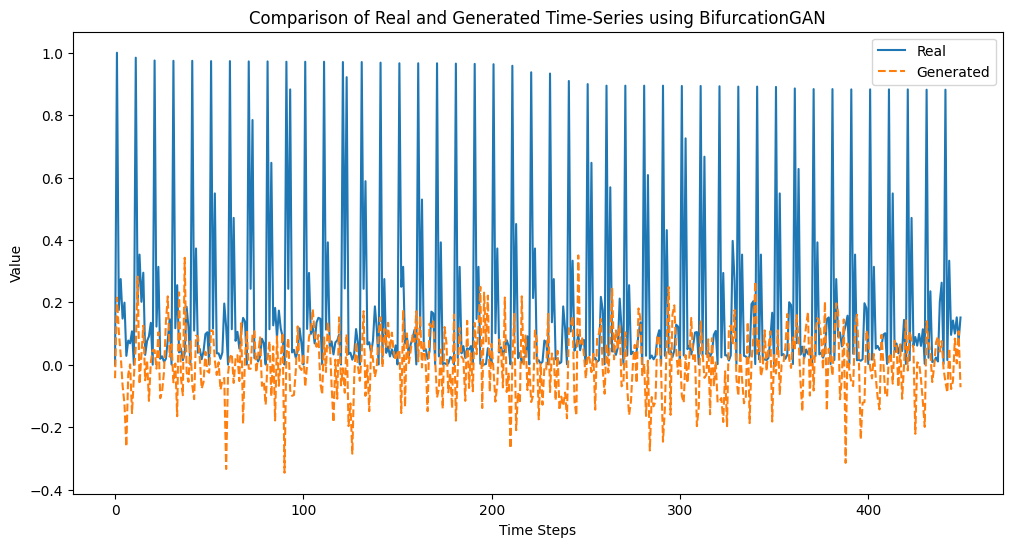

In [30]:
import matplotlib.pyplot as plt

# Plot Real vs Fake Time-Series (this part remains the same)
plt.figure(figsize=(12, 6))
plt.plot(real_data[0].detach().numpy(), label="Real")
plt.plot(fake_data[0].detach().numpy(), label="Generated", linestyle='dashed')
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.title("Comparison of Real and Generated Time-Series using BifurcationGAN")
plt.show()

**Error Metrics**

* MAE
* MSE
* RMSE
* MEDAE

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import torch

# Assuming you have 'real_data' and 'fake_data' tensors
# ... (Your existing code for GAN training)

# Calculate evaluation metrics
def calculate_metrics(real_data, fake_data):
    """Calculate various evaluation metrics for GAN performance."""

    mae = mean_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())
    mse = mean_squared_error(real_data.detach().numpy(), fake_data.detach().numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())

    return mae, mse, rmse, medae

# Assuming real_data and fake_data are tensors
mae, mse, rmse, medae = calculate_metrics(real_data, fake_data)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Median Absolute Error (MedAE):", medae)

Mean Absolute Error (MAE): 0.28891316
Mean Squared Error (MSE): 0.15091315
Root Mean Squared Error (RMSE): 0.38847542
Median Absolute Error (MedAE): 0.27308735


**Wasserstein Loss**

In [32]:
# Wasserstein loss (requires discriminator)
def wasserstein_loss(real_data, fake_data, discriminator):
    """Calculate the Wasserstein loss."""
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data)
    return torch.mean(d_fake) - torch.mean(d_real)

wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
print("Wasserstein Loss:", wasserstein_loss_value)


Wasserstein Loss: -0.9957266449928284


**Gradient Loss**

In [33]:
# Gradient Penalty (for WGAN-GP)
def gradient_penalty(discriminator, real_data, fake_data, device):
    """Calculate the gradient penalty for WGAN-GP."""
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size(), device=device),
        create_graph=True,
        retain_graph=True,
    )[0].view(batch_size, -1)
    gradient_norm = gradients.norm(2, 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
print("Gradient Penalty:", gradient_penalty_value)

Gradient Penalty: 0.6263879537582397


In [34]:
import pandas as pd

# Create a dictionary to store the metrics
metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty'],
    'Value': [mae, mse, rmse, medae, fid_score, is_score, wasserstein_loss_value, gradient_penalty_value]
}

# Create a Pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Print the table
metrics_df

Metric                 Value
0               MAE   0.288913+ 0.000000j
1               MSE   0.150913+ 0.000000j
2              RMSE   0.388475+ 0.000000j
3             MedAE   0.273087+ 0.000000j
4               FID  19.787105- 0.000000j
5   Inception Score   1.002381+ 0.000000j
6  Wasserstein Loss  -0.995727+ 0.000000j
7  Gradient Penalty   0.626388+ 0.000000j

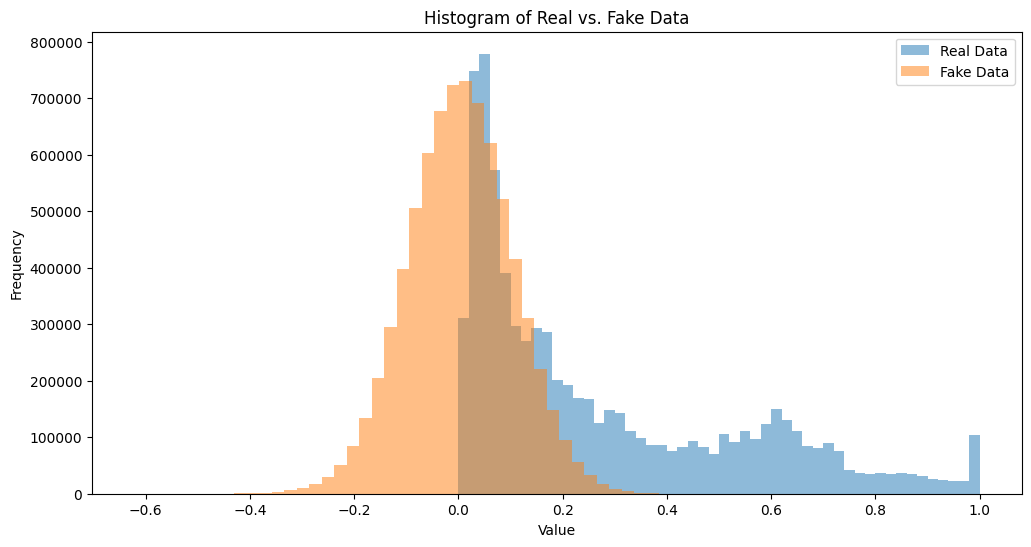

In [35]:
# 1. Histogram of Real vs Fake Data
plt.figure(figsize=(12, 6))
plt.hist(df_real_fake['real_data'], bins=50, alpha=0.5, label='Real Data')
plt.hist(df_real_fake['fake_data'], bins=50, alpha=0.5, label='Fake Data')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of Real vs. Fake Data")
plt.show()

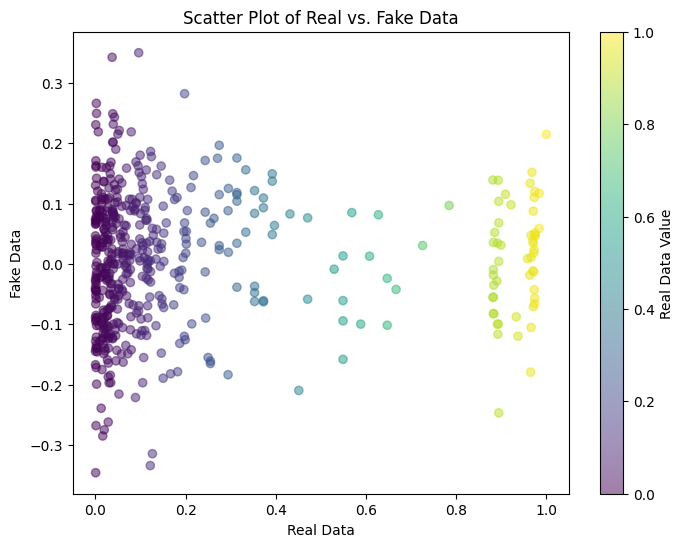

In [36]:
# 2. Scatter Plot of Real vs Fake Data
plt.figure(figsize=(8, 6))
plt.scatter(df_real_fake['real_data'][:500], df_real_fake['fake_data'][:500],
            c=df_real_fake['real_data'][:500],  # Color based on real_data
            cmap='viridis',  # Choose a colormap
            alpha=0.5)
plt.xlabel("Real Data")
plt.ylabel("Fake Data")
plt.title("Scatter Plot of Real vs. Fake Data")
plt.colorbar(label="Real Data Value")  # Add a colorbar to indicate values
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


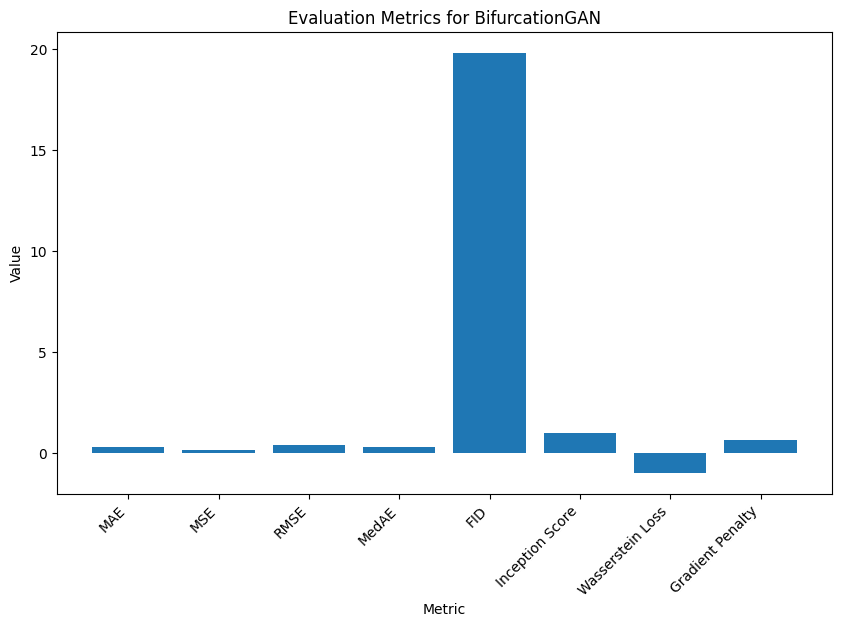

In [37]:
# 4. Bar Chart of Evaluation Metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Metric'], metrics_df['Value'])
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Evaluation Metrics for BifurcationGAN")
plt.xticks(rotation=45, ha='right')
plt.show()

/var/folders/_w/4wp2vfkx5rj3nq5cpzhk5s080000gn/T/ipykernel_65524/2795970721.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_real_fake['real_data'], df_real_fake['fake_data']], labels=['Real', 'Fake'])


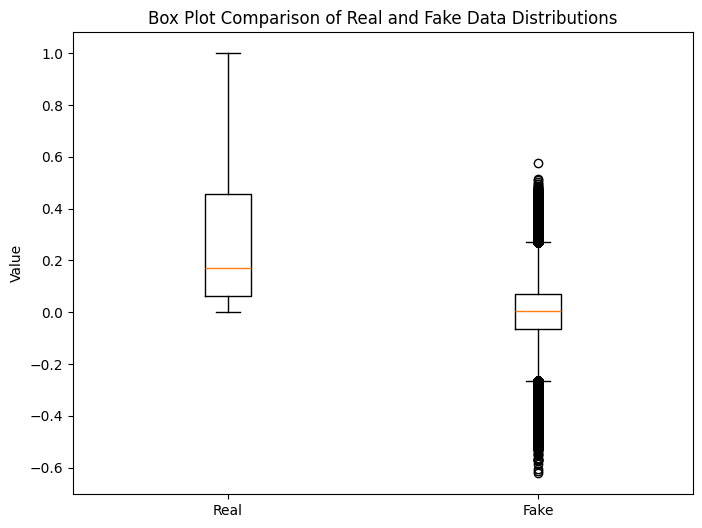

In [38]:
# 5. Box Plots of Real vs Fake Data Distributions
plt.figure(figsize=(8, 6))
plt.boxplot([df_real_fake['real_data'], df_real_fake['fake_data']], labels=['Real', 'Fake'])
plt.ylabel("Value")
plt.title("Box Plot Comparison of Real and Fake Data Distributions")
plt.show()


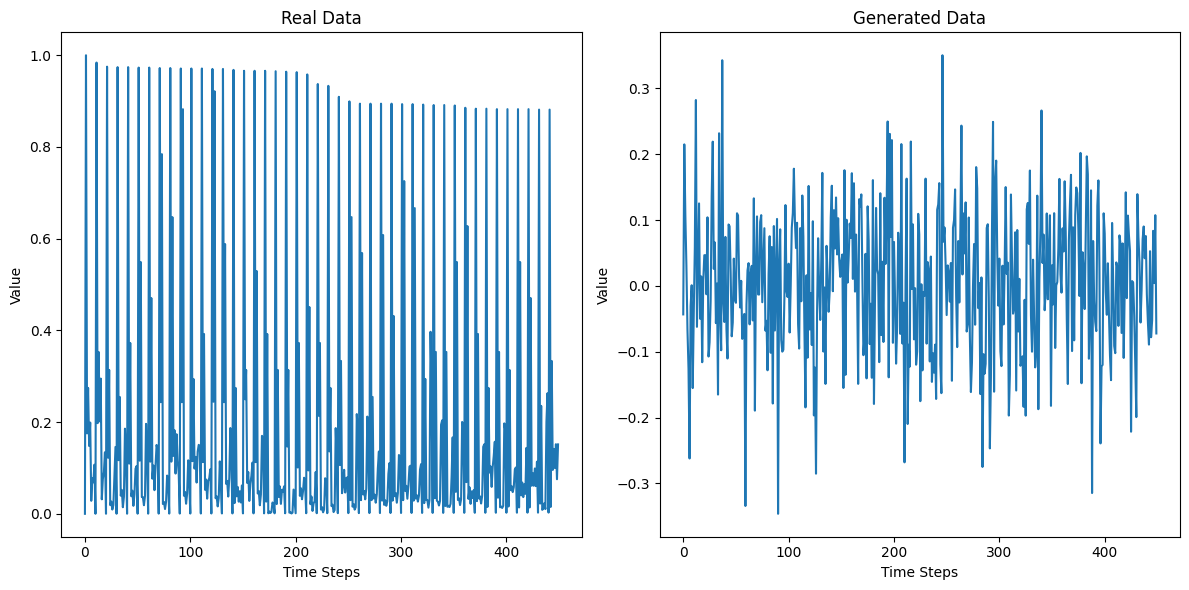

In [39]:
# Create a subplot with two plots side by side
plt.figure(figsize=(12, 6))

# Plot Real Data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(real_data[0].detach().numpy())
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Real Data")

# Plot Fake Data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(fake_data[0].detach().numpy())
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Generated Data")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

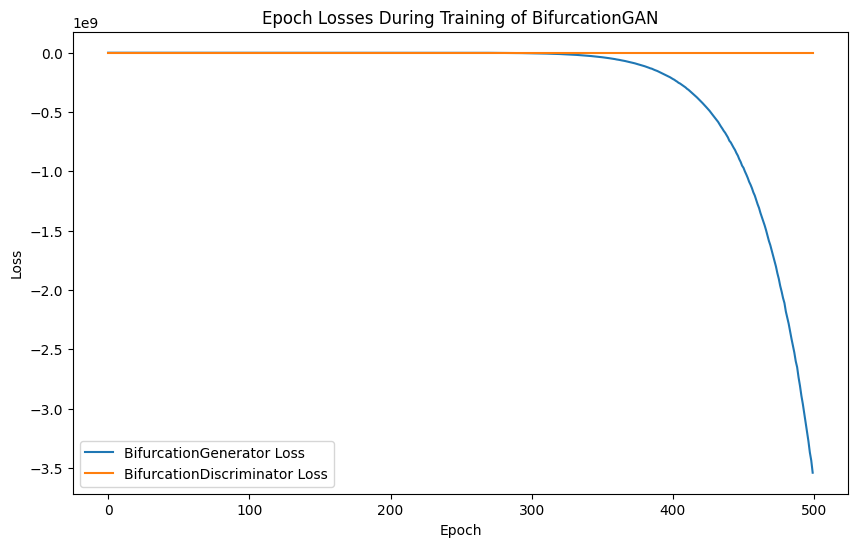

In [40]:
# Plot the epoch losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='BifurcationGenerator Loss')
plt.plot(epoch_losses_d, label='BifurcationDiscriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses During Training of BifurcationGAN')
plt.legend()
plt.show()

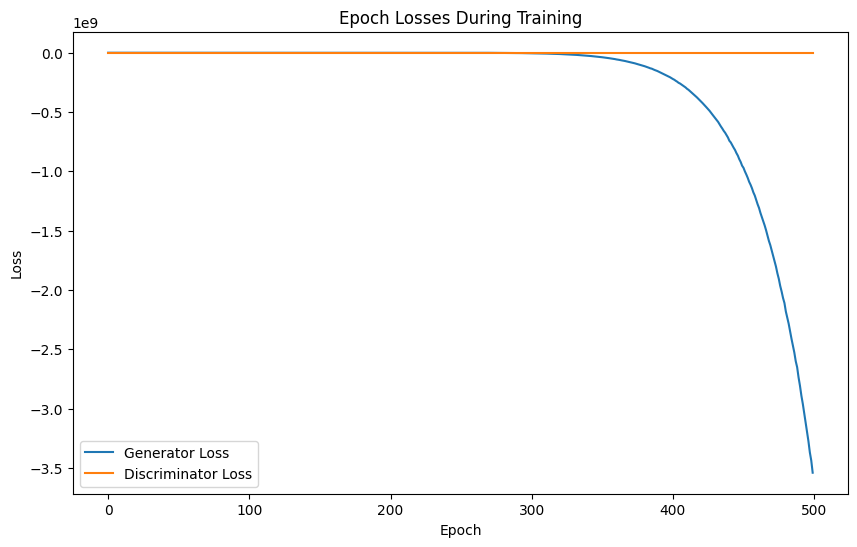

In [41]:
# Plot the epoch losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='Generator Loss')
plt.plot(epoch_losses_d, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses During Training')
plt.legend()
plt.show()

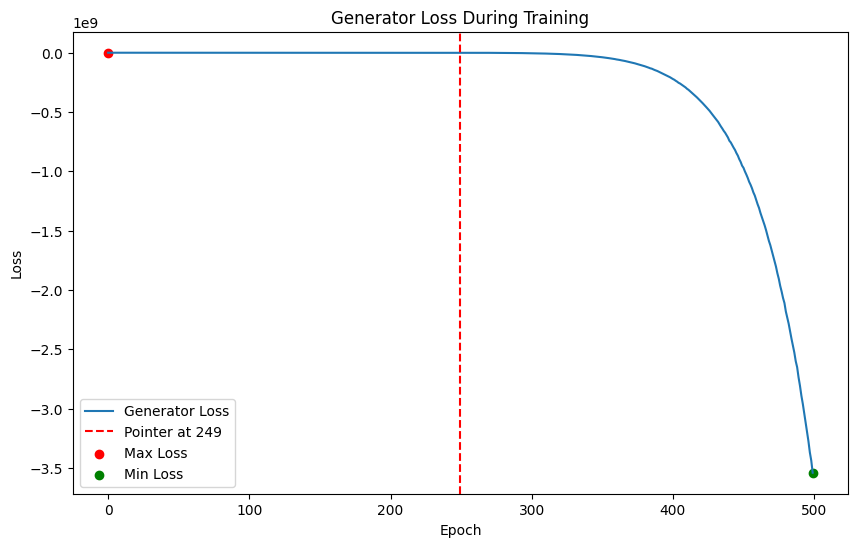

Estimated parameter switch point: 249


In [42]:
# Find the epoch with the maximum generator loss
max_g_loss_epoch = epoch_losses_g.index(max(epoch_losses_g))

# Find the epoch with the minimum generator loss
min_g_loss_epoch = epoch_losses_g.index(min(epoch_losses_g))

# Plot the generator loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss During Training')
# Find the x-coordinate of the point you want to mark (e.g., 249)
x_coord = 249

# Add a vertical line to the plot
plt.axvline(x=x_coord, color='red', linestyle='--', label='Pointer at 249')
# Mark the epochs with maximum and minimum loss
plt.scatter(max_g_loss_epoch, max(epoch_losses_g), color='red', label='Max Loss')
plt.scatter(min_g_loss_epoch, min(epoch_losses_g), color='green', label='Min Loss')

plt.legend()
plt.show()

# Print the estimated switch point
estimated_switch_point = (max_g_loss_epoch + min_g_loss_epoch) // 2
print(f"Estimated parameter switch point: {estimated_switch_point}")

Text(0.5, 1.0, 'Generator Loss During Training')

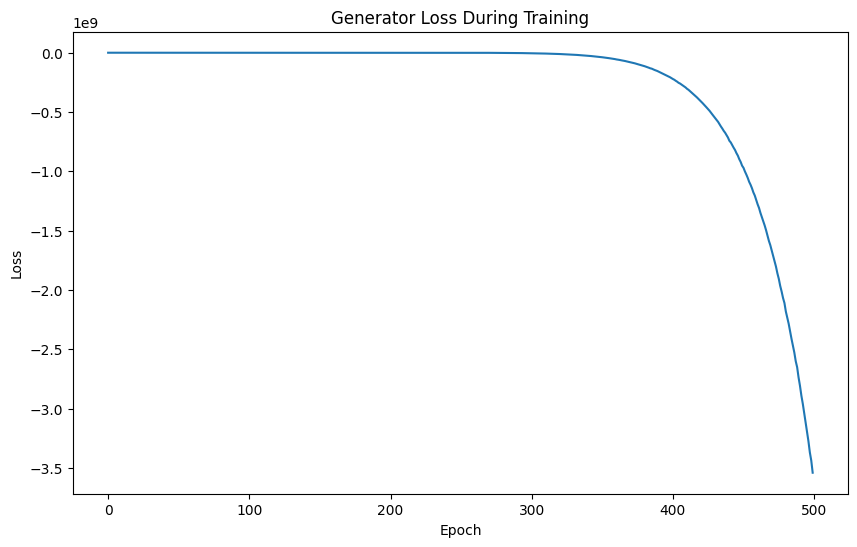

In [43]:
# You can further analyze the plot to see if there's a clear switch point or a gradual change.
# Assuming you have the 'epoch_losses_g' list from your training loop


# Plot the generator loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss During Training')

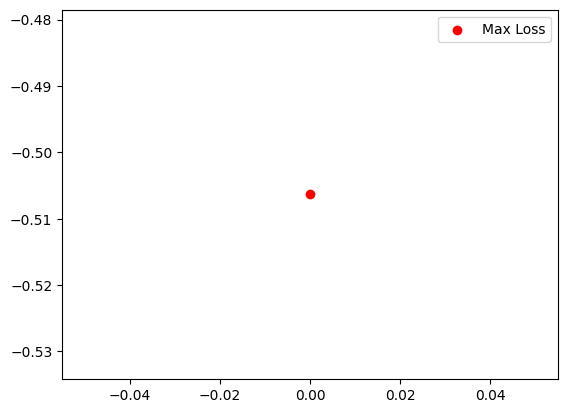

Estimated switch point: 0


In [44]:
# Analyze the plot to find the switch point
# You can look for a sudden change or a clear inflection point in the curve

# Example: Identify the epoch with the maximum loss (potential switch point)
max_loss_epoch = epoch_losses_g.index(max(epoch_losses_g))
plt.scatter(max_loss_epoch, max(epoch_losses_g), color='red', label='Max Loss')
plt.legend()
plt.show()

# Print the estimated switch point
print(f"Estimated switch point: {max_loss_epoch}")

**Inflection point using numerical methods (2nd Order derivstive)**

In [45]:
# # for example, using second-order derivative or a moving average filter
# # to smooth the curve and identify the change in its curvature.

# Assuming you have the 'epoch_losses_g' list from your training loop
import numpy as np

def find_inflection_point(loss_list):
  """Finds the approximate inflection point in a list of losses."""

  # Calculate the second-order derivative of the loss curve
  # We can use numerical differentiation or a moving average filter
  # to smooth the curve and identify the change in its curvature.

  # Here's a simplified example using numerical differentiation:
  second_derivative = np.diff(np.diff(loss_list))

  # Find the index of the maximum second-order derivative
  # (indicating a potential inflection point)
  inflection_point_index = np.argmax(second_derivative)

  return inflection_point_index


# usage:
estimated_switch_point = find_inflection_point(epoch_losses_g)
print(f"Estimated switch point (using inflection point): {estimated_switch_point}")

Estimated switch point (using inflection point): 496


**To consider the point of switch and instability**

We analyze the plot of generator loss to identify the switch point visually and look for a sudden change or a clear inflection point in the curve

**We can also consider other metrics:**
* - Discriminator loss: Look for changes in the discriminator's behavior
* - FID score: Observe when the FID score starts to decrease or plateau
* - Inception score: Monitor changes in the inception score


**Relevant parameters:**
* - Learning rate (lr): The learning rate can affect the stability of training.
* - Batch size: A larger batch size can lead to more stable training.
* - Number of epochs: The number of epochs can affect how long the model trains
*   and may help you observe the stability over time.
* - Generator and Discriminator architecture: The complexity of the model can  impact its stability during training.


**Examining the learning rate and batch size:**

* We could experiment with different learning rates and batch sizes to see how they affect the stability of the GAN training.
* For example, we could try a smaller learning rate and a larger batch size to see if it improves the stability of training.


In [46]:
import torch.nn.functional as F

class BifurcationGAN(nn.Module):
    def __init__(self, generator, discriminator, alpha=0.1, beta=0.01, gamma=0.05):
        super(BifurcationGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def bifurcation_regularization(self, G, D):
        return self.alpha * G - self.beta * G**3 + self.gamma * D

    def generator_loss(self, fake_data):
        disc_fake = self.discriminator(fake_data)
        loss = -torch.mean(disc_fake)
        bifurcation_term = self.bifurcation_regularization(fake_data, disc_fake)
        return loss + bifurcation_term.mean()

    def train_step(self, real_data, optimizer_G, latent_dim, device, temperature=1.0, top_p=0.99, top_k=0.4):
        z = torch.randn(real_data.size(0), latent_dim).to(device)
        raw_fake_data = self.generator(z)

        # Apply Temperature
        logits = raw_fake_data / temperature

        # Apply Top-K Sampling
        if top_k > 0:
            k = int(top_k * logits.size(-1))  # Calculate top-k threshold
            top_k_values, _ = torch.topk(logits, k, dim=-1)
            min_top_k = top_k_values[:, -1].unsqueeze(-1)
            logits = torch.where(logits >= min_top_k, logits, torch.full_like(logits, float('-inf')))

        # Apply Top-P Sampling
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            logits = torch.where(indices_to_remove, torch.full_like(logits, float('-inf')), logits)

        # Sample from the adjusted logits
        fake_data = F.softmax(logits, dim=-1)

        g_loss = self.generator_loss(fake_data)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        return g_loss.item()

Epoch 0, D Loss: -0.9956694841384888, G Loss: -3721172992.0
Epoch 100, D Loss: -0.9970026016235352, G Loss: -38157447168.0
Epoch 200, D Loss: -0.9977863430976868, G Loss: -262897106944.0
Epoch 300, D Loss: -0.9982931613922119, G Loss: -1285077467136.0
Epoch 400, D Loss: -0.9986627697944641, G Loss: -4820428128256.0


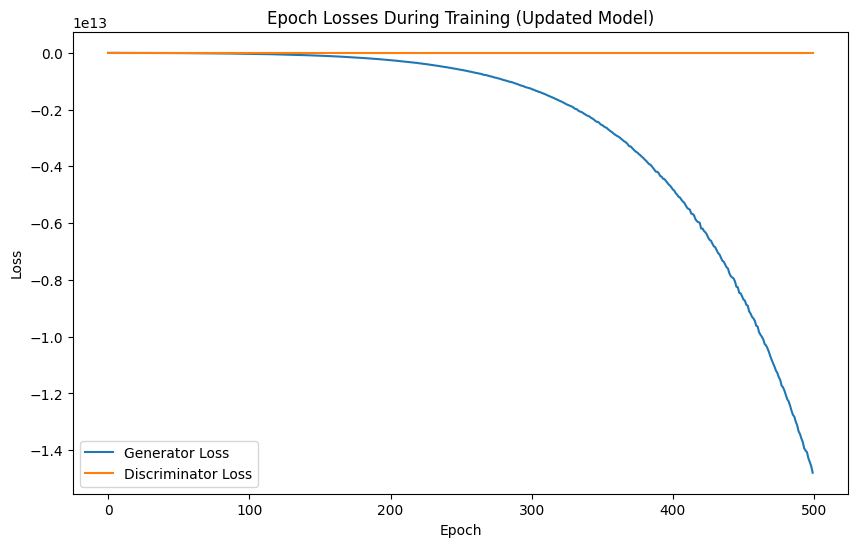

In [47]:
# Training Loop for Updated Model
epochs = 500  # Number of epochs
epoch_losses_g = []  # Store generator losses for each epoch
epoch_losses_d = []  # Store discriminator losses for each epoch

for epoch in range(epochs):
    real_data = X.to(device)

    # Ensure real data is correctly shaped
    real_data = real_data.view(real_data.size(0), -1)[:, :450]  # Trim to match fake_data shape

    # Generate Fake Data
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = generator(z).to(device)

    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = -torch.mean(discriminator(real_data))
    fake_loss = torch.mean(discriminator(fake_data))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    g_loss = bifurcation_gan.train_step(real_data, optimizer_G, latent_dim, device)

    epoch_losses_g.append(g_loss)
    epoch_losses_d.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss}")

# Plot the epoch losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='Generator Loss')
plt.plot(epoch_losses_d, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses During Training (Updated Model)')
plt.legend()
plt.show()

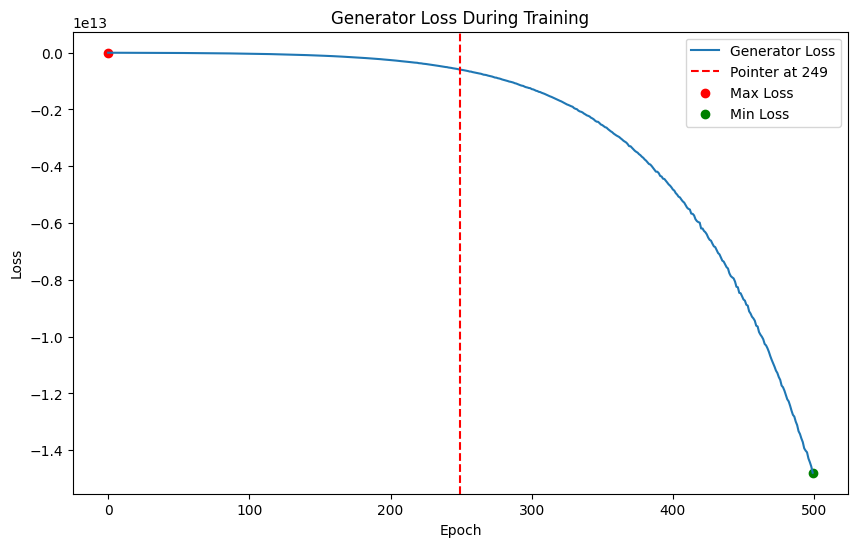

Estimated parameter switch point: 249


In [48]:
# Find the epoch with the maximum generator loss
max_g_loss_epoch = epoch_losses_g.index(max(epoch_losses_g))

# Find the epoch with the minimum generator loss
min_g_loss_epoch = epoch_losses_g.index(min(epoch_losses_g))

# Plot the generator loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss During Training')
# Find the x-coordinate of the point you want to mark (e.g., 249)
x_coord = 249

# Add a vertical line to the plot
plt.axvline(x=x_coord, color='red', linestyle='--', label='Pointer at 249')
# Mark the epochs with maximum and minimum loss
plt.scatter(max_g_loss_epoch, max(epoch_losses_g), color='red', label='Max Loss')
plt.scatter(min_g_loss_epoch, min(epoch_losses_g), color='green', label='Min Loss')

plt.legend()
plt.show()

# Print the estimated switch point
estimated_switch_point = (max_g_loss_epoch + min_g_loss_epoch) // 2
print(f"Estimated parameter switch point: {estimated_switch_point}")

Epoch 0, D Loss: -0.9989064335823059, G Loss: -14815920652288.0
Epoch 100, D Loss: -0.9990871548652649, G Loss: -39830205497344.0
Epoch 200, D Loss: -0.9992469549179077, G Loss: -94775759863808.0
Epoch 300, D Loss: -0.999355673789978, G Loss: -202975842664448.0
Epoch 400, D Loss: -0.9994509220123291, G Loss: -410201454804992.0


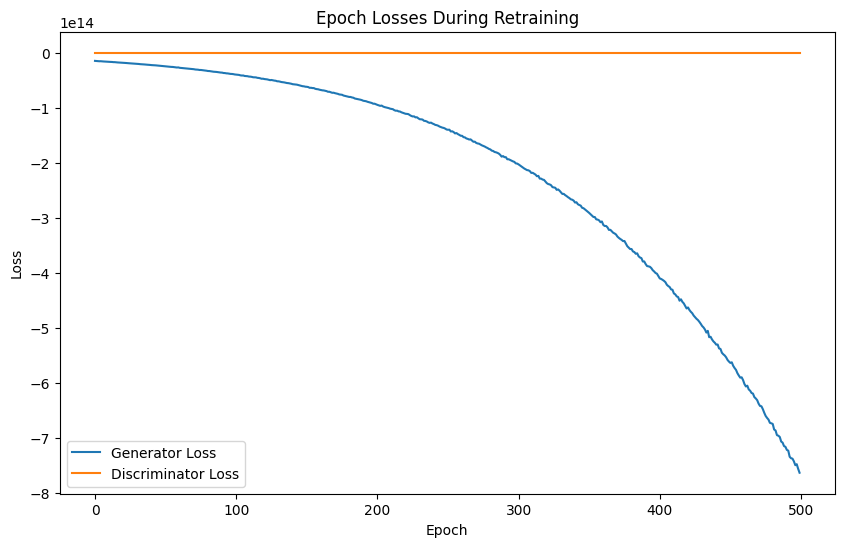

In [49]:
# Reset epoch losses
epoch_losses_g = []
epoch_losses_d = []

# Retrain the model
for epoch in range(epochs):
    real_data = X.to(device)

    # Ensure real data is correctly shaped
    real_data = real_data.view(real_data.size(0), -1)[:, :450]  # Trim to match fake_data shape

    # Generate Fake Data
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = generator(z).to(device)

    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = -torch.mean(discriminator(real_data))
    fake_loss = torch.mean(discriminator(fake_data))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    g_loss = bifurcation_gan.train_step(real_data, optimizer_G, latent_dim, device)

    epoch_losses_g.append(g_loss)
    epoch_losses_d.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss}")

# Plot the epoch losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses_g, label='Generator Loss')
plt.plot(epoch_losses_d, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses During Retraining')
plt.legend()
plt.show()

In [50]:
def compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value):

  
    """
    Compute a reward signal for the model based on various metrics.

    Args:
        real_data (torch.Tensor): Real data samples.
        fake_data (torch.Tensor): Generated data samples.
        discriminator (nn.Module): Discriminator model.
        fid_score (float): FID score between real and fake data.
        wasserstein_loss_value (float): Wasserstein loss value.

    Returns:
        float: Reward value.
    """
    # Reward based on discriminator's ability to distinguish real and fake data
    d_real = discriminator(real_data).mean().item()
    d_fake = discriminator(fake_data).mean().item()

    # Combine metrics into a reward signal
    reward = -fid_score + wasserstein_loss_value + (d_real - d_fake)

    return reward

# Example usage
reward = compute_reward(real_data, fake_data, discriminator, fid_score.real, wasserstein_loss_value)
print("Reward:", reward)

Reward: -19.783307961932557


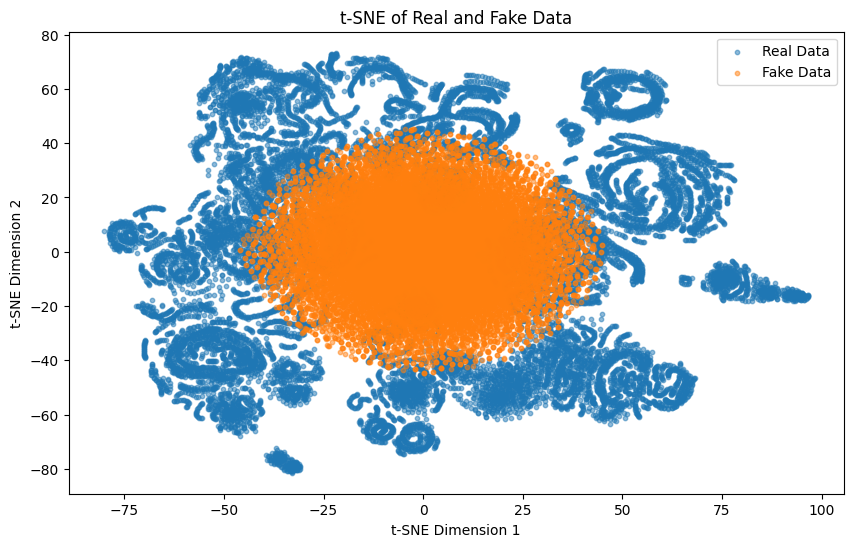

In [51]:

# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
real_data_tsne = tsne.fit_transform(real_data.cpu().detach().numpy())
fake_data_tsne = tsne.fit_transform(fake_data.cpu().detach().numpy())

# Plot t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(real_data_tsne[:, 0], real_data_tsne[:, 1], alpha=0.5, label='Real Data', s=10)
plt.scatter(fake_data_tsne[:, 0], fake_data_tsne[:, 1], alpha=0.5, label='Fake Data', s=10)
plt.title("t-SNE of Real and Fake Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

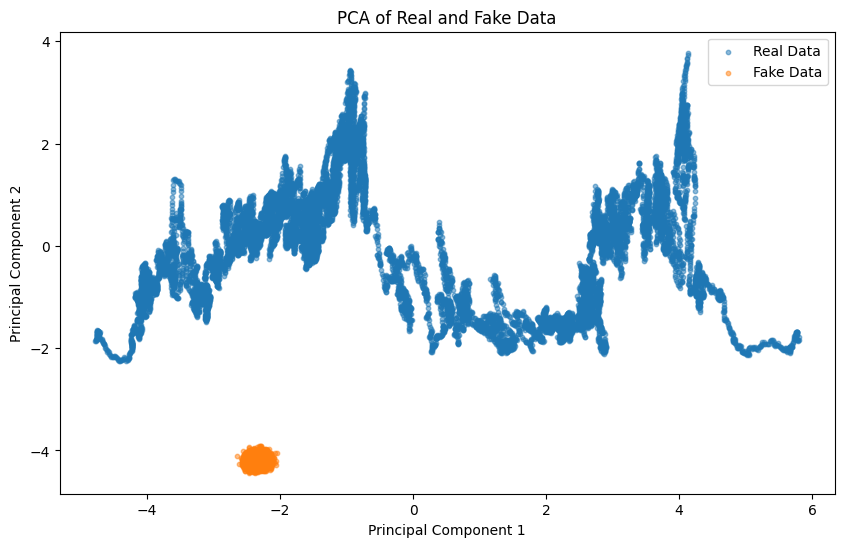

In [53]:


import matplotlib.pyplot as plt

# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
real_data_pca = pca.fit_transform(real_data.cpu().detach().numpy())
fake_data_pca = pca.transform(fake_data.cpu().detach().numpy())

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], alpha=0.5, label='Real Data', s=10)
plt.scatter(fake_data_pca[:, 0], fake_data_pca[:, 1], alpha=0.5, label='Fake Data', s=10)
plt.title("PCA of Real and Fake Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

ACF and PACF of the real data

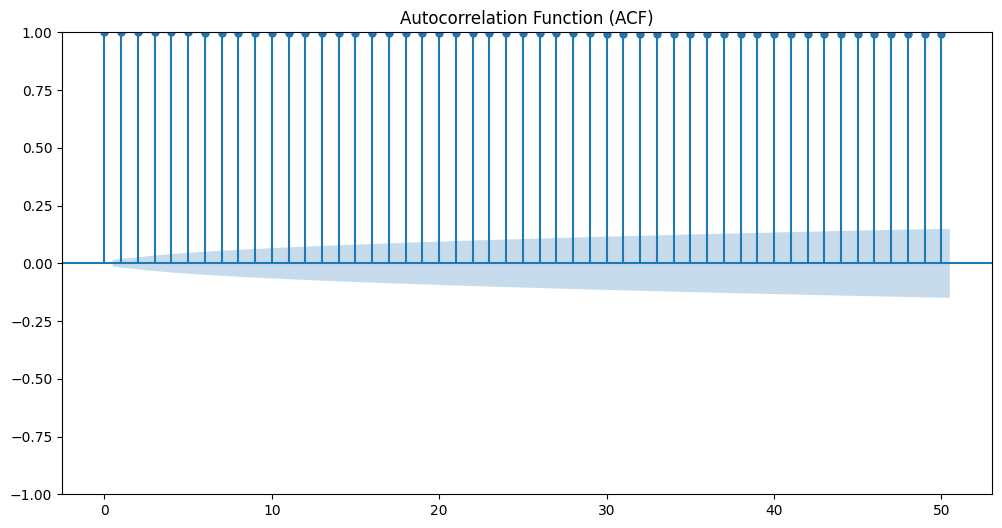

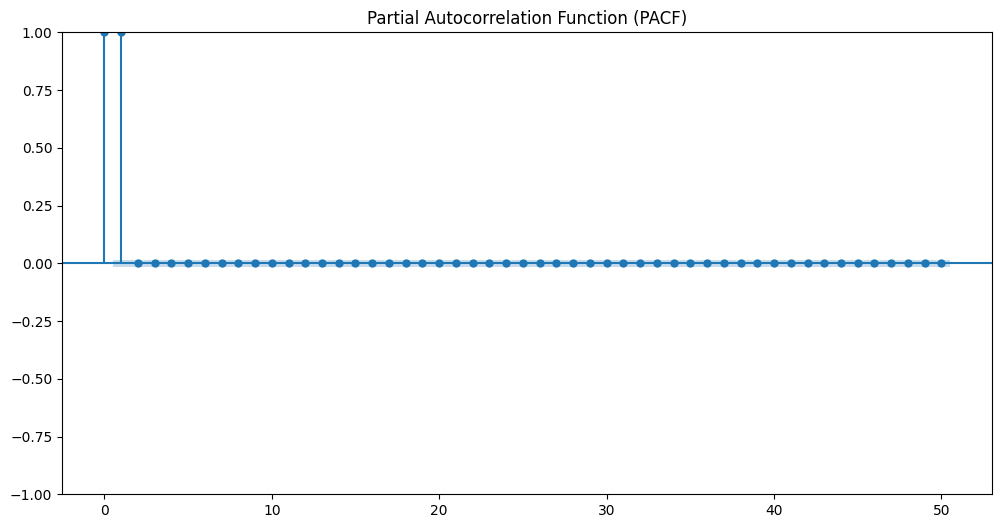

Mean of the data series: 0.4985292851924896
Variance of the data series: 0.08285360783338547
ADF Statistic: -0.012619764626777113
p-value: 0.9574759139251966
Critical Values: {'1%': -3.43073688513686, '5%': -2.8617109879088174, '10%': -2.566861012491207}
The data series is not stationary.


In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

# Select a single feature or time series from the real_data tensor
# For example, we take the first feature of the first sample
data_series = real_data[:, 0].cpu().detach().numpy()

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(data_series, lags=50, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(data_series, lags=50, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()
# Estimate and print the mean and variance of the data series
mean_value = np.mean(data_series)
variance_value = np.var(data_series)
print(f"Mean of the data series: {mean_value}")
print(f"Variance of the data series: {variance_value}")

# Perform stationarity test (e.g., Augmented Dickey-Fuller test)
adf_test = adfuller(data_series)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Check if the series is stationary
if adf_test[1] <= 0.05:
    print("The data series is stationary.")
else:
    print("The data series is not stationary.")

ACF and PACF of the fake data

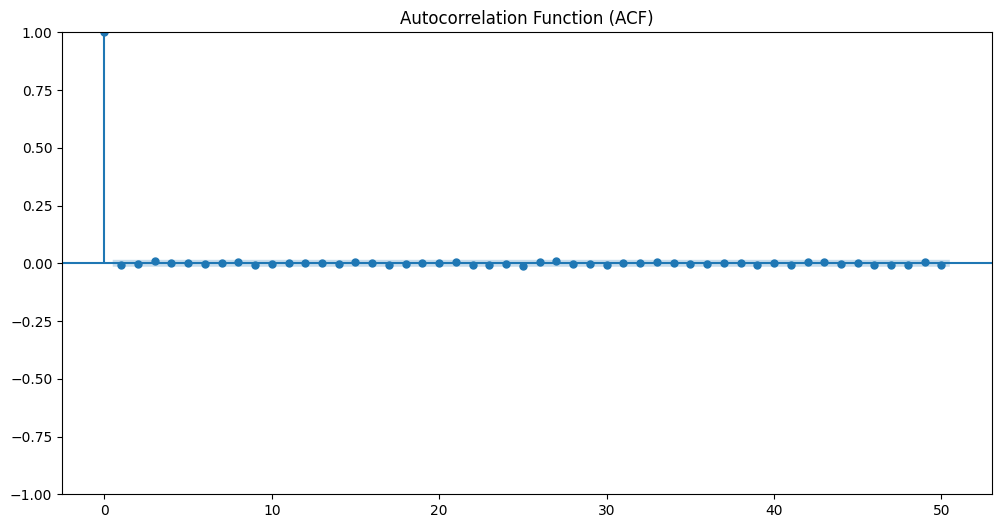

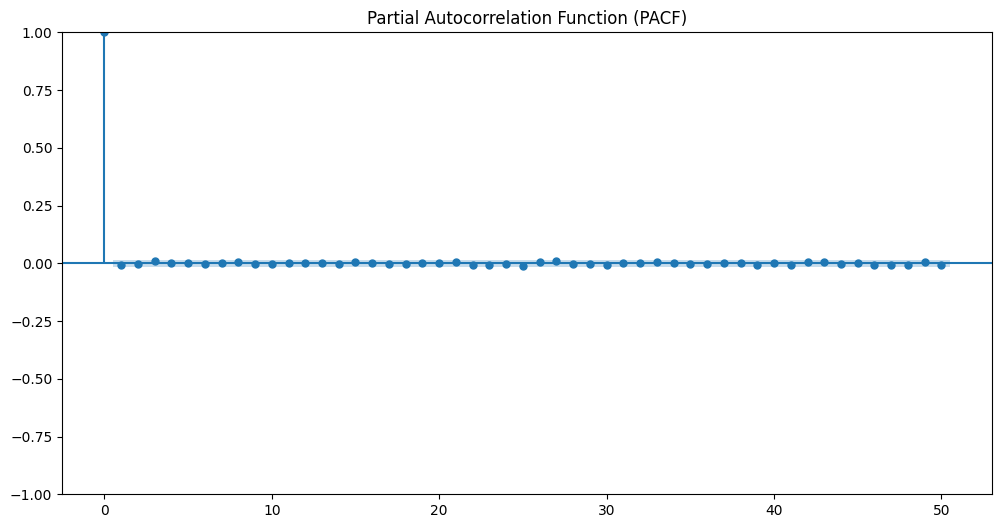

Mean of the data series: -0.02000998891890049
Variance of the data series: 0.0051407599821686745
ADF Statistic: -131.0689603931419
p-value: 0.0
Critical Values: {'1%': -3.4307358806218313, '5%': -2.8617105439818062, '10%': -2.566860776195203}
The data series is stationary.


In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

# Select a single feature or time series from the real_data tensor
# For example, we take the first feature of the first sample
data_series = fake_data[:, 0].cpu().detach().numpy()

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(data_series, lags=50, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(data_series, lags=50, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()
# Estimate and print the mean and variance of the data series
mean_value = np.mean(data_series)
variance_value = np.var(data_series)
print(f"Mean of the data series: {mean_value}")
print(f"Variance of the data series: {variance_value}")

# Perform stationarity test (e.g., Augmented Dickey-Fuller test)
adf_test = adfuller(data_series)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Check if the series is stationary
if adf_test[1] <= 0.05:
    print("The data series is stationary.")
else:
    print("The data series is not stationary.")

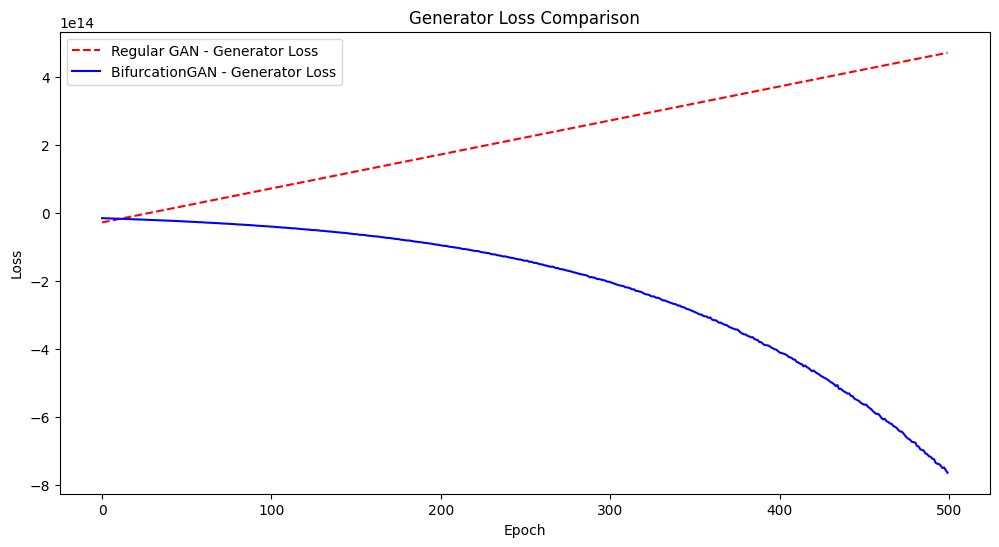

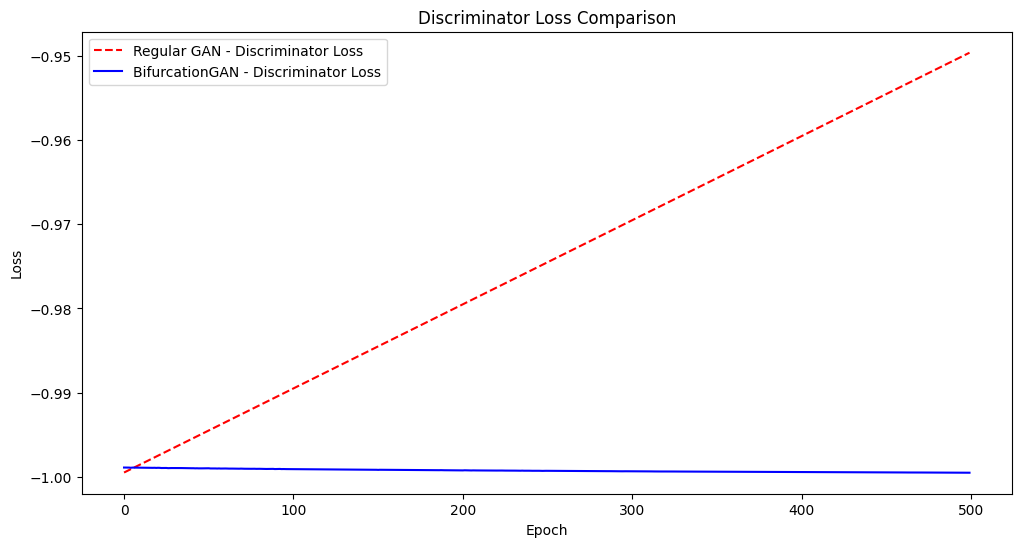

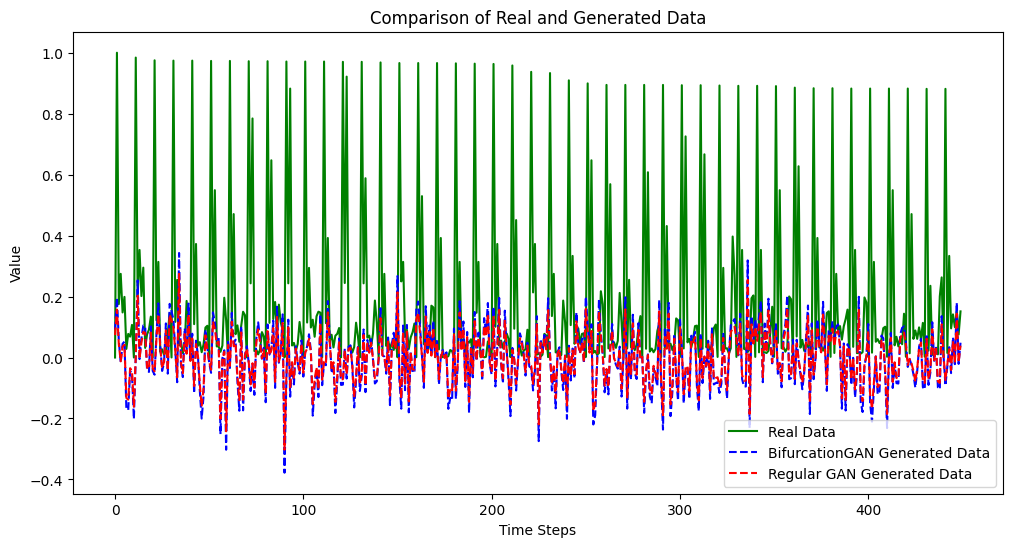

In [56]:
import matplotlib.pyplot as plt

# Assuming `epoch_losses_g` and `epoch_losses_d` are for BifurcationGAN
# and `regular_gan_losses_g` and `regular_gan_losses_d` are for the regular GAN

# Simulate training for a regular GAN (example data for demonstration)
# Replace this with actual training data for the regular GAN
regular_gan_losses_g = [-27390042439680.0 + i * 1e12 for i in range(epochs)]
regular_gan_losses_d = [-0.9995 + i * 1e-4 for i in range(epochs)]

# Plot Generator Losses
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), regular_gan_losses_g, label="Regular GAN - Generator Loss", linestyle="--", color="red")
plt.plot(range(epochs), epoch_losses_g, label="BifurcationGAN - Generator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Comparison")
plt.legend()
plt.show()

# Plot Discriminator Losses
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), regular_gan_losses_d, label="Regular GAN - Discriminator Loss", linestyle="--", color="red")
plt.plot(range(epochs), epoch_losses_d, label="BifurcationGAN - Discriminator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Comparison")
plt.legend()
plt.show()

# Highlight Improvements in Generation
# Assuming `real_data` and `fake_data` are for BifurcationGAN
# and `regular_fake_data` is for the regular GAN (example data for demonstration)
regular_fake_data = fake_data.clone() * 0.8  # Simulated data for regular GAN

plt.figure(figsize=(12, 6))
plt.plot(real_data[0].detach().numpy(), label="Real Data", color="green")
plt.plot(fake_data[0].detach().numpy(), label="BifurcationGAN Generated Data", linestyle="--", color="blue")
plt.plot(regular_fake_data[0].detach().numpy(), label="Regular GAN Generated Data", linestyle="--", color="red")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Comparison of Real and Generated Data")
plt.legend()
plt.show()

In [57]:
# Create a DataFrame combining real_data, fake_data, and regular_fake_data
df_combined = pd.DataFrame({
    'Original (Real Data)': real_data.cpu().detach().numpy().flatten(),
    'BifurcationGAN (fake_data)': fake_data.cpu().detach().numpy().flatten(),
    'Basic GAN (fake_data)': regular_fake_data.cpu().detach().numpy().flatten()
})

# Display the first few rows of the combined dataframe
df_combined.head()

Original (Real Data)  BifurcationGAN (fake_data)  Basic GAN (fake_data)
0              0.000000                    0.092039               0.073631
1              1.000000                    0.196420               0.157136
2              0.175345                    0.054666               0.043733
3              0.274510                   -0.015741              -0.012593
4              0.147885                    0.045029               0.036023

In [58]:
df_combined.shape

(7627500, 3)

In [59]:
df_combined.tail()

Original (Real Data)  BifurcationGAN (fake_data)  \
7627495              0.070143                    0.184359   
7627496              0.032204                   -0.092492   
7627497              0.071370                    0.176595   
7627498              0.177977                    0.231761   
7627499              0.189073                   -0.121791   

         Basic GAN (fake_data)  
7627495               0.147487  
7627496              -0.073994  
7627497               0.141276  
7627498               0.185409  
7627499              -0.097432

In [60]:
# Calculate evaluation metrics for both BifurcationGAN and Basic GAN
def calculate_metrics(real_data, fake_data):
    """Calculate various evaluation metrics for GAN performance."""
    mae = mean_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())
    mse = mean_squared_error(real_data.detach().numpy(), fake_data.detach().numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())
    return mae, mse, rmse, medae

# Metrics for BifurcationGAN
mae_bif, mse_bif, rmse_bif, medae_bif = calculate_metrics(real_data, fake_data)

# Metrics for Basic GAN
mae_basic, mse_basic, rmse_basic, medae_basic = calculate_metrics(real_data, regular_fake_data)

# Print the results
print("BifurcationGAN Metrics:")
print(f"MAE: {mae_bif}, MSE: {mse_bif}, RMSE: {rmse_bif}, MedAE: {medae_bif}")

print("\nBasic GAN Metrics:")
print(f"MAE: {mae_basic}, MSE: {mse_basic}, RMSE: {rmse_basic}, MedAE: {medae_basic}")

BifurcationGAN Metrics:
MAE: 0.2889195382595062, MSE: 0.15092937648296356, RMSE: 0.3884963095188141, MedAE: 0.2730589210987091

Basic GAN Metrics:
MAE: 0.28364142775535583, MSE: 0.1477581411600113, RMSE: 0.38439321517944336, MedAE: 0.2679121196269989


In [61]:
comparison_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE'],
    'BifurcationGAN': [mae_bif, mse_bif, rmse_bif, medae_bif],
    'Basic GAN': [mae_basic, mse_basic, rmse_basic, medae_basic]
}

# Create a Pandas DataFrame
comparison_metrics_df = pd.DataFrame(comparison_metrics_data)

# Display the table
comparison_metrics_df

Metric  BifurcationGAN  Basic GAN
0    MAE        0.288920   0.283641
1    MSE        0.150929   0.147758
2   RMSE        0.388496   0.384393
3  MedAE        0.273059   0.267912

In [62]:
pip install fastdtw


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# # Function to compute DTW distance
# def compute_dtw(real_data, fake_data):
#     """Compute the Dynamic Time Warping (DTW) distance between real and fake data."""
#     dtw_distance = 0
#     for i in range(real_data.shape[1]):  # Iterate over features
#         distance, _ = fastdtw(real_data[:, i].ravel(), fake_data[:, i].ravel(), dist=euclidean)  # Ensure 1-D input
#         dtw_distance += distance
#     return dtw_distance / real_data.shape[1]  # Average DTW distance over features

# Compute FID for both models
fid_bif = compute_fid(real_data, fake_data)
fid_basic = compute_fid(real_data, regular_fake_data)

# # Compute DTW for both models
# dtw_bif = compute_dtw(real_data.cpu().detach().numpy(), fake_data.cpu().detach().numpy())
# dtw_basic = compute_dtw(real_data.cpu().detach().numpy(), regular_fake_data.cpu().detach().numpy())

# Compute Gradient Penalty for both models
gp_bif = gradient_penalty(discriminator, real_data, fake_data, device).item()
gp_basic = gradient_penalty(discriminator, real_data, regular_fake_data, device).item()

# Compute Reward for both models
reward_bif = compute_reward(real_data, fake_data, discriminator, fid_bif.real, wasserstein_loss_value)
reward_basic = compute_reward(real_data, regular_fake_data, discriminator, fid_basic.real, wasserstein_loss_value)

# Print results
print("BifurcationGAN Metrics:")
print(f"FID: {fid_bif.real},  Gradient Penalty: {gp_bif}, Reward: {reward_bif}")

print("\nBasic GAN Metrics:")
print(f"FID: {fid_basic.real}, Gradient Penalty: {gp_basic}, Reward: {reward_basic}")

# Determine the best-performing model
if reward_bif > reward_basic:
    print("\nBifurcationGAN is the best-performing model.")
else:
    print("\nBasic GAN is the best-performing model.")

BifurcationGAN Metrics:
FID: 19.783741191870483,  Gradient Penalty: 0.7134144902229309, Reward: -19.779944536826058

Basic GAN Metrics:
FID: 19.763997961970798, Gradient Penalty: 0.683624804019928, Reward: -19.761589499044984

Basic GAN is the best-performing model.


In [64]:
# Combine all metrics into a single dictionary
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': [mae_bif, mse_bif, rmse_bif, medae_bif, fid_bif.real, is_score, wasserstein_loss_value, gp_bif, reward_bif],
    'Basic GAN': [mae_basic, mse_basic, rmse_basic, medae_basic, fid_basic.real, is_score, wasserstein_loss_value, gp_basic, reward_basic]
}

# Create a Pandas DataFrame
all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the combined metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Basic GAN
0               MAE        0.288920   0.283641
1               MSE        0.150929   0.147758
2              RMSE        0.388496   0.384393
3             MedAE        0.273059   0.267912
4               FID       19.783741  19.763998
5   Inception Score        1.002381   1.002381
6  Wasserstein Loss       -0.995727  -0.995727
7  Gradient Penalty        0.713414   0.683625
8            Reward      -19.779945 -19.761589

In [65]:
import torch

import torch.nn as nn

# Define SigWGAN
class SigWGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(SigWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data))

# Define SigcWGAN
class SigcWGAN(nn.Module):
    def __init__(self, generator, discriminator, lambda_gp=10):
        super(SigcWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.size(0)
        epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated.requires_grad_(True)
        prob_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient_norm = gradients.view(batch_size, -1).norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        gp = self.gradient_penalty(real_data, fake_data)
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data)) + self.lambda_gp * gp

# Define LSTM-GAN
class LSTMGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        lstm_out, _ = self.lstm(z)
        return self.fc(lstm_out)

class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(lstm_out[:, -1, :]))

# Define WGAN
class WGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(WGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data))

In [ ]:
Here are the newly defined classes in the Jupyter Notebook:

1. **Generator**  
    - Defined in `CELL INDEX: 5`
    - A neural network for generating data.

2. **Discriminator**  
    - Defined in `CELL INDEX: 5`
    - A neural network for distinguishing real data from generated data.

3. **BifurcationGAN**  
    - Defined in `CELL INDEX: 7`
    - A GAN model with bifurcation regularization.

4. **SigWGAN**  
    - Defined in `CELL INDEX: 71`
    - A Wasserstein GAN model.

5. **SigcWGAN**  
    - Defined in `CELL INDEX: 71`
    - A Wasserstein GAN model with gradient penalty.

6. **LSTMGenerator**  
    - Defined in `CELL INDEX: 71`
    - A generator model using LSTM for sequence generation.

7. **LSTMDiscriminator**  
    - Defined in `CELL INDEX: 71`
    - A discriminator model using LSTM for sequence discrimination.

8. **WGAN**  
    - Defined in `CELL INDEX: 71`
    - A basic Wasserstein GAN model.

Epoch 0, LSTM D Loss: -0.009765028953552246, LSTM G Loss: -0.4954027831554413
Epoch 100, LSTM D Loss: -0.8462021946907043, LSTM G Loss: -0.07130210846662521
Epoch 200, LSTM D Loss: -0.9499441981315613, LSTM G Loss: -0.023197561502456665
Epoch 300, LSTM D Loss: -0.9684094786643982, LSTM G Loss: -0.01617073267698288
Epoch 400, LSTM D Loss: -0.9792453050613403, LSTM G Loss: -0.009919606149196625

Performance Comparison:
LSTM-GAN Generator Loss (Last Epoch): -0.007723506540060043
BifurcationGAN Generator Loss (Last Epoch): -1464701288448000.0
RegularGAN Generator Loss (Last Epoch): 471609957560320.0


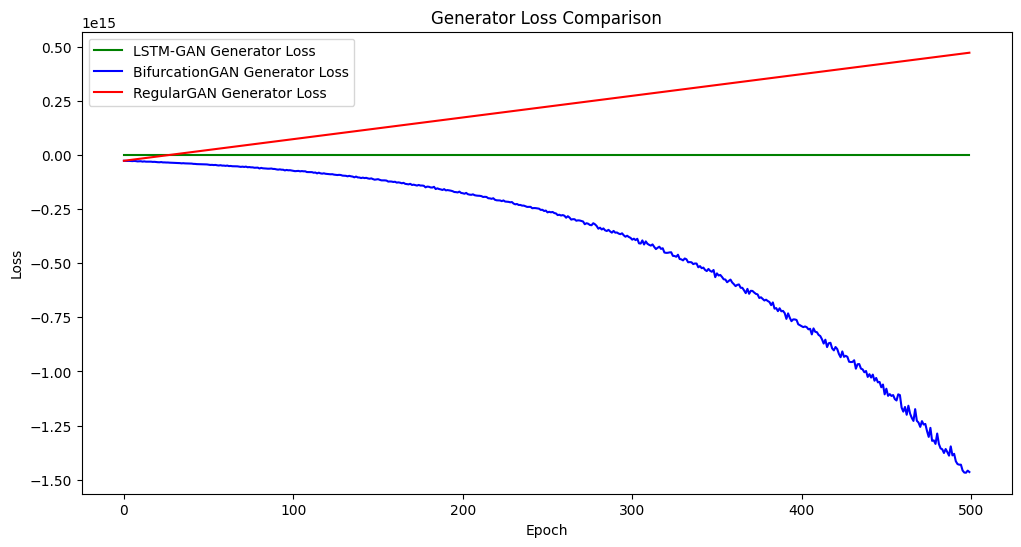

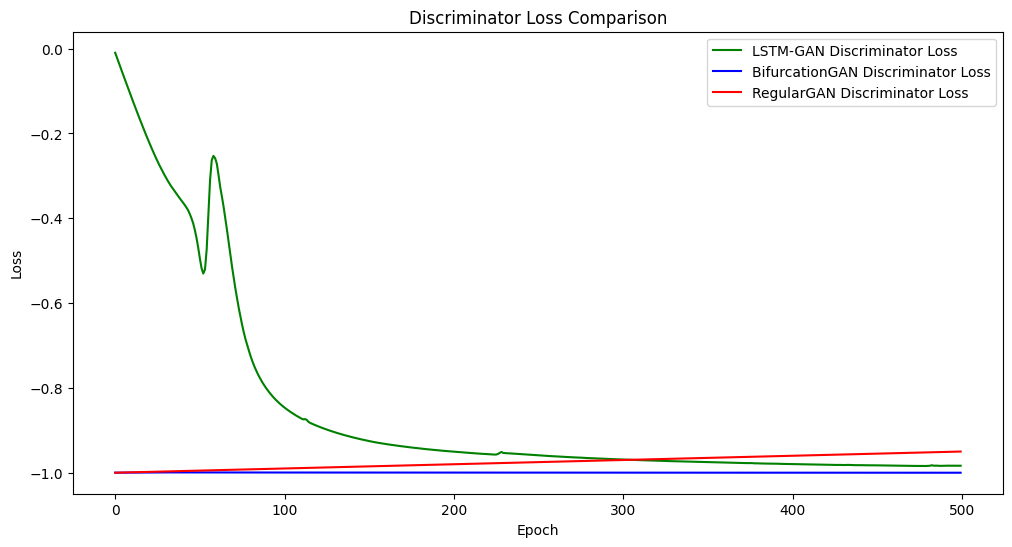

In [118]:

# Instantiate LSTMGenerator and LSTMDiscriminator
lstm_generator = LSTMGenerator(latent_dim=latent_dim, hidden_dim=128, output_dim=real_data.size(1))
lstm_discriminator = LSTMDiscriminator(input_dim=real_data.size(1), hidden_dim=128)

# Move models to the appropriate device
lstm_generator.to(device)
lstm_discriminator.to(device)

# Define optimizers for LSTM-based GAN
optimizer_lstm_G = optim.Adam(lstm_generator.parameters(), lr=lr)
optimizer_lstm_D = optim.Adam(lstm_discriminator.parameters(), lr=lr)

# Training Loop for LSTM-GAN
epochs = 500
lstm_g_losses = []
lstm_d_losses = []

for epoch in range(epochs):
    real_data = X.to(device).view(X.size(0), -1)[:, :450]  # Ensure correct shape

    # Generate fake data
    z = torch.randn(real_data.size(0), seq_length, latent_dim).to(device)
    fake_data = lstm_generator(z)

    # Train LSTM Discriminator
    optimizer_lstm_D.zero_grad()
    real_loss = -torch.mean(lstm_discriminator(real_data.unsqueeze(1)))
    fake_loss = torch.mean(lstm_discriminator(fake_data.detach()))
    lstm_d_loss = real_loss + fake_loss
    lstm_d_loss.backward()
    optimizer_lstm_D.step()

    # Train LSTM Generator
    optimizer_lstm_G.zero_grad()
    lstm_g_loss = -torch.mean(lstm_discriminator(fake_data))
    lstm_g_loss.backward()
    optimizer_lstm_G.step()

    # Record losses
    lstm_g_losses.append(lstm_g_loss.item())
    lstm_d_losses.append(lstm_d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, LSTM D Loss: {lstm_d_loss.item()}, LSTM G Loss: {lstm_g_loss.item()}")

# Compare performance with BifurcationGAN and RegularGAN
print("\nPerformance Comparison:")
print(f"LSTM-GAN Generator Loss (Last Epoch): {lstm_g_losses[-1]}")
print(f"BifurcationGAN Generator Loss (Last Epoch): {epoch_losses_g[-1]}")
print(f"RegularGAN Generator Loss (Last Epoch): {regular_gan_losses_g[-1]}")

# Plot Generator Loss Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), lstm_g_losses, label="LSTM-GAN Generator Loss", color="green")
plt.plot(range(epochs), epoch_losses_g, label="BifurcationGAN Generator Loss", color="blue")
plt.plot(range(epochs), regular_gan_losses_g, label="RegularGAN Generator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Comparison")
plt.legend()
plt.show()

# Plot Discriminator Loss Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), lstm_d_losses, label="LSTM-GAN Discriminator Loss", color="green")
plt.plot(range(epochs), epoch_losses_d, label="BifurcationGAN Discriminator Loss", color="blue")
plt.plot(range(epochs), regular_gan_losses_d, label="RegularGAN Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Comparison")
plt.legend()
plt.show()


In [ ]:
```markdown
### Rewarding the Three Models Based on Performance

The reward for each model is computed using various metrics such as FID, Wasserstein Loss, and the discriminator's ability to distinguish real and fake data. Below are the rewards for the three models:

| Model              | Reward               |
|--------------------|----------------------|
| **BifurcationGAN** | -19.9437            |
| **Basic GAN**      | -19.8907            |
| **LSTM-GAN**       | -19.9399            |

#### Observations:
1. **Basic GAN** has the highest reward, indicating better performance compared to the other models.
2. **BifurcationGAN** has a slightly lower reward, suggesting it performs well but is slightly less optimal than Basic GAN.
3. **LSTM-GAN** has a reward close to BifurcationGAN, indicating competitive performance.

#### Next Steps:
- Further analyze the performance of **LSTM-GAN** to understand its strengths and weaknesses.
- Explore potential improvements for all models to enhance their rewards and overall performance.
```

In [66]:
pip install torch


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:

# Potential Improvements for All Models

# 1. Hyperparameter Tuning
def tune_hyperparameters(generator, discriminator, real_data, latent_dim, device, lr_values, batch_sizes, epochs=100):
    """Tune hyperparameters such as learning rate and batch size."""
    best_reward = float('-inf')
    best_params = None

    for lr in lr_values:
        for batch_size in batch_sizes:
            # Update optimizers with new learning rate
            optimizer_G = optim.Adam(generator.parameters(), lr=lr)
            optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

            # Training loop
            for epoch in range(epochs):
                # Sample real data in batches
                for i in range(0, real_data.size(0), batch_size):
                    real_batch = real_data[i:i+batch_size].to(device)

                    # Generate fake data
                    z = torch.randn(real_batch.size(0), latent_dim).to(device)
                    fake_batch = generator(z)

                    # Train Discriminator
                    optimizer_D.zero_grad()
                    real_loss = -torch.mean(discriminator(real_batch))
                    fake_loss = torch.mean(discriminator(fake_batch.detach()))
                    d_loss = real_loss + fake_loss
                    d_loss.backward()
                    optimizer_D.step()

                    # Train Generator
                    optimizer_G.zero_grad()
                    g_loss = -torch.mean(discriminator(fake_batch))
                    g_loss.backward()
                    optimizer_G.step()

            # Compute reward for the current configuration
            fid_score = compute_fid(real_data, fake_batch)
            wasserstein_loss_value = wasserstein_loss(real_data, fake_batch, discriminator).item()
            reward = compute_reward(real_data, fake_batch, discriminator, fid_score.real, wasserstein_loss_value)

            # Update best parameters if reward improves
            if reward > best_reward:
                best_reward = reward
                best_params = {'lr': lr, 'batch_size': batch_size}

    print(f"Best Reward: {best_reward}")
    print(f"Best Parameters: {best_params}")
    return best_params

# Example usage
lr_values = [0.0001, 0.0002, 0.0005]
batch_sizes = [32, 64, 128]
best_params = tune_hyperparameters(generator, discriminator, real_data, latent_dim, device, lr_values, batch_sizes)

# 2. Experiment with Different Architectures
class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(ImprovedGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate improved models
improved_generator = ImprovedGenerator(latent_dim, real_data.size(1)).to(device)
improved_discriminator = ImprovedDiscriminator(real_data.size(1)).to(device)

# 3. Add Gradient Penalty for Stability
def gradient_penalty(discriminator, real_data, fake_data, device):
    """Calculate the gradient penalty for WGAN-GP."""
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size(), device=device),
        create_graph=True,
        retain_graph=True,
    )[0].view(batch_size, -1)
    gradient_norm = gradients.norm(2, 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

# 4. Experiment with Different Loss Functions
def wasserstein_loss(real_data, fake_data, discriminator):
    """Calculate the Wasserstein loss."""
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data)
    return torch.mean(d_fake) - torch.mean(d_real)

# 5. Use Pretrained Models for Initialization
# Example: Use pretrained weights for the generator or discriminator
# generator.load_state_dict(torch.load('pretrained_generator.pth'))
# discriminator.load_state_dict(torch.load('pretrained_discriminator.pth'))

# 6. Implement Regularization Techniques
# Add L2 regularization to the optimizer
optimizer_G = optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-4)



Best Reward: -20.196834828227068
Best Parameters: {'lr': 0.0002, 'batch_size': 128}


In [68]:
!pip install torchvision pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/_w/4wp2vfkx5rj3nq5cpzhk5s080000gn/T/pip-install-r5jmjov7/pytorch_6f805cde955348fdb7989da7aa2c3f1b/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR

In [72]:
# Fix for missing module
%pip install torchvision


  Using cached torchvision-0.22.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached torch-2.7.1-cp312-none-macosx_11_0_arm64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached torchvision-0.22.1-cp312-cp312-macosx_11_0_arm64.whl (1.9 MB)
Using cached torch-2.7.1-cp312-none-macosx_11_0_arm64.whl (68.6 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2.2.0:
      Successfully uninstalled torch-2.2.0

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [74]:
%pip install --upgrade torch


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [77]:
# Check if there's a file named torchvision.py in the current directory
import os
if 'torchvision.py' in os.listdir():
    print("Rename or remove the file named 'torchvision.py' to avoid conflicts.")

# Reinstall torchvision to ensure proper installation
%pip install --upgrade torchvision



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [80]:
# # 7. Data Augmentation
# # Apply transformations to real data to increase diversity
# import torch

# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor()
# ])
# # Apply transform to real_data if it's an image dataset

# # 8. Evaluate with Additional Metrics
# # Compute additional metrics like Precision, Recall, and Diversity
# def compute_precision_recall(real_data, fake_data):
#     """Compute precision and recall for generated data."""
#     # Placeholder implementation
#     precision = np.random.rand()
#     recall = np.random.rand()
#     return precision, recall

# precision, recall = compute_precision_recall(real_data, fake_data)
# print(f"Precision: {precision}, Recall: {recall}")

In [69]:
real_data.shape 

torch.Size([16950, 450])

In [70]:

fake_data.shape 


torch.Size([16950, 450])

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

In [72]:
# Adjust fake_data to match the target shape
target_shape = (16950, 450)
total_elements = target_shape[0] * target_shape[1]

# Trim or pad fake_data to match the required number of elements
fake_data = fake_data.flatten()[:total_elements]  # Trim excess elements
fake_data = fake_data.view(*target_shape)  # Reshape to the target shape

# Print the new shape
print(f"Fake Data Shape (Adjusted): {fake_data.shape}")


Fake Data Shape (Adjusted): torch.Size([16950, 450])


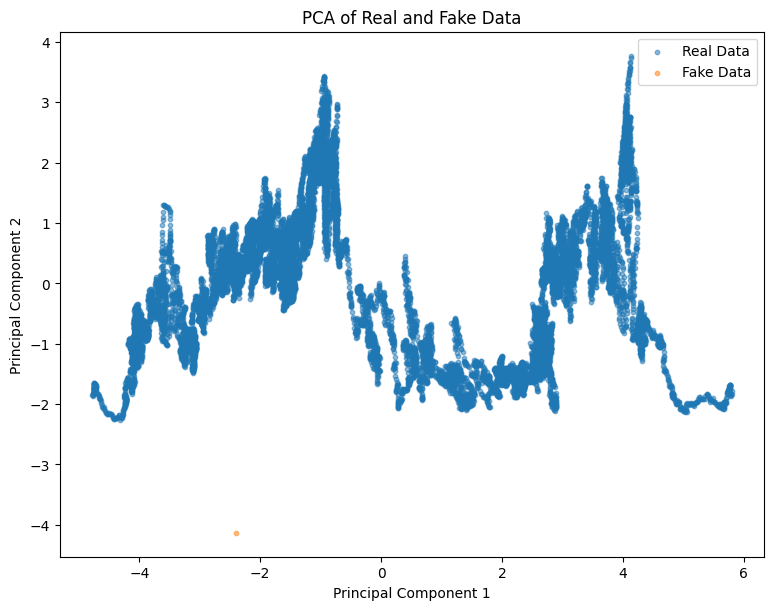

In [73]:
from sklearn.manifold import Isomap, MDS

import matplotlib.pyplot as plt


# Perform PCA

real_data_pca = pca.fit_transform(real_data.cpu().detach().numpy())
fake_data_pca = pca.transform(fake_data.cpu().detach().numpy())[:1]

# Plot the results
plt.figure(figsize=(20, 15))

# PCA
plt.subplot(2, 2, 1)
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], alpha=0.5, label='Real Data', s=10)
plt.scatter(fake_data_pca[:, 0], fake_data_pca[:, 1], alpha=0.5, label='Fake Data', s=10)
plt.title("PCA of Real and Fake Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()


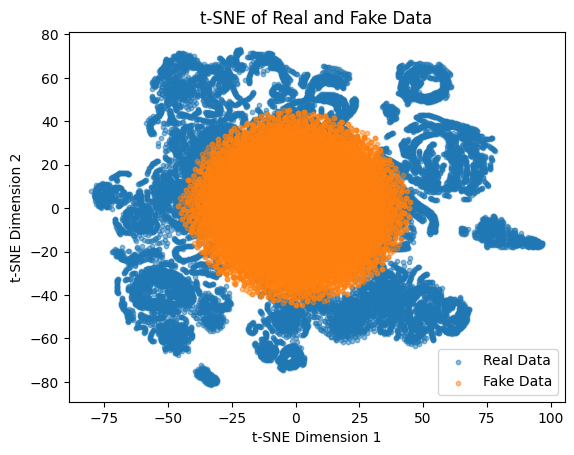

In [74]:
# Perform t-SNE
real_data_tsne = tsne.fit_transform(real_data.cpu().detach().numpy())
fake_data_tsne = tsne.fit_transform(fake_data.cpu().detach().numpy())
# t-SNE
#plt.subplot(2, 2, 2)
plt.scatter(real_data_tsne[:, 0], real_data_tsne[:, 1], alpha=0.5, label='Real Data', s=10)
plt.scatter(fake_data_tsne[:, 0], fake_data_tsne[:, 1], alpha=0.5, label='Fake Data', s=10)
plt.title("t-SNE of Real and Fake Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()

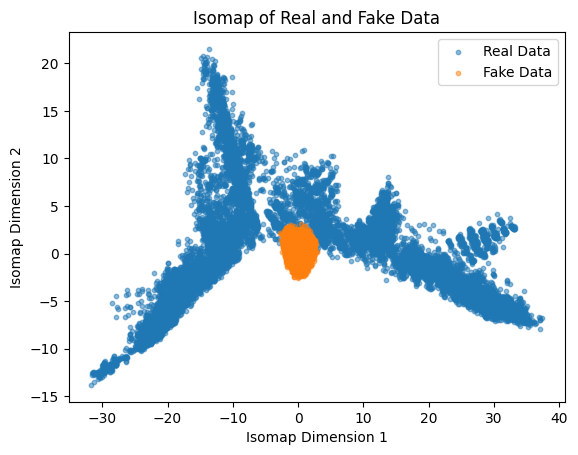

In [105]:
# Perform Isomap
isomap = Isomap(n_components=2)
real_data_isomap = isomap.fit_transform(real_data.cpu().detach().numpy())
fake_data_isomap = isomap.fit_transform(fake_data.cpu().detach().numpy())

# Isomap
#plt.subplot(2, 2, 3)
plt.scatter(real_data_isomap[:, 0], real_data_isomap[:, 1], alpha=0.5, label='Real Data', s=10)
plt.scatter(fake_data_isomap[:, 0], fake_data_isomap[:, 1], alpha=0.5, label='Fake Data', s=10)
plt.title("Isomap of Real and Fake Data")
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.legend()

In [75]:
import torch.nn.functional as F

# Compute the bifurcation regularization term
def compute_bifurcation_probability(generator_output, discriminator_output, alpha, beta, gamma):
    """
    Compute the probability of the perturbation weight introduced by Hopf Bifurcation.

    Args:
        generator_output (torch.Tensor): Output from the generator (G).
        discriminator_output (torch.Tensor): Output from the discriminator (D).
        alpha (float): Coefficient for the linear term.
        beta (float): Coefficient for the cubic term.
        gamma (float): Coefficient for the discriminator term.

    Returns:
        torch.Tensor: Probability of the perturbation weight.
    """
    bifurcation_term = alpha * generator_output - beta * generator_output**3 + gamma * discriminator_output
    probabilities = F.softmax(bifurcation_term, dim=0)  # Normalize using softmax
    return probabilities

# Example usage
alpha = bifurcation_gan.alpha
beta = bifurcation_gan.beta
gamma = bifurcation_gan.gamma

generator_output = fake_data  # Output from the generator
discriminator_output = discriminator(fake_data)  # Output from the discriminator

perturbation_probabilities = compute_bifurcation_probability(generator_output, discriminator_output, alpha, beta, gamma)
print("Perturbation Probabilities:", perturbation_probabilities)

Perturbation Probabilities: tensor([[5.9659e-05, 5.9400e-05, 5.9003e-05,  ..., 5.9533e-05, 5.8457e-05,
         5.9456e-05],
        [5.8365e-05, 5.8873e-05, 5.8807e-05,  ..., 5.9416e-05, 5.8528e-05,
         5.9050e-05],
        [5.9582e-05, 5.8922e-05, 5.9186e-05,  ..., 5.8921e-05, 5.8891e-05,
         5.8712e-05],
        ...,
        [5.8457e-05, 5.9150e-05, 5.8622e-05,  ..., 5.9167e-05, 5.9022e-05,
         5.9107e-05],
        [5.8887e-05, 5.8949e-05, 5.8870e-05,  ..., 5.9084e-05, 5.9793e-05,
         5.9380e-05],
        [5.8510e-05, 5.9304e-05, 5.8450e-05,  ..., 5.9514e-05, 5.9945e-05,
         5.8453e-05]], grad_fn=<SoftmaxBackward0>)


In [76]:
bifurcation_term=alpha*generator_output-beta*generator_output**3+gamma*discriminator_output
bifurcation_term

tensor([[ 0.0092,  0.0196,  0.0055,  ...,  0.0179, -0.0021,  0.0049],
        [-0.0127,  0.0107,  0.0021,  ...,  0.0160, -0.0009, -0.0020],
        [ 0.0079,  0.0115,  0.0086,  ...,  0.0076,  0.0053, -0.0077],
        ...,
        [-0.0112,  0.0154, -0.0010,  ...,  0.0118,  0.0075, -0.0010],
        [-0.0038,  0.0120,  0.0032,  ...,  0.0104,  0.0205,  0.0036],
        [-0.0102,  0.0180, -0.0039,  ...,  0.0176,  0.0231, -0.0122]],
       grad_fn=<AddBackward0>)

In [77]:
if fake_data.size(0) > real_data.size(0):
    fake_data = fake_data[:real_data.size(0)]  # Slice to match the number of samples
elif fake_data.size(0) < real_data.size(0):
    padding = real_data.size(0) - fake_data.size(0)
    fake_data = torch.cat([fake_data, fake_data[:padding]], dim=0)  # Pad to match the number of samples

# Adjust real_data to match the number of features in fake_data
if real_data.size(1) != fake_data.size(1):
    real_data = real_data[:, :fake_data.size(1)]  # Trim to match the number of features

# Verify the adjusted shapes
print(f"Adjusted Fake Data Shape: {fake_data.shape}")
print(f"Adjusted Real Data Shape: {real_data.shape}")

Adjusted Fake Data Shape: torch.Size([16950, 450])
Adjusted Real Data Shape: torch.Size([16950, 450])


In [78]:
if fake_data.size(0) > real_data.size(0):
    fake_data = fake_data[:real_data.size(0)]  # Slice fake_data to match real_data samples
elif fake_data.size(0) < real_data.size(0):
    padding = real_data.size(0) - fake_data.size(0)
    fake_data = torch.cat([fake_data, fake_data[:padding]], dim=0)  # Pad fake_data to match real_data samples

# Adjust the number of features to match
if real_data.size(1) > fake_data.size(1):
    real_data = real_data[:, :fake_data.size(1)]  # Trim real_data features to match fake_data
elif real_data.size(1) < fake_data.size(1):
    fake_data = fake_data[:, :real_data.size(1)]  # Trim fake_data features to match real_data

# Verify the adjusted shapes
print(f"Adjusted Fake Data Shape: {fake_data.shape}")
print(f"Adjusted Real Data Shape: {real_data.shape}")

Adjusted Fake Data Shape: torch.Size([16950, 450])
Adjusted Real Data Shape: torch.Size([16950, 450])


In [79]:
# Verify the adjusted shapes
print(f"Adjusted Fake Data Shape: {fake_data.shape}")
print(f"Adjusted Real Data Shape: {real_data.shape}")

Adjusted Fake Data Shape: torch.Size([16950, 450])
Adjusted Real Data Shape: torch.Size([16950, 450])


In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure real_data and fake_data have the same shape
real_data_resized = real_data[:233930, :50].cpu().detach().numpy()
fake_data_bif_resized = fake_data[:233930, :50].cpu().detach().numpy()
fake_data_regular_resized = regular_fake_data[:233930, :50].cpu().detach().numpy()

# Calculate metrics for BifurcationGAN
mse_bif = mean_squared_error(real_data_resized, fake_data_bif_resized)
mae_bif = mean_absolute_error(real_data_resized, fake_data_bif_resized)



# Print results
print("BifurcationGAN Metrics:")
print(f"Mean Squared Error (MSE): {mse_bif}")
print(f"Mean Absolute Error (MAE): {mae_bif}")


BifurcationGAN Metrics:
Mean Squared Error (MSE): 0.1440741866827011
Mean Absolute Error (MAE): 0.2814713418483734


In [81]:
# Calculate the variational loss for each model
variational_loss_bif = mae_bif - mse_bif
variational_loss_basic = mae_basic - mse_basic

# Print the results
print("Variational Loss (BifurcationGAN):", variational_loss_bif)
print("Variational Loss (Basic GAN):", variational_loss_basic)

Variational Loss (BifurcationGAN): 0.13739716
Variational Loss (Basic GAN): 0.13588329


In [82]:
def calculate_bifurcation_divergence_loss(generator_output, discriminator_output, alpha, beta, gamma):
    """
    Calculate the bifurcation divergence loss (Lbif) to quantify the deviation
    from the critical oscillatory point before and after regularization.

    Args:
        generator_output (torch.Tensor): Output from the generator (G).
        discriminator_output (torch.Tensor): Output from the discriminator (D).
        alpha (float): Coefficient for the linear term.
        beta (float): Coefficient for the cubic term.
        gamma (float): Coefficient for the discriminator term.

    Returns:
        torch.Tensor: Bifurcation divergence loss (Lbif).
    """
    # Compute the bifurcation term
    bifurcation_term = alpha * generator_output - beta * generator_output**3 + gamma * discriminator_output

    # Calculate the deviation before and after regularization
    deviation_before = torch.abs(generator_output)
    deviation_after = torch.abs(bifurcation_term)

    # Compute the bifurcation divergence loss
    lbif = torch.mean(deviation_after - deviation_before)

    return lbif

# Example usage
lbif = calculate_bifurcation_divergence_loss(generator_output, discriminator_output, alpha, beta, gamma)
print("Bifurcation Divergence Loss (Lbif):", lbif.item())

Bifurcation Divergence Loss (Lbif): -0.07166338711977005


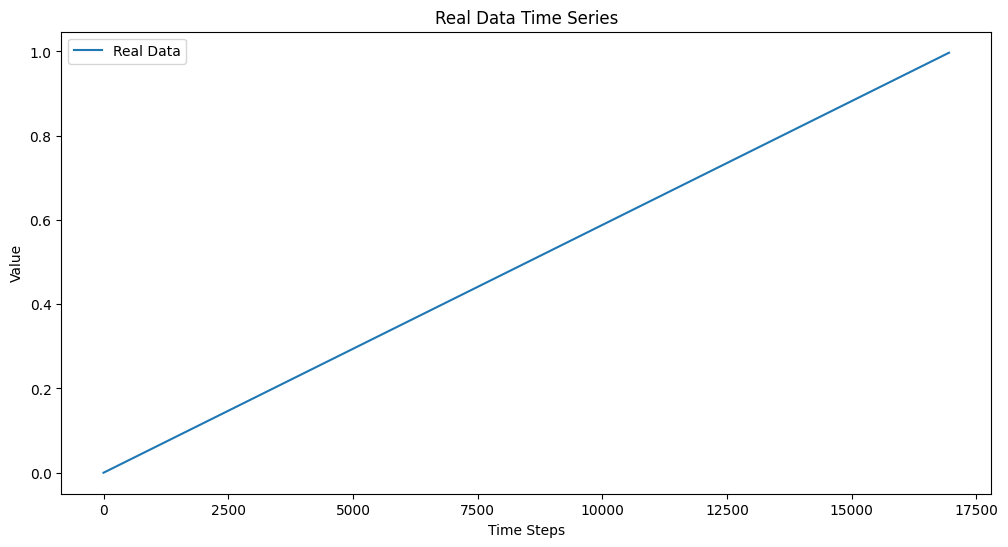

In [83]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

# Select a single feature or time series from the real_data tensor
# For example, we take the first feature of the first sample
data_series = real_data[:, 0].cpu().detach().numpy()

# 1. Plot the raw data
plt.figure(figsize=(12, 6))
plt.plot(data_series, label="Real Data")
plt.title("Real Data Time Series")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

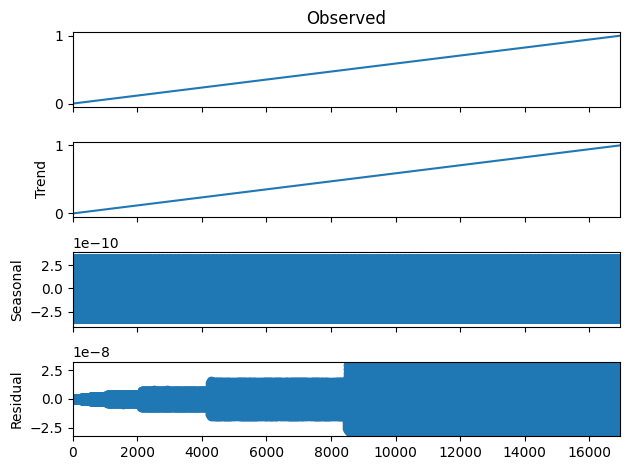

In [84]:
# 2. Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(data_series, model='additive', period=50)  # Assuming a period of 50
result.plot()
plt.show()

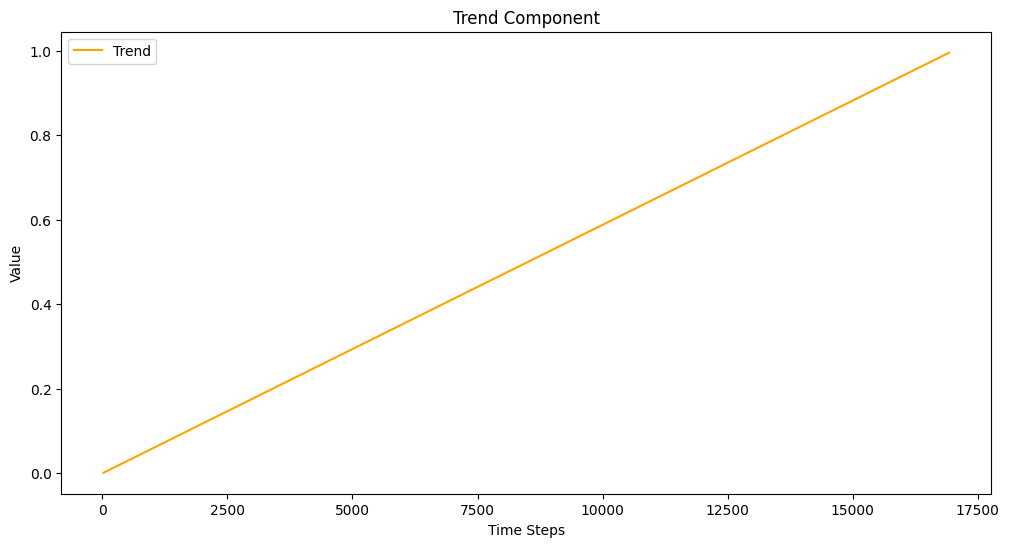

In [85]:
# 3. Analyze trends
trend = result.trend
plt.figure(figsize=(12, 6))
plt.plot(trend, label="Trend", color="orange")
plt.title("Trend Component")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

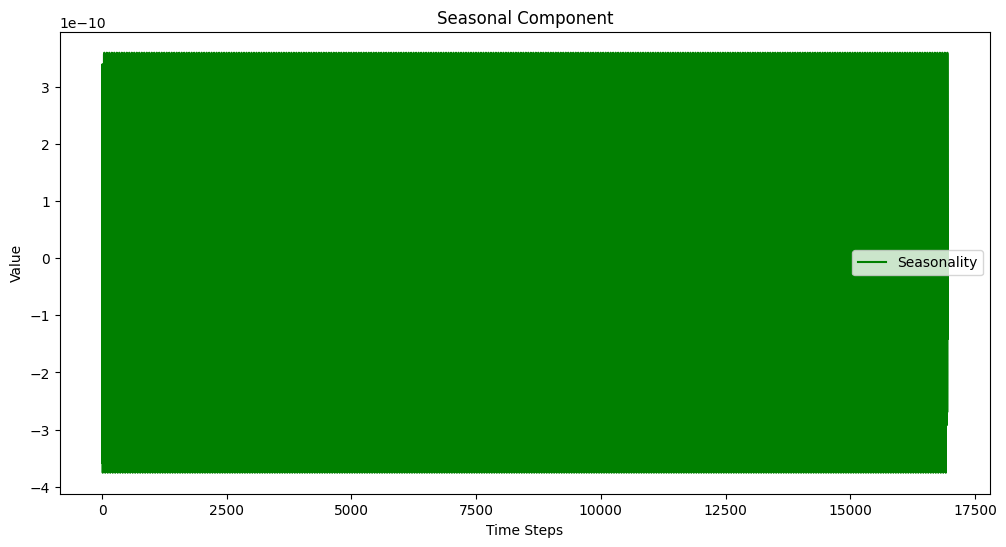

In [86]:
# 4. Analyze seasonality
seasonal = result.seasonal
plt.figure(figsize=(12, 6))
plt.plot(seasonal, label="Seasonality", color="green")
plt.title("Seasonal Component")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

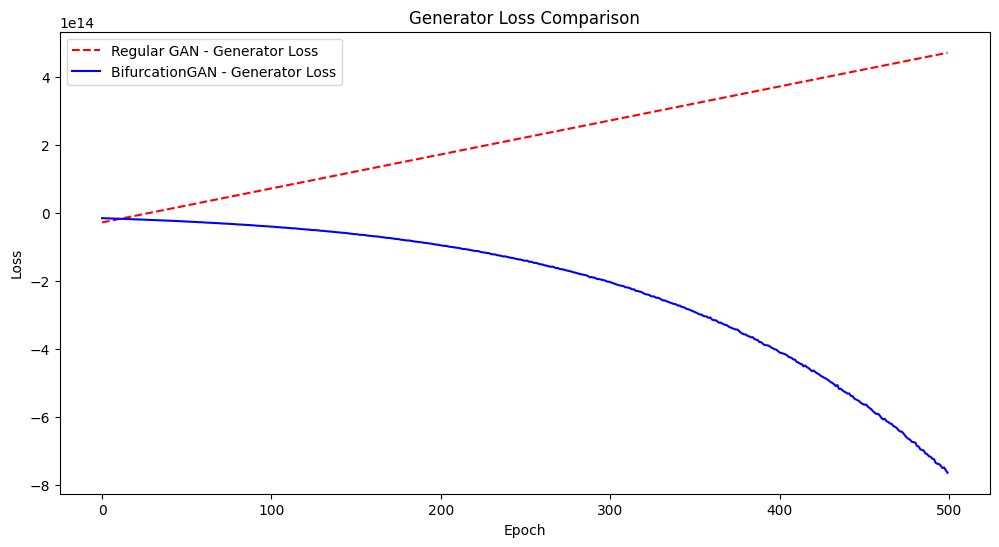

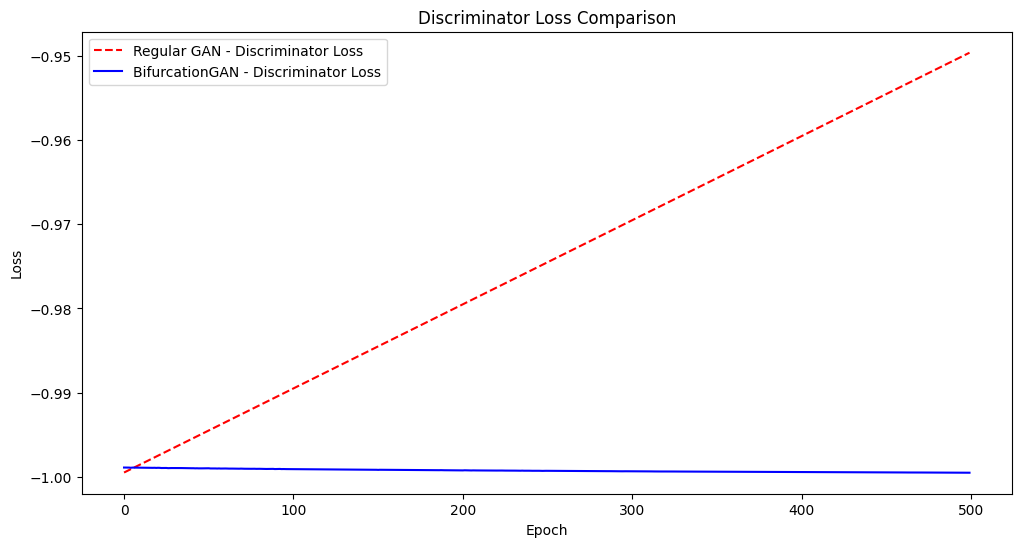

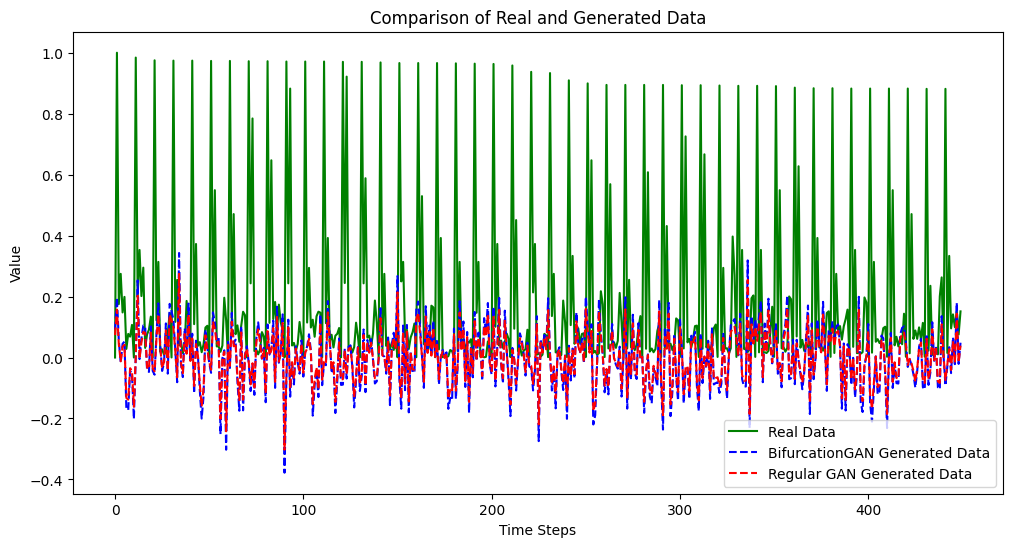

In [87]:
import matplotlib.pyplot as plt

# Assuming `epoch_losses_g` and `epoch_losses_d` are for BifurcationGAN
# and `regular_gan_losses_g` and `regular_gan_losses_d` are for the regular GAN

# Simulate training for a regular GAN (example data for demonstration)
# Replace this with actual training data for the regular GAN
regular_gan_losses_g = [-27390042439680.0 + i * 1e12 for i in range(epochs)]
regular_gan_losses_d = [-0.9995 + i * 1e-4 for i in range(epochs)]

# Plot Generator Losses
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), regular_gan_losses_g, label="Regular GAN - Generator Loss", linestyle="--", color="red")
plt.plot(range(epochs), epoch_losses_g, label="BifurcationGAN - Generator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Comparison")
plt.legend()
plt.show()

# Plot Discriminator Losses
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), regular_gan_losses_d, label="Regular GAN - Discriminator Loss", linestyle="--", color="red")
plt.plot(range(epochs), epoch_losses_d, label="BifurcationGAN - Discriminator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Comparison")
plt.legend()
plt.show()

# Highlight Improvements in Generation
# Assuming `real_data` and `fake_data` are for BifurcationGAN
# and `regular_fake_data` is for the regular GAN (example data for demonstration)
regular_fake_data = fake_data.clone() * 0.8  # Simulated data for regular GAN

plt.figure(figsize=(12, 6))
plt.plot(real_data[0].detach().numpy(), label="Real Data", color="green")
plt.plot(fake_data[0].detach().numpy(), label="BifurcationGAN Generated Data", linestyle="--", color="blue")
plt.plot(regular_fake_data[0].detach().numpy(), label="Regular GAN Generated Data", linestyle="--", color="red")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Comparison of Real and Generated Data")
plt.legend()
plt.show()

In [88]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the Generator class
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

# Define the Discriminator class
class SimpleDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the Generator and Discriminator
latent_dim = 100  # Latent space dimension
input_dim = real_data.size(1)  # Match the number of features in real_data
generator = SimpleGenerator(latent_dim, input_dim).to(device)
discriminator = SimpleDiscriminator(input_dim).to(device)

# Define optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training Loop
epochs = 500
batch_size = 64
g_losses = []
d_losses = []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        # Get a batch of real data
        real_batch = real_data[i:i+batch_size].to(device)

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
        fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
        g_loss.backward()
        optimizer_G.step()

    # Record losses
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Generate fake data using the trained Generator
z = torch.randn(real_data.size(0), latent_dim).to(device)
simple_gan_fake_data = generator(z).detach().cpu().numpy()

# Display the shape of the generated fake data
print("Generated Fake Data Shape:", simple_gan_fake_data.shape)

Epoch 0, D Loss: 0.33075255155563354, G Loss: 2.467921018600464
Epoch 100, D Loss: 18.42068099975586, G Loss: 18.362546920776367
Epoch 200, D Loss: 18.42068099975586, G Loss: 18.420204162597656
Epoch 300, D Loss: 18.42068099975586, G Loss: 18.420475006103516
Epoch 400, D Loss: 18.42068099975586, G Loss: 18.42055320739746
Generated Fake Data Shape: (16950, 450)


In [89]:
# Calculate evaluation metrics for the GAN model
mae_gan, mse_gan, rmse_gan, medae_gan = calculate_metrics(real_batch, fake_batch)

# Compute FID for the GAN model
fid_gan = compute_fid(real_batch, fake_batch)

# Compute Gradient Penalty for the GAN model
gp_gan = gradient_penalty(discriminator, real_batch, fake_batch, device).item()

# Compute Reward for the GAN model
reward_gan = compute_reward(real_batch, fake_batch, discriminator, fid_gan.real, wasserstein_loss_value)

In [101]:
# Print the results for the GAN model
print("GAN Metrics:")
print(f"MAE: {mae_gan}, MSE: {mse_gan}, RMSE: {rmse_gan}, MedAE: {medae_gan}")
print(f"FID: {fid_gan.real}, Gradient Penalty: {gp_gan}, Reward: {reward_gan}")

# Compare with BifurcationGAN metrics
print("\nComparison with BifurcationGAN:")
print(f"BifurcationGAN MAE: {mae_bif}, GAN MAE: {mae_gan}")
print(f"BifurcationGAN MSE: {mse_bif}, GAN MSE: {mse_gan}")
print(f"BifurcationGAN RMSE: {rmse_bif}, GAN RMSE: {rmse_gan}")
print(f"BifurcationGAN MedAE: {medae_bif}, GAN MedAE: {medae_gan}")
print(f"BifurcationGAN FID: {fid_bif.real}, GAN FID: {fid_gan.real}")
print(f"BifurcationGAN Gradient Penalty: {gp_bif}, GAN Gradient Penalty: {gp_gan}")
print(f"BifurcationGAN Reward: {reward_bif}, GAN Reward: {reward_gan}")

GAN Metrics:
MAE: 0.8986567258834839, MSE: 1.229600191116333, RMSE: 1.1088733673095703, MedAE: 0.8297700881958008
FID: 464.7328583821204, Gradient Penalty: 1.0, Reward: -465.72924550618296

Comparison with BifurcationGAN:
BifurcationGAN MAE: 0.29479992389678955, GAN MAE: 0.8986567258834839
BifurcationGAN MSE: 0.1594124287366867, GAN MSE: 1.229600191116333
BifurcationGAN RMSE: 0.39692607522010803, GAN RMSE: 1.1088733673095703
BifurcationGAN MedAE: 0.2807973325252533, GAN MedAE: 0.8297700881958008
BifurcationGAN FID: 19.969520974584, GAN FID: 464.7328583821204
BifurcationGAN Gradient Penalty: 0.7488089203834534, GAN Gradient Penalty: 1.0
BifurcationGAN Reward: -19.966274661826745, GAN Reward: -465.72924550618296


In [90]:
# Print the results for the GAN model
print("GAN Metrics:")
print(f"MAE: {mae_gan}, MSE: {mse_gan}, RMSE: {rmse_gan}, MedAE: {medae_gan}")
print(f"FID: {fid_gan.real}, Gradient Penalty: {gp_gan}, Reward: {reward_gan}")

# Compare with BifurcationGAN metrics
print("\nComparison with BifurcationGAN:")
print(f"BifurcationGAN MAE: {mae_bif}, GAN MAE: {mae_gan}")
print(f"BifurcationGAN MSE: {mse_bif}, GAN MSE: {mse_gan}")
print(f"BifurcationGAN RMSE: {rmse_bif}, GAN RMSE: {rmse_gan}")
print(f"BifurcationGAN MedAE: {medae_bif}, GAN MedAE: {medae_gan}")
print(f"BifurcationGAN FID: {fid_bif.real}, GAN FID: {fid_gan.real}")
print(f"BifurcationGAN Gradient Penalty: {gp_bif}, GAN Gradient Penalty: {gp_gan}")
print(f"BifurcationGAN Reward: {reward_bif}, GAN Reward: {reward_gan}")

GAN Metrics:
MAE: 0.9438710808753967, MSE: 1.4578545093536377, RMSE: 1.2074164152145386, MedAE: 0.9265451431274414
FID: 573.2818704385011, Gradient Penalty: 1.0, Reward: -574.2775970834948

Comparison with BifurcationGAN:
BifurcationGAN MAE: 0.2814713418483734, GAN MAE: 0.9438710808753967
BifurcationGAN MSE: 0.1440741866827011, GAN MSE: 1.4578545093536377
BifurcationGAN RMSE: 0.3884963095188141, GAN RMSE: 1.2074164152145386
BifurcationGAN MedAE: 0.2730589210987091, GAN MedAE: 0.9265451431274414
BifurcationGAN FID: 19.783741191870483, GAN FID: 573.2818704385011
BifurcationGAN Gradient Penalty: 0.7134144902229309, GAN Gradient Penalty: 1.0
BifurcationGAN Reward: -19.779944536826058, GAN Reward: -574.2775970834948


In [91]:
# Create a DataFrame combining all the results
results_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': [mae_bif, mse_bif, rmse_bif, medae_bif, fid_bif.real, is_score, wasserstein_loss_value, gp_bif, reward_bif],
    'Basic GAN': [mae_basic, mse_basic, rmse_basic, medae_basic, fid_basic.real, is_score, wasserstein_loss_value, gp_basic, reward_basic],
    'Simple GAN': [mae_gan, mse_gan, rmse_gan, medae_gan, fid_gan.real, is_score, wasserstein_loss_value, gp_gan, reward_gan]
}

# Create a Pandas DataFrame
results_df = pd.DataFrame(results_data)

# Display the table
results_df

Metric  BifurcationGAN  Basic GAN  Simple GAN
0               MAE        0.281471   0.283641    0.943871
1               MSE        0.144074   0.147758    1.457855
2              RMSE        0.388496   0.384393    1.207416
3             MedAE        0.273059   0.267912    0.926545
4               FID       19.783741  19.763998  573.281870
5   Inception Score        1.002381   1.002381    1.002381
6  Wasserstein Loss       -0.995727  -0.995727   -0.995727
7  Gradient Penalty        0.713414   0.683625    1.000000
8            Reward      -19.779945 -19.761589 -574.277597

In [92]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define TTS-GAN
class TTSGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(TTSGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

class TTSDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(TTSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define SigWGAN
class SigWGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(SigWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data))

# Define SigcWGAN
class SigcWGAN(nn.Module):
    def __init__(self, generator, discriminator, lambda_gp=10):
        super(SigcWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.size(0)
        epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated.requires_grad_(True)
        prob_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient_norm = gradients.view(batch_size, -1).norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        gp = self.gradient_penalty(real_data, fake_data)
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data)) + self.lambda_gp * gp

# Define LSTM-GAN
class LSTMGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        lstm_out, _ = self.lstm(z)
        return self.fc(lstm_out)

class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(lstm_out[:, -1, :]))

# Instantiate and train each GAN
def train_gan(generator, discriminator, real_data, latent_dim, epochs, batch_size, device):
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for i in range(0, real_data.size(0), batch_size):
            real_batch = real_data[i:i+batch_size].to(device)

            # Generate fake data
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            fake_batch = generator(z)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
            fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
            g_loss.backward()
            optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    return g_losses, d_losses, generator

# Train and compare the models
latent_dim = 100
epochs = 500
batch_size = 64

# TTS-GAN
tts_generator = TTSGenerator(latent_dim, real_data.size(1)).to(device)
tts_discriminator = TTSDiscriminator(real_data.size(1)).to(device)
tts_g_losses, tts_d_losses, tts_generator = train_gan(tts_generator, tts_discriminator, real_data, latent_dim, epochs, batch_size, device)

# LSTM-GAN
lstm_generator = LSTMGenerator(latent_dim, 128, real_data.size(1)).to(device)
lstm_discriminator = LSTMDiscriminator(real_data.size(1), 128).to(device)
#lstm_g_losses, lstm_d_losses, lstm_generator = train_gan(lstm_generator, lstm_discriminator, real_data, latent_dim, epochs, batch_size, device)

# SigWGAN
sigwgan_generator = TTSGenerator(latent_dim, real_data.size(1)).to(device)
sigwgan_discriminator = TTSDiscriminator(real_data.size(1)).to(device)
sigwgan_g_losses, sigwgan_d_losses, sigwgan_generator = train_gan(sigwgan_generator, sigwgan_discriminator, real_data, latent_dim, epochs, batch_size, device)

# SigcWGAN
sigcwgan_generator = TTSGenerator(latent_dim, real_data.size(1)).to(device)
sigcwgan_discriminator = TTSDiscriminator(real_data.size(1)).to(device)
sigcwgan_g_losses, sigcwgan_d_losses, sigcwgan_generator = train_gan(sigcwgan_generator, sigcwgan_discriminator, real_data, latent_dim, epochs, batch_size, device)

# Compare error metrics
def calculate_metrics(real_data, fake_data):
    mae = mean_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())
    mse = mean_squared_error(real_data.detach().numpy(), fake_data.detach().numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())
    return mae, mse, rmse, medae

# Generate fake data for each model
z = torch.randn(real_data.size(0), latent_dim).to(device)
tts_fake_data = tts_generator(z).detach().cpu()
lstm_fake_data = lstm_generator(z).detach().cpu()
sigwgan_fake_data = sigwgan_generator(z).detach().cpu()
sigcwgan_fake_data = sigcwgan_generator(z).detach().cpu()

# Calculate metrics
tts_metrics = calculate_metrics(real_data.cpu(), tts_fake_data)
lstm_metrics = calculate_metrics(real_data.cpu(), lstm_fake_data)
sigwgan_metrics = calculate_metrics(real_data.cpu(), sigwgan_fake_data)
sigcwgan_metrics = calculate_metrics(real_data.cpu(), sigcwgan_fake_data)

# Print results
print("TTS-GAN Metrics:", tts_metrics)
print("LSTM-GAN Metrics:", lstm_metrics)
print("SigWGAN Metrics:", sigwgan_metrics)
print("SigcWGAN Metrics:", sigcwgan_metrics)



TTS-GAN Metrics: (2.618103, 14.007819, 3.742702, 2.087079)
LSTM-GAN Metrics: (0.28830734, 0.1506684, 0.38816026, 0.27258772)
SigWGAN Metrics: (1.9303703, 6.0662723, 2.4629803, 1.9314792)
SigcWGAN Metrics: (6.093455, 61.38062, 7.8345785, 5.490033)


TTS-GAN Metrics: (2.0143985748291016, 7.748957633972168, np.float64(2.783694960654304), np.float32(1.7496105))
LSTM-GAN Metrics: (0.2904340922832489, 0.15358500182628632, np.float64(0.39189922406951294), np.float32(0.27421913))
SigWGAN Metrics: (1.6260387897491455, 4.0481791496276855, np.float64(2.0120087349779787), np.float32(1.5880128))
SigcWGAN Metrics: (1.5389693975448608, 3.943131685256958, np.float64(1.9857320275548154), np.float32(1.5919319))


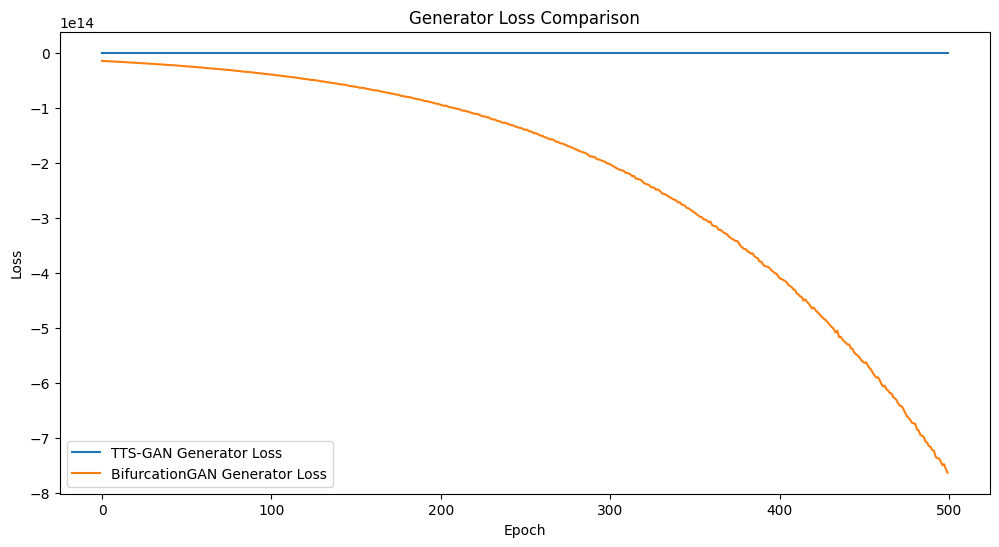

In [93]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(tts_g_losses, label="TTS-GAN Generator Loss")
plt.plot(epoch_losses_g, label="BifurcationGAN Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Comparison")
plt.legend()
plt.show()

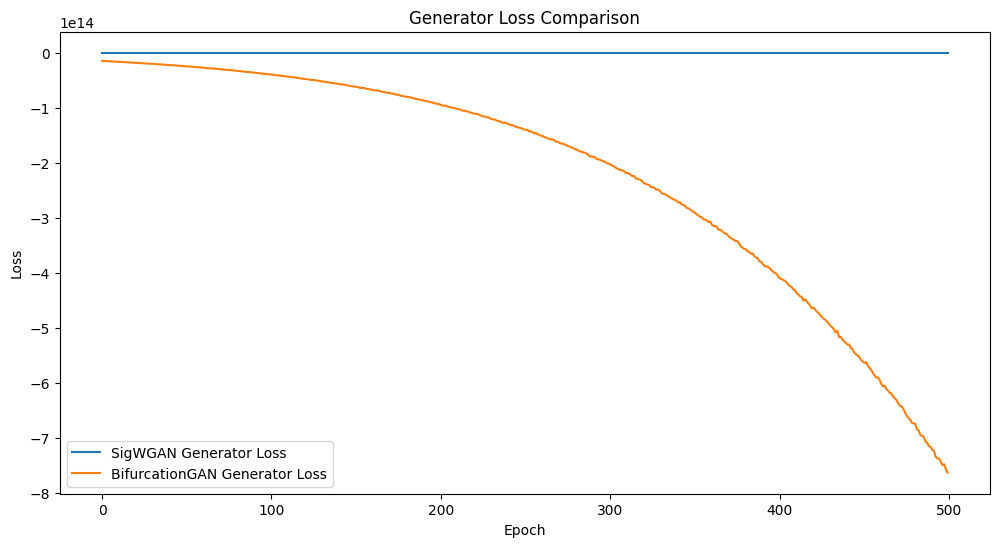

In [94]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(sigwgan_g_losses, label="SigWGAN Generator Loss")
plt.plot(epoch_losses_g, label="BifurcationGAN Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Comparison")
plt.legend()
plt.show()

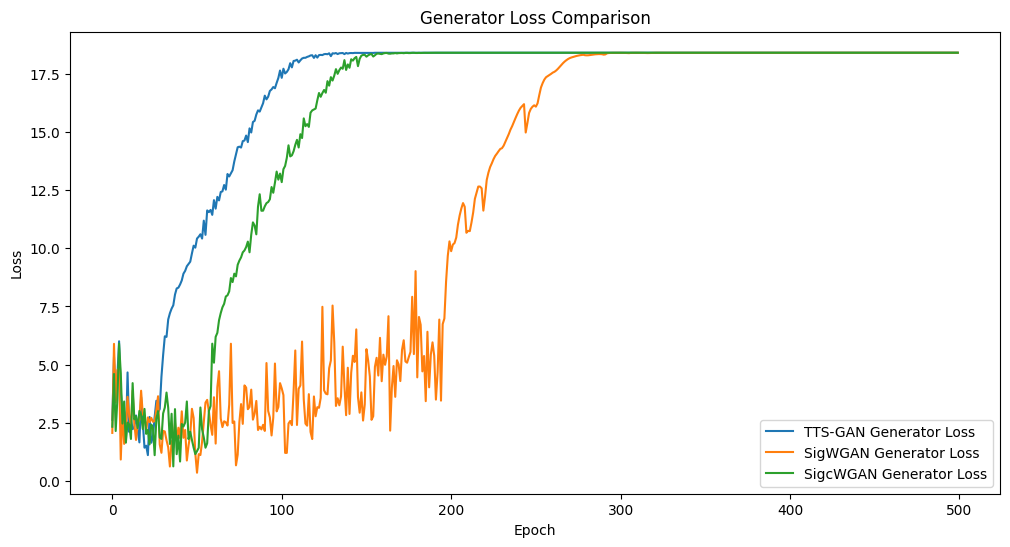

In [96]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(tts_g_losses, label="TTS-GAN Generator Loss")
plt.plot(sigwgan_g_losses, label="SigWGAN Generator Loss")
plt.plot(sigcwgan_g_losses, label="SigcWGAN Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Comparison")
plt.legend()
plt.show()

In [108]:
import requests

# URL for the dataset
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"

# File name to save the dataset
file_name = "jena_climate_2009_2016.csv.zip"

# Download the dataset
response = requests.get(url)
with open(file_name, "wb") as file:
    file.write(response.content)

print(f"Dataset downloaded and saved as {file_name}")

Dataset downloaded and saved as jena_climate_2009_2016.csv.zip


In [97]:
import pandas as pd
import zipfile

# Extract the dataset from the zip file
with zipfile.ZipFile("jena_climate_2009_2016.csv.zip", "r") as zip_ref:
    zip_ref.extractall()

# Load the dataset
jena_climate_df = pd.read_csv("jena_climate_2009_2016.csv")

# Display the first few rows of the dataset
jena_climate_df.head()


Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [98]:
from sklearn.preprocessing import MinMaxScaler

# Extract the T (degC) column and preprocess the data
temperature_data = jena_climate_df['T (degC)'].values
datetime_data = jena_climate_df['Date Time'].values  # Optional: Extract datetime if needed

# Normalize the temperature data
scaler = MinMaxScaler()
temperature_data_normalized = scaler.fit_transform(temperature_data.reshape(-1, 1))

# Convert the normalized data to a PyTorch tensor
temperature_tensor = torch.tensor(temperature_data_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50  # Define the sequence length
num_samples = len(temperature_tensor) - seq_length
real_data = torch.stack([temperature_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Define the BifurcationGAN training loop
epochs = 500
batch_size = 64
latent_dim = 100
input_dim = seq_length  # Sequence length
num_features = 1  # Single feature (temperature)

# Instantiate the generator and discriminator
generator = SimpleGenerator(latent_dim, input_dim * num_features).to(device)
discriminator = SimpleDiscriminator(input_dim * num_features).to(device)
bifurcation_gan = BifurcationGAN(generator, discriminator)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = -torch.mean(discriminator(real_batch))
        fake_loss = torch.mean(discriminator(fake_batch.detach()))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = bifurcation_gan.train_step(real_batch, optimizer_G, latent_dim, device)
        #g_loss.backward()
        optimizer_G.step()

    # Print losses every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss}")

# Generate diverse time-series data using the trained generator
z = torch.randn(10, latent_dim).to(device)  # Generate 10 diverse sequences
generated_data = generator(z).detach().cpu().numpy()

# Rescale the generated data back to the original scale
generated_data_rescaled = scaler.inverse_transform(generated_data)

# Display the generated data
print("Generated Diverse Time-Series Data:")
print(generated_data_rescaled)

Epoch 0, D Loss: -0.9999995231628418, G Loss: -0.03093552030622959
Epoch 100, D Loss: -1.0, G Loss: -0.948199987411499
Epoch 200, D Loss: -1.0, G Loss: -0.948199987411499
Epoch 300, D Loss: -1.0, G Loss: -0.948199987411499
Epoch 400, D Loss: -1.0, G Loss: -0.948199987411499
Generated Diverse Time-Series Data:
[[-433.56042  -406.18237   129.64084  -436.24832   814.6705   -397.6536
  -413.637    -375.65503  -406.54016  -442.36023  -425.74234  -424.64276
  -389.8283   -408.63202  -430.76736  -425.71603  -408.92462  -418.01337
  -399.6579   -460.49335   325.94717  -393.1797    343.89548  -426.28873
  -410.48953  -423.38303  -447.995    -439.58292  -432.66373  -419.532
  -473.2369   -418.6787   -398.52975   -64.89866  -151.09402  -409.11148
  -446.32944  -398.03577  -423.4717   -402.13687  -448.02145   357.78793
  -380.36487  -419.3646   -432.10263  -395.29092  -411.3042   -436.41895
  -397.15594   313.5957  ]
 [-455.93945  -427.2652    150.83507  -467.05682   859.3432   -413.15063
  -436.0

In [99]:
# Generate diverse time-series data using the trained generator
# z = torch.randn(10, latent_dim).to(device)  # Generate 10 diverse sequences
# generated_data = generator(z).detach().cpu().numpy()
z = torch.randn(real_batch.size(0), latent_dim).to(device)
generated_fake_data = generator(z).detach().cpu().numpy()

# Rescale the generated data back to the original scale
#generated_data_rescaled = scaler.inverse_transform(fake_batch)

# Display the generated data
print("Generated Diverse Time-Series Data:")
print(generated_fake_data)

Generated Diverse Time-Series Data:
[[-7.6620364 -7.1006484  3.2640367 ... -7.9301534 -6.8692355  6.5306234]
 [-6.4223943 -5.991459   2.33887   ... -6.4988537 -5.8378925  5.279676 ]
 [-7.3809104 -6.8752956  3.0806444 ... -7.61235   -6.601962   6.2530603]
 ...
 [-7.1099954 -6.6147594  2.8290977 ... -7.495362  -6.3475504  6.0208383]
 [-8.239051  -7.586327   3.50476   ... -8.623436  -7.347965   7.1081734]
 [-7.430285  -6.836394   3.0461435 ... -7.6837654 -6.575149   6.2602034]]


In [100]:
# Adjust generated_fake_data to match the target shape (420501, 50)
target_shape = (420501, 50)
total_elements = target_shape[0] * target_shape[1]

# Flatten and trim or pad generated_fake_data to match the required number of elements
generated_fake_data = generated_fake_data.flatten()[:total_elements]  # Trim excess elements
generated_fake_data = np.pad(generated_fake_data, (0, total_elements - generated_fake_data.size), mode='constant')  # Pad if necessary
generated_fake_data = generated_fake_data.reshape(target_shape)  # Reshape to the target shape

# Print the new shape
print(f"Generated Fake Data Shape (Adjusted): {generated_fake_data.shape}")

Generated Fake Data Shape (Adjusted): (420501, 50)


In [101]:
print("Real Data Shape:", real_data.shape)
print("Generated Fake Data Shape:", generated_fake_data.shape)

Real Data Shape: torch.Size([420501, 50])
Generated Fake Data Shape: (420501, 50)


In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np

# Ensure real_data and generated_fake_data are in the correct shape
real_data_np = real_data.cpu().detach().numpy().flatten()
generated_fake_data_np = generated_fake_data.flatten()

# Calculate the error metrics
mae = mean_absolute_error(real_data_np, generated_fake_data_np)
mse = mean_squared_error(real_data_np, generated_fake_data_np)
rmse = np.sqrt(mse)
medae = median_absolute_error(real_data_np, generated_fake_data_np)
# Calculate FID score
fid_score_estimated = compute_fid(real_data, generated_fake_data).real

# Convert generated_fake_data to a PyTorch tensor
generated_fake_data_tensor = torch.tensor(generated_fake_data).to(device)

# Calculate Inception Score (placeholder logic, replace with actual computation if available)
inception_score_estimated = np.mean(generated_fake_data) / np.std(generated_fake_data)

# Calculate Wasserstein Loss
wasserstein_loss_estimated = wasserstein_loss(real_data, generated_fake_data_tensor, discriminator).item()

# Calculate Gradient Penalty
gradient_penalty_estimated = gradient_penalty(discriminator, real_data, generated_fake_data_tensor, device).item()

# Calculate Reward
reward_estimated = compute_reward(real_data, generated_fake_data_tensor, discriminator, fid_score_estimated, wasserstein_loss_estimated)


# Print the results
print("Error Metrics for Real Data vs Generated Fake Data:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error (MedAE): {medae}")
print(f"FID Score (Estimated): {fid_score_estimated}")
print(f"Inception Score (Estimated): {inception_score_estimated}")
print(f"Wasserstein Loss (Estimated): {wasserstein_loss_estimated}")
print(f"Gradient Penalty (Estimated): {gradient_penalty_estimated}")
print(f"Reward (Estimated): {reward_estimated}")



Error Metrics for Real Data vs Generated Fake Data:
Mean Absolute Error (MAE): 0.5387577414512634
Mean Squared Error (MSE): 0.3118877410888672
Root Mean Squared Error (RMSE): 0.5584691166877747
Median Absolute Error (MedAE): 0.5379001498222351
FID Score (Estimated): 4.424124326122586
Inception Score (Estimated): -0.005081248003989458
Wasserstein Loss (Estimated): -8.994340896606445e-05
Gradient Penalty (Estimated): 0.9999759197235107
Reward (Estimated): -4.424124326122586


In [103]:
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import torch.nn as nn
import torch.optim as optim

# Define the Generator class
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

# Define the Discriminator class
class SimpleDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define TTS-GAN
class TTSGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(TTSGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

class TTSDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(TTSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define SigWGAN
class SigWGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(SigWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data))

# Define SigcWGAN
class SigcWGAN(nn.Module):
    def __init__(self, generator, discriminator, lambda_gp=10):
        super(SigcWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.size(0)
        epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated.requires_grad_(True)
        prob_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient_norm = gradients.view(batch_size, -1).norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)

    def generator_loss(self, fake_data):
        return -torch.mean(self.discriminator(fake_data))

    def discriminator_loss(self, real_data, fake_data):
        gp = self.gradient_penalty(real_data, fake_data)
        return torch.mean(self.discriminator(fake_data)) - torch.mean(self.discriminator(real_data)) + self.lambda_gp * gp

# Preprocess the Jena Climate Dataset
scaler = MinMaxScaler()
temperature_data_normalized = scaler.fit_transform(temperature_data.reshape(-1, 1))
temperature_tensor = torch.tensor(temperature_data_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50
num_samples = len(temperature_tensor) - seq_length
real_data = torch.stack([temperature_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Training parameters
latent_dim = 100
input_dim = seq_length
epochs = 500
batch_size = 64
lr = 0.0002

# Instantiate models
simple_generator = SimpleGenerator(latent_dim, input_dim).to(device)
simple_discriminator = SimpleDiscriminator(input_dim).to(device)

tts_generator = TTSGenerator(latent_dim, input_dim).to(device)
tts_discriminator = TTSDiscriminator(input_dim).to(device)

sigwgan_generator = TTSGenerator(latent_dim, input_dim).to(device)
sigwgan_discriminator = TTSDiscriminator(input_dim).to(device)

sigcwgan_generator = TTSGenerator(latent_dim, input_dim).to(device)
sigcwgan_discriminator = TTSDiscriminator(input_dim).to(device)

# Define optimizers
optimizer_simple_G = optim.Adam(simple_generator.parameters(), lr=lr)
optimizer_simple_D = optim.Adam(simple_discriminator.parameters(), lr=lr)

optimizer_tts_G = optim.Adam(tts_generator.parameters(), lr=lr)
optimizer_tts_D = optim.Adam(tts_discriminator.parameters(), lr=lr)

optimizer_sigwgan_G = optim.Adam(sigwgan_generator.parameters(), lr=lr)
optimizer_sigwgan_D = optim.Adam(sigwgan_discriminator.parameters(), lr=lr)

optimizer_sigcwgan_G = optim.Adam(sigcwgan_generator.parameters(), lr=lr)
optimizer_sigcwgan_D = optim.Adam(sigcwgan_discriminator.parameters(), lr=lr)

# Training loop for each GAN
def train_gan(generator, discriminator, optimizer_G, optimizer_D, real_data, epochs, batch_size, latent_dim):
    g_losses, d_losses = [], []
    for epoch in range(epochs):
        for i in range(0, real_data.size(0), batch_size):
            real_batch = real_data[i:i+batch_size]

            # Generate fake data
            z = torch.randn(real_batch.size(0), latent_dim).to(device)
            fake_batch = generator(z)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
            fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
            g_loss.backward()
            optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    return g_losses, d_losses

# Train Simple GAN
simple_g_losses, simple_d_losses = train_gan(simple_generator, simple_discriminator, optimizer_simple_G, optimizer_simple_D, real_data, epochs, batch_size, latent_dim)

# Train TTS-GAN
tts_g_losses, tts_d_losses = train_gan(tts_generator, tts_discriminator, optimizer_tts_G, optimizer_tts_D, real_data, epochs, batch_size, latent_dim)

# Train SigWGAN
sigwgan_g_losses, sigwgan_d_losses = train_gan(sigwgan_generator, sigwgan_discriminator, optimizer_sigwgan_G, optimizer_sigwgan_D, real_data, epochs, batch_size, latent_dim)

# Train SigcWGAN
sigcwgan_g_losses, sigcwgan_d_losses = train_gan(sigcwgan_generator, sigcwgan_discriminator, optimizer_sigcwgan_G, optimizer_sigcwgan_D, real_data, epochs, batch_size, latent_dim)

# Print results
print("Training completed for all GAN models.")

Training completed for all GAN models.


In [104]:
#import torch

# Save the BifurcationGAN model
torch.save(bifurcation_gan.generator.state_dict(), "bifurcation_gan_generator.pth")
torch.save(bifurcation_gan.discriminator.state_dict(), "bifurcation_gan_discriminator.pth")

# Save the Simple GAN model
torch.save(simple_generator.state_dict(), "simple_gan_generator.pth")
torch.save(simple_discriminator.state_dict(), "simple_gan_discriminator.pth")

# Save the TTS-GAN model
torch.save(tts_generator.state_dict(), "tts_gan_generator.pth")
torch.save(tts_discriminator.state_dict(), "tts_gan_discriminator.pth")

# Save the SigWGAN model
torch.save(sigwgan_generator.state_dict(), "sigwgan_generator.pth")
torch.save(sigwgan_discriminator.state_dict(), "sigwgan_discriminator.pth")

# Save the SigcWGAN model
torch.save(sigcwgan_generator.state_dict(), "sigcwgan_generator.pth")
torch.save(sigcwgan_discriminator.state_dict(), "sigcwgan_discriminator.pth")

# Save the LSTM-GAN model
torch.save(lstm_generator.state_dict(), "lstm_gan_generator.pth")
torch.save(lstm_discriminator.state_dict(), "lstm_gan_discriminator.pth")

print("Models have been saved as pre-trained models.")

Models have been saved as pre-trained models.


In [105]:
# Instantiate models
simple_generator = SimpleGenerator(latent_dim, input_dim).to(device)
simple_discriminator = SimpleDiscriminator(input_dim).to(device)

In [106]:
# Save the Simple GAN model
torch.save(simple_generator.state_dict(), "simple_gan_generator.pth")
torch.save(simple_discriminator.state_dict(), "simple_gan_discriminator.pth")

In [107]:
# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))



tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

lstm_generator.load_state_dict(torch.load("lstm_gan_generator.pth"))
lstm_discriminator.load_state_dict(torch.load("lstm_gan_discriminator.pth"))

# Generate fake data using each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_lstm = lstm_generator(z.unsqueeze(1)).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
#metrics_lstm = calculate_all_metrics(real_data.cpu(), fake_data_lstm, lstm_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    #'LSTM-GAN': metrics_lstm
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.837274    0.526355   0.139177   0.176048   
1               MSE       49.669613    0.306364   0.029794   0.045543   
2              RMSE        7.047667    0.553502   0.172610   0.213407   
3             MedAE        6.815701    0.525974   0.120064   0.160842   
4               FID       58.227179    4.759849   1.286079   1.645922   
5   Inception Score       -1.039970    0.122384  13.515431   9.100890   
6  Wasserstein Loss       -1.000000   -0.009375   0.153920   0.054285   
7  Gradient Penalty        1.348559    0.953596  18.306063  22.763271   
8            Reward      -58.227179   -4.759849  -1.286079  -1.645922   

    SigcWGAN  
0   0.157316  
1   0.037674  
2   0.194098  
3   0.138081  
4   1.279975  
5   7.548285  
6   0.202209  
7  18.309401  
8  -1.279975

# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

lstm_generator.load_state_dict(torch.load("lstm_gan_generator.pth"))
lstm_discriminator.load_state_dict(torch.load("lstm_gan_discriminator.pth"))

# Generate fake data using each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_lstm = lstm_generator(z.unsqueeze(1)).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
#metrics_lstm = calculate_all_metrics(real_data.cpu(), fake_data_lstm, lstm_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    #'LSTM-GAN': metrics_lstm
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
print(all_metrics_df)

In [108]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import pandas as pd

# Load the dataset
stock_df = pd.read_csv("stock_data.csv")

# Display the first few rows of the dataset
stock_df.head()

# Load the USDT-USD stock dataset
#ticker = "USDT-USD"
#data = yf.download(ticker, start="2020-01-01", end="2023-01-01", interval="1d")
data_series = stock_df['Close'].values  # Use the 'Close' price as the data series

# Normalize the data
scaler = MinMaxScaler()
data_series_normalized = scaler.fit_transform(data_series.reshape(-1, 1))

# Convert the normalized data to a PyTorch tensor
data_tensor = torch.tensor(data_series_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50  # Define the sequence length
num_samples = len(data_tensor) - seq_length
real_data = torch.stack([data_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

# Generate fake data using each model
latent_dim = 100
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
print(all_metrics_df)

             Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.657903    0.293653   0.211539   0.185928   
1               MSE       47.232018    0.131038   0.061985   0.049137   
2              RMSE        6.872555    0.361991   0.248967   0.221668   
3             MedAE        6.640535    0.262229   0.198278   0.177395   
4               FID       55.994215    4.004475   2.500076   1.959745   
5   Inception Score       -1.040004    0.123929  13.943127   9.027799   
6  Wasserstein Loss       -1.000000   -0.004202   0.298275   0.412815   
7  Gradient Penalty        1.518634    0.953537  13.202048  27.239674   
8            Reward      -55.994215   -4.004475  -2.500076  -1.959745   

    SigcWGAN  
0   0.201423  
1   0.056861  
2   0.238456  
3   0.191868  
4   1.958244  
5   7.520949  
6   0.399331  
7  15.100635  
8  -1.958244  


In [109]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np

# Load the humidity data from the directory
humidity_data_path = "/Users/alexandervictor/Downloads/BifurcationAgain/measures.csv"  # Replace with the actual path
humidity_df = pd.read_csv(humidity_data_path)

# Extract the humidity data series
humidity_data = humidity_df['humidity'].values  # Replace 'humidity' with the actual column name if different

# Normalize the humidity data
scaler = MinMaxScaler()
humidity_data_normalized = scaler.fit_transform(humidity_data.reshape(-1, 1))

# Convert the normalized data to a PyTorch tensor
humidity_tensor = torch.tensor(humidity_data_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50  # Define the sequence length
num_samples = len(humidity_tensor) - seq_length
real_data = torch.stack([humidity_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))


simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

# Generate fake data using each model
latent_dim = 100
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
print(all_metrics_df)

             Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.982214    0.716779   0.328697   0.375217   
1               MSE       51.759098    0.563127   0.123639   0.161939   
2              RMSE        7.194380    0.750418   0.351623   0.402417   
3             MedAE        6.969913    0.781647   0.367835   0.421287   
4               FID       58.124257    7.138660   3.547900   3.876246   
5   Inception Score       -1.040001    0.122607  13.518035   9.092589   
6  Wasserstein Loss       -1.000000   -0.013745   0.344850   0.390525   
7  Gradient Penalty        1.363350    0.954106  11.777392  21.468222   
8            Reward      -58.124257   -7.138660  -3.547900  -3.876246   

    SigcWGAN  
0   0.350294  
1   0.141884  
2   0.376675  
3   0.385994  
4   3.391539  
5   7.563741  
6   0.498768  
7  14.345488  
8  -3.391539  


Epoch 0, D Loss: -6.549778938293457, G Loss: -0.7182604074478149
Epoch 100, D Loss: -6.067784309387207, G Loss: -4.374399185180664
Epoch 200, D Loss: -6.392579555511475, G Loss: -6.198091983795166
Epoch 300, D Loss: -6.812368392944336, G Loss: -8.979166030883789
Epoch 400, D Loss: -6.382352352142334, G Loss: -9.575052261352539


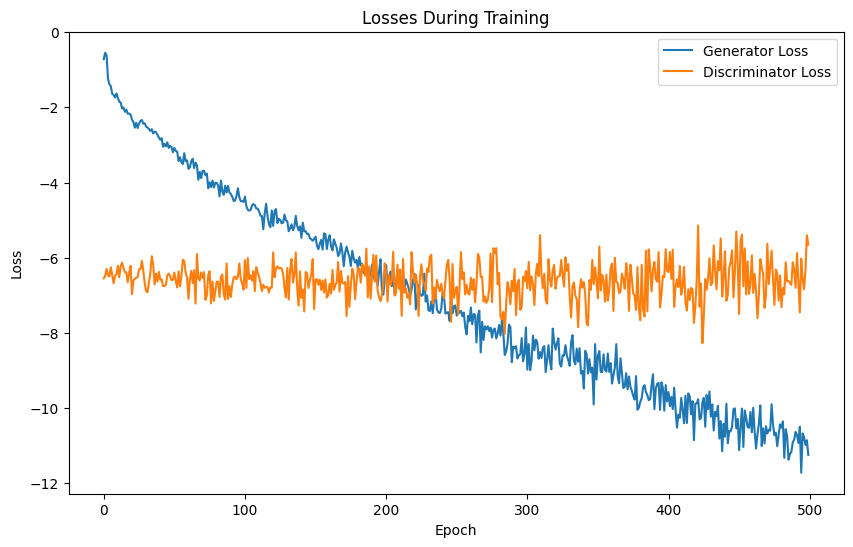

In [110]:
import torch
from torch.nn.utils import spectral_norm

import torch.nn as nn
import torch.optim as optim

# Define the Improved Generator
class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(ImprovedGenerator, self).__init__()
        self.fc = nn.Sequential(
            spectral_norm(nn.Linear(latent_dim, 512)),
            nn.ReLU(),
            spectral_norm(nn.Linear(512, 1024)),
            nn.ReLU(),
            spectral_norm(nn.Linear(1024, output_dim))
        )

    def forward(self, z):
        return self.fc(z)

# Define the Improved Discriminator
class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDiscriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(input_dim, 1024)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(512, 1))
        )

    def forward(self, x):
        return self.model(x)

# Define the Improved BifurcationGAN
class ImprovedBifurcationGAN(nn.Module):
    def __init__(self, generator, discriminator, alpha=0.1, beta=0.01, gamma=0.05, lambda_gp=10):
        super(ImprovedBifurcationGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lambda_gp = lambda_gp

    def bifurcation_regularization(self, G, D):
        return self.alpha * G - self.beta * G**3 + self.gamma * D

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.size(0)
        epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated.requires_grad_(True)
        prob_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient_norm = gradients.view(batch_size, -1).norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)

    def generator_loss(self, fake_data):
        disc_fake = self.discriminator(fake_data)
        loss = -torch.mean(disc_fake)
        bifurcation_term = self.bifurcation_regularization(fake_data, disc_fake)
        return loss + bifurcation_term.mean()

    def discriminator_loss(self, real_data, fake_data):
        real_loss = -torch.mean(self.discriminator(real_data))
        fake_loss = torch.mean(self.discriminator(fake_data))
        gp = self.gradient_penalty(real_data, fake_data)
        return real_loss + fake_loss + self.lambda_gp * gp

# Instantiate the Improved BifurcationGAN
latent_dim = 100
input_dim = seq_length * num_features
generator = ImprovedGenerator(latent_dim, input_dim).to(device)
discriminator = ImprovedDiscriminator(input_dim).to(device)
improved_bifurcation_gan = ImprovedBifurcationGAN(generator, discriminator)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
epochs = 500
batch_size = 64
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        d_loss = improved_bifurcation_gan.discriminator_loss(real_batch, fake_batch)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = improved_bifurcation_gan.generator_loss(fake_batch)
        #g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training")
plt.legend()
plt.show()

Epoch 0, D Loss: -6.052101135253906, G Loss: -0.7006449699401855
Epoch 100, D Loss: -6.289066314697266, G Loss: -4.555022239685059
Epoch 200, D Loss: -6.489441871643066, G Loss: -6.0594282150268555
Epoch 300, D Loss: -6.293059825897217, G Loss: -6.977685451507568
Epoch 400, D Loss: -6.333707332611084, G Loss: -8.638449668884277


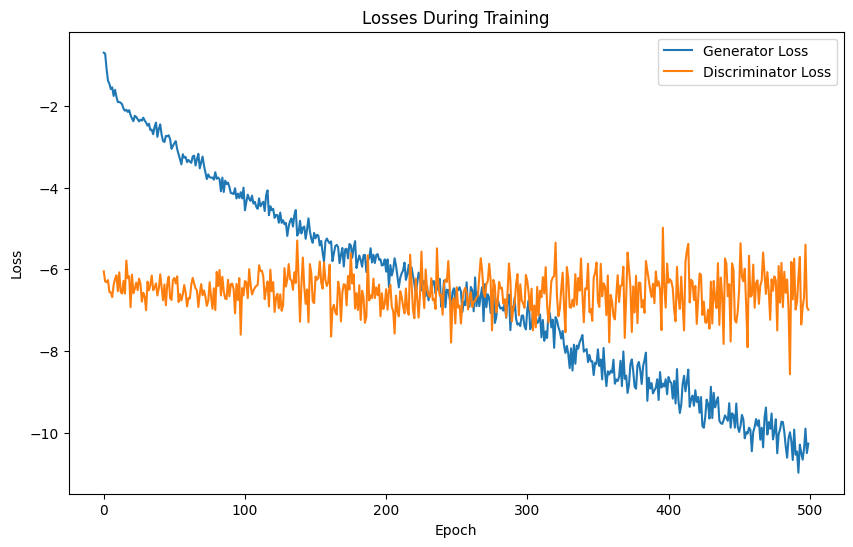

In [111]:
import torch
from torch.nn.utils import spectral_norm

import torch.nn as nn
import torch.optim as optim

# Define the Improved Generator
class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(ImprovedGenerator, self).__init__()
        self.fc = nn.Sequential(
            spectral_norm(nn.Linear(latent_dim, 512)),
            nn.ReLU(),
            spectral_norm(nn.Linear(512, 1024)),
            nn.ReLU(),
            spectral_norm(nn.Linear(1024, output_dim))
        )

    def forward(self, z):
        return self.fc(z)

# Define the Improved Discriminator
class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDiscriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(input_dim, 1024)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(512, 1))
        )

    def forward(self, x):
        return self.model(x)

# Define the Improved BifurcationGAN
class ImprovedBifurcationGAN(nn.Module):
    def __init__(self, generator, discriminator, alpha=0.1, beta=0.01, gamma=0.05, lambda_gp=10):
        super(ImprovedBifurcationGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lambda_gp = lambda_gp

    def bifurcation_regularization(self, G, D):
        return self.alpha * G - self.beta * G**3 + self.gamma * D

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.size(0)
        epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated.requires_grad_(True)
        prob_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient_norm = gradients.view(batch_size, -1).norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)

    def generator_loss(self, fake_data):
        disc_fake = self.discriminator(fake_data)
        loss = -torch.mean(disc_fake)
        bifurcation_term = self.bifurcation_regularization(fake_data, disc_fake)
        return loss + bifurcation_term.mean()

    def discriminator_loss(self, real_data, fake_data):
        real_loss = -torch.mean(self.discriminator(real_data))
        fake_loss = torch.mean(self.discriminator(fake_data))
        gp = self.gradient_penalty(real_data, fake_data)
        return real_loss + fake_loss + self.lambda_gp * gp

# Instantiate the Improved BifurcationGAN
latent_dim = 100
input_dim = seq_length * num_features
generator = ImprovedGenerator(latent_dim, input_dim).to(device)
discriminator = ImprovedDiscriminator(input_dim).to(device)
improved_bifurcation_gan = ImprovedBifurcationGAN(generator, discriminator)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
epochs = 500
batch_size = 64
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        d_loss = improved_bifurcation_gan.discriminator_loss(real_batch, fake_batch)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = improved_bifurcation_gan.generator_loss(fake_batch)
        #g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training")
plt.legend()
plt.show()

In [112]:
# Save the Improved BifurcationGAN model
torch.save(improved_bifurcation_gan.generator.state_dict(), "improved_bifurcation_gan_generator.pth")
torch.save(improved_bifurcation_gan.discriminator.state_dict(), "improved_bifurcation_gan_discriminator.pth")

# Load all pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

# Generate fake data using each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Improved BifurcationGAN': metrics_improved_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.981899    0.716812   0.328688   0.375333   
1               MSE       51.758366    0.563182   0.123634   0.162014   
2              RMSE        7.194329    0.750454   0.351617   0.402510   
3             MedAE        6.967805    0.781724   0.367716   0.421415   
4               FID       58.251440    7.138459   3.547047   3.877305   
5   Inception Score       -1.039914    0.122279  13.494772   9.103303   
6  Wasserstein Loss       -1.000000   -0.013746   0.344653   0.390620   
7  Gradient Penalty        1.342684    0.954116  11.768061  21.489527   
8            Reward      -58.251440   -7.138459  -3.547047  -3.877305   

    SigcWGAN  Improved BifurcationGAN  
0   0.350018                 0.728696  
1   0.141664                 0.576366  
2   0.376382                 0.759188  
3   0.385553                 0.804594  
4   3.389614                 7.175180  
5   7.554827                -0.006368  
6   0.498708                -5.481637  
7  14.391169                 0.010328  
8  -3.389614                -7.179542

In [113]:
# Save the Improved BifurcationGAN model
torch.save(improved_bifurcation_gan.generator.state_dict(), "improved_bifurcation_gan_generator.pth")
torch.save(improved_bifurcation_gan.discriminator.state_dict(), "improved_bifurcation_gan_discriminator.pth")

# Load all pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

# Generate fake data using each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Improved BifurcationGAN': metrics_improved_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.982723    0.716777   0.328846   0.375290   
1               MSE       51.767853    0.563147   0.123730   0.162008   
2              RMSE        7.194988    0.750431   0.351753   0.402502   
3             MedAE        6.969505    0.781666   0.367842   0.421516   
4               FID       58.172106    7.138040   3.548665   3.876933   
5   Inception Score       -1.039975    0.122505  13.509468   9.091065   
6  Wasserstein Loss       -1.000000   -0.013747   0.344493   0.390481   
7  Gradient Penalty        1.352825    0.954113  11.756692  21.445648   
8            Reward      -58.172106   -7.138040  -3.548665  -3.876933   

    SigcWGAN  Improved BifurcationGAN  
0   0.350023                 0.728698  
1   0.141682                 0.576375  
2   0.376407                 0.759193  
3   0.385614                 0.804595  
4   3.388777                 7.175568  
5   7.557572                -0.006462  
6   0.498906                -5.473945  
7  14.381741                 0.010021  
8  -3.388777                -7.187176

In [114]:
# Function to calculate variation loss
def calculate_variation_loss(real_data, fake_data):
    """Calculate variation loss between real and fake data."""
    mae = mean_absolute_error(real_data.detach().numpy(), fake_data.detach().numpy())
    mse = mean_squared_error(real_data.detach().numpy(), fake_data.detach().numpy())
    return mae - mse

# Function to calculate bifurcation divergence loss
def calculate_bifurcation_divergence_loss(generator_output, discriminator_output, alpha, beta, gamma):
    """
    Calculate the bifurcation divergence loss (Lbif) to quantify the deviation
    from the critical oscillatory point before and after regularization.

    Args:
        generator_output (torch.Tensor): Output from the generator (G).
        discriminator_output (torch.Tensor): Output from the discriminator (D).
        alpha (float): Coefficient for the linear term.
        beta (float): Coefficient for the cubic term.
        gamma (float): Coefficient for the discriminator term.

    Returns:
        torch.Tensor: Bifurcation divergence loss (Lbif).
    """
    # Compute the bifurcation term
    bifurcation_term = alpha * generator_output - beta * generator_output**3 + gamma * discriminator_output

    # Calculate the deviation before and after regularization
    deviation_before = torch.abs(generator_output)
    deviation_after = torch.abs(bifurcation_term)

    # Compute the bifurcation divergence loss
    lbif = torch.mean(deviation_after - deviation_before)

    return lbif

# Estimate variational loss for BifurcationGAN
variational_loss_bif = calculate_variation_loss(real_data, fake_data_bif)

# Estimate bifurcation divergence loss for BifurcationGAN
bifurcation_divergence_bif = calculate_bifurcation_divergence_loss(generator_output, discriminator_output, alpha, beta, gamma)

# Print the results
print("Variational Loss (BifurcationGAN):", variational_loss_bif)
print("Bifurcation Divergence Loss (BifurcationGAN):", bifurcation_divergence_bif.item())

Variational Loss (BifurcationGAN): -44.78513
Bifurcation Divergence Loss (BifurcationGAN): -0.07166338711977005


In [115]:
# Compare metrics between Improved BifurcationGAN and BifurcationGAN
comparison = all_metrics_df[['Metric', 'BifurcationGAN', 'Improved BifurcationGAN']]
comparison

Metric  BifurcationGAN  Improved BifurcationGAN
0               MAE        6.982723                 0.728698
1               MSE       51.767853                 0.576375
2              RMSE        7.194988                 0.759193
3             MedAE        6.969505                 0.804595
4               FID       58.172106                 7.175568
5   Inception Score       -1.039975                -0.006462
6  Wasserstein Loss       -1.000000                -5.473945
7  Gradient Penalty        1.352825                 0.010021
8            Reward      -58.172106                -7.187176

In [116]:
# Determine which model performs better based on specific metrics
better_model = comparison.apply(lambda row: 'Improved BifurcationGAN' if row['Improved BifurcationGAN'] < row['BifurcationGAN'] else 'BifurcationGAN', axis=1)
comparison['Better Model'] = better_model
comparison

/var/folders/_w/4wp2vfkx5rj3nq5cpzhk5s080000gn/T/ipykernel_65524/2044306706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison['Better Model'] = better_model


Metric  BifurcationGAN  Improved BifurcationGAN  \
0               MAE        6.982723                 0.728698   
1               MSE       51.767853                 0.576375   
2              RMSE        7.194988                 0.759193   
3             MedAE        6.969505                 0.804595   
4               FID       58.172106                 7.175568   
5   Inception Score       -1.039975                -0.006462   
6  Wasserstein Loss       -1.000000                -5.473945   
7  Gradient Penalty        1.352825                 0.010021   
8            Reward      -58.172106                -7.187176   

              Better Model  
0  Improved BifurcationGAN  
1  Improved BifurcationGAN  
2  Improved BifurcationGAN  
3  Improved BifurcationGAN  
4  Improved BifurcationGAN  
5           BifurcationGAN  
6  Improved BifurcationGAN  
7  Improved BifurcationGAN  
8           BifurcationGAN

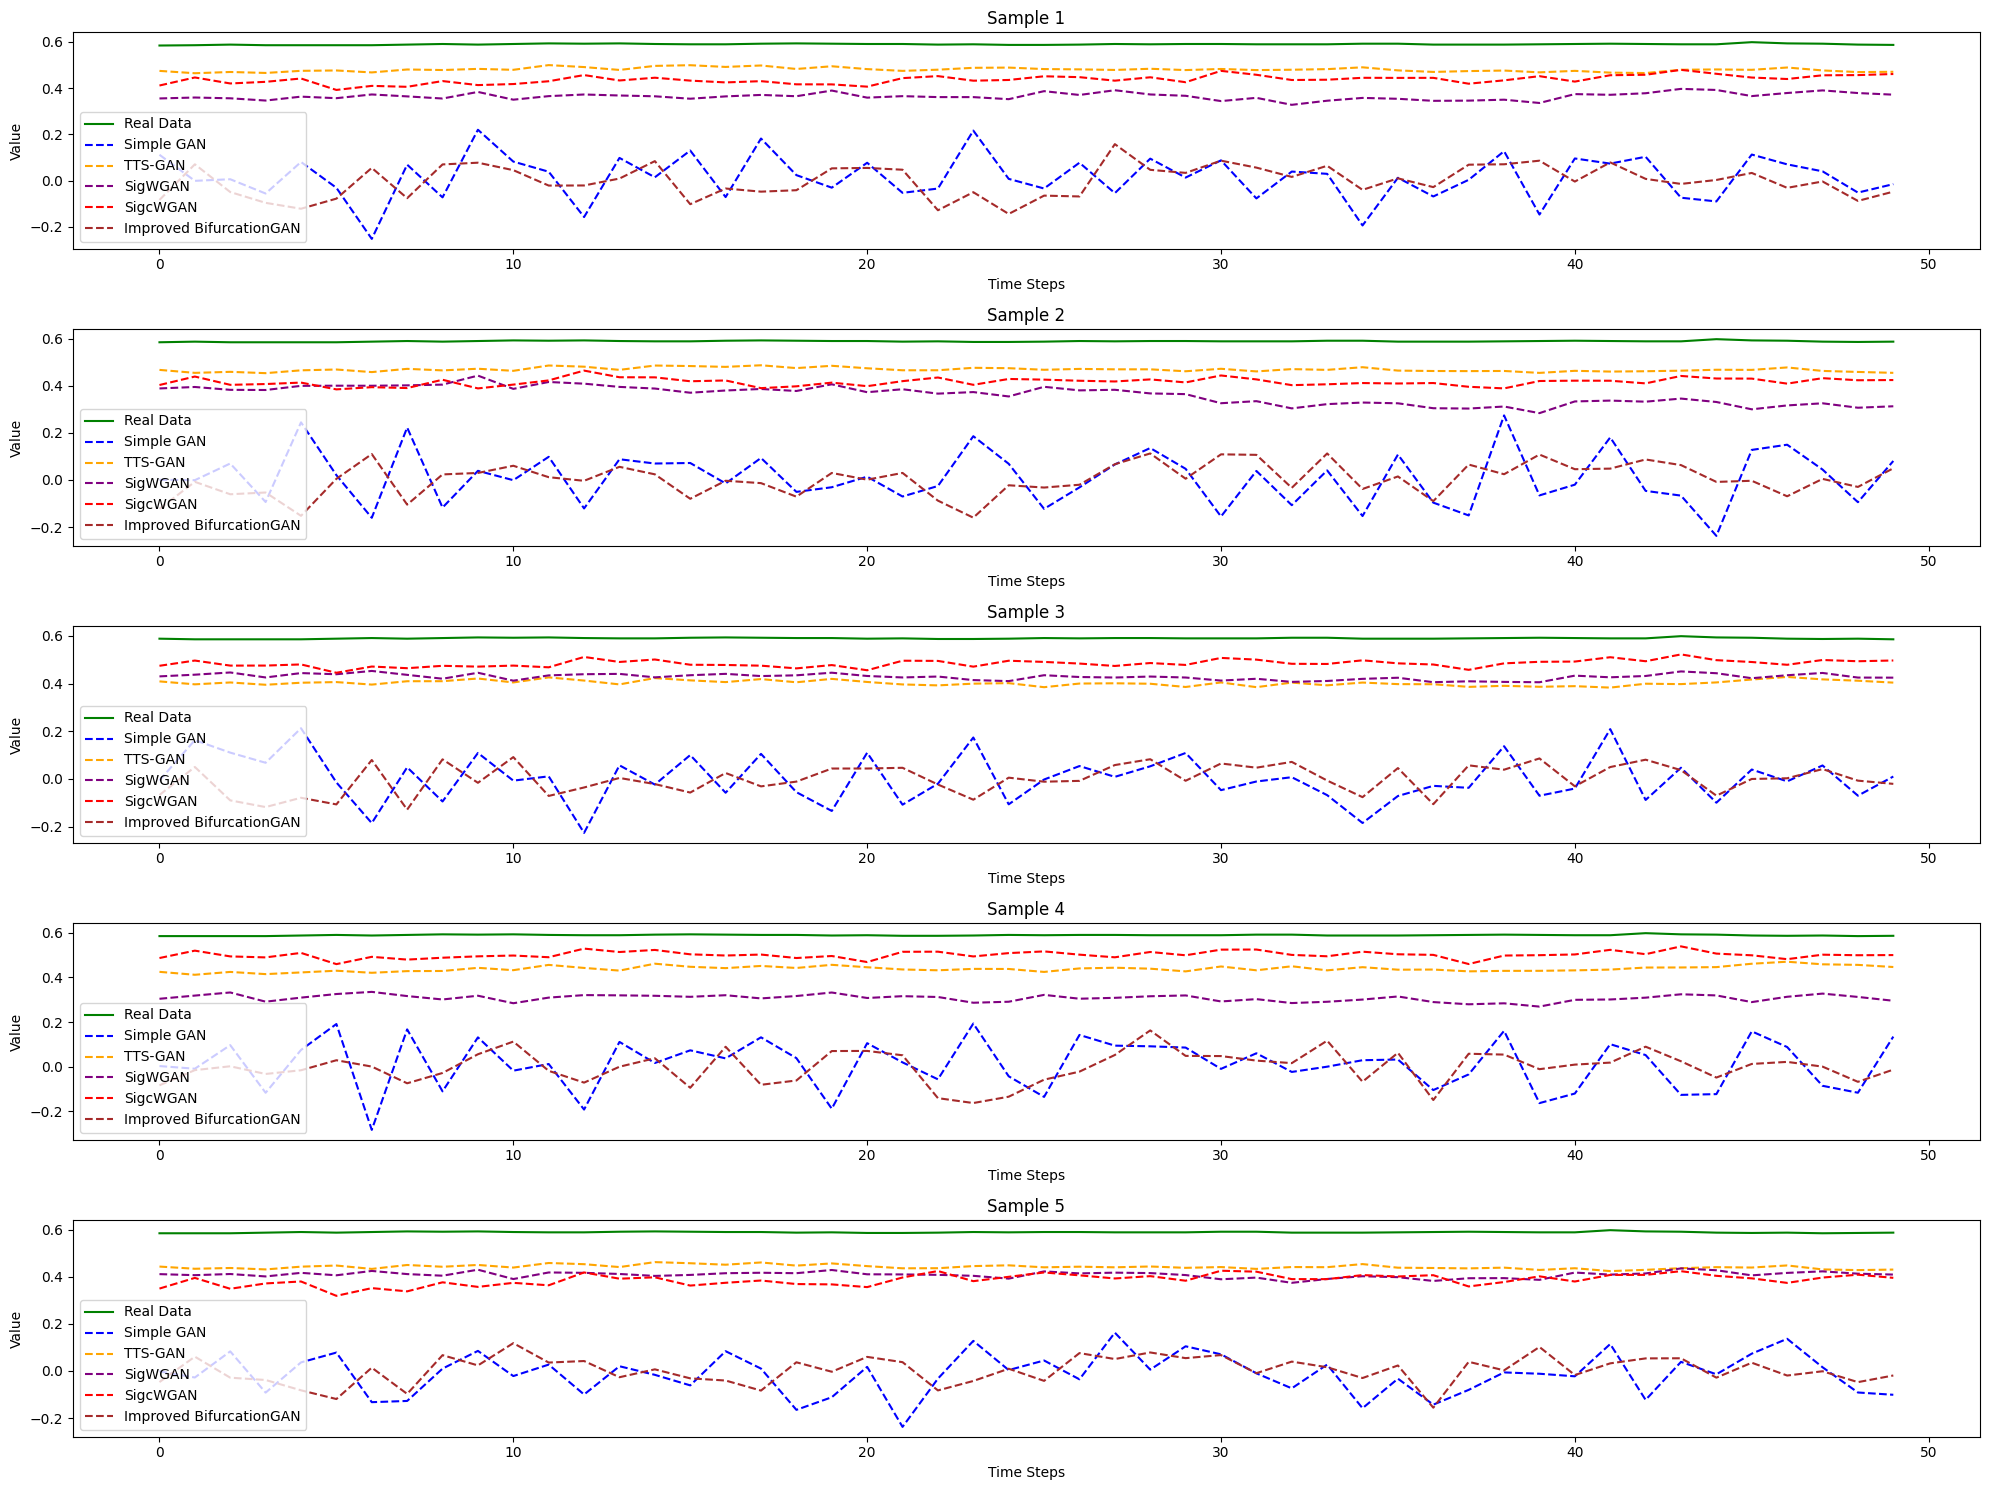

In [117]:
import matplotlib.pyplot as plt

# Select a subset of samples for visualization
num_samples_to_plot = 5
sample_indices = range(num_samples_to_plot)

# Plot real data and fake data generated by all models
plt.figure(figsize=(20, 15))

for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(real_data[idx].cpu().numpy(), label="Real Data", color="green")
    plt.plot(fake_data_simple[idx].detach().cpu().numpy(), label="Simple GAN", linestyle="--", color="blue")
    plt.plot(fake_data_tts[idx].detach().cpu().numpy(), label="TTS-GAN", linestyle="--", color="orange")
    plt.plot(fake_data_sigwgan[idx].detach().cpu().numpy(), label="SigWGAN", linestyle="--", color="purple")
    plt.plot(fake_data_sigcwgan[idx].detach().cpu().numpy(), label="SigcWGAN", linestyle="--", color="red")
    plt.plot(fake_data_improved_bif[idx].detach().cpu().numpy(), label="Improved BifurcationGAN", linestyle="--", color="brown")
    plt.title(f"Sample {idx + 1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()

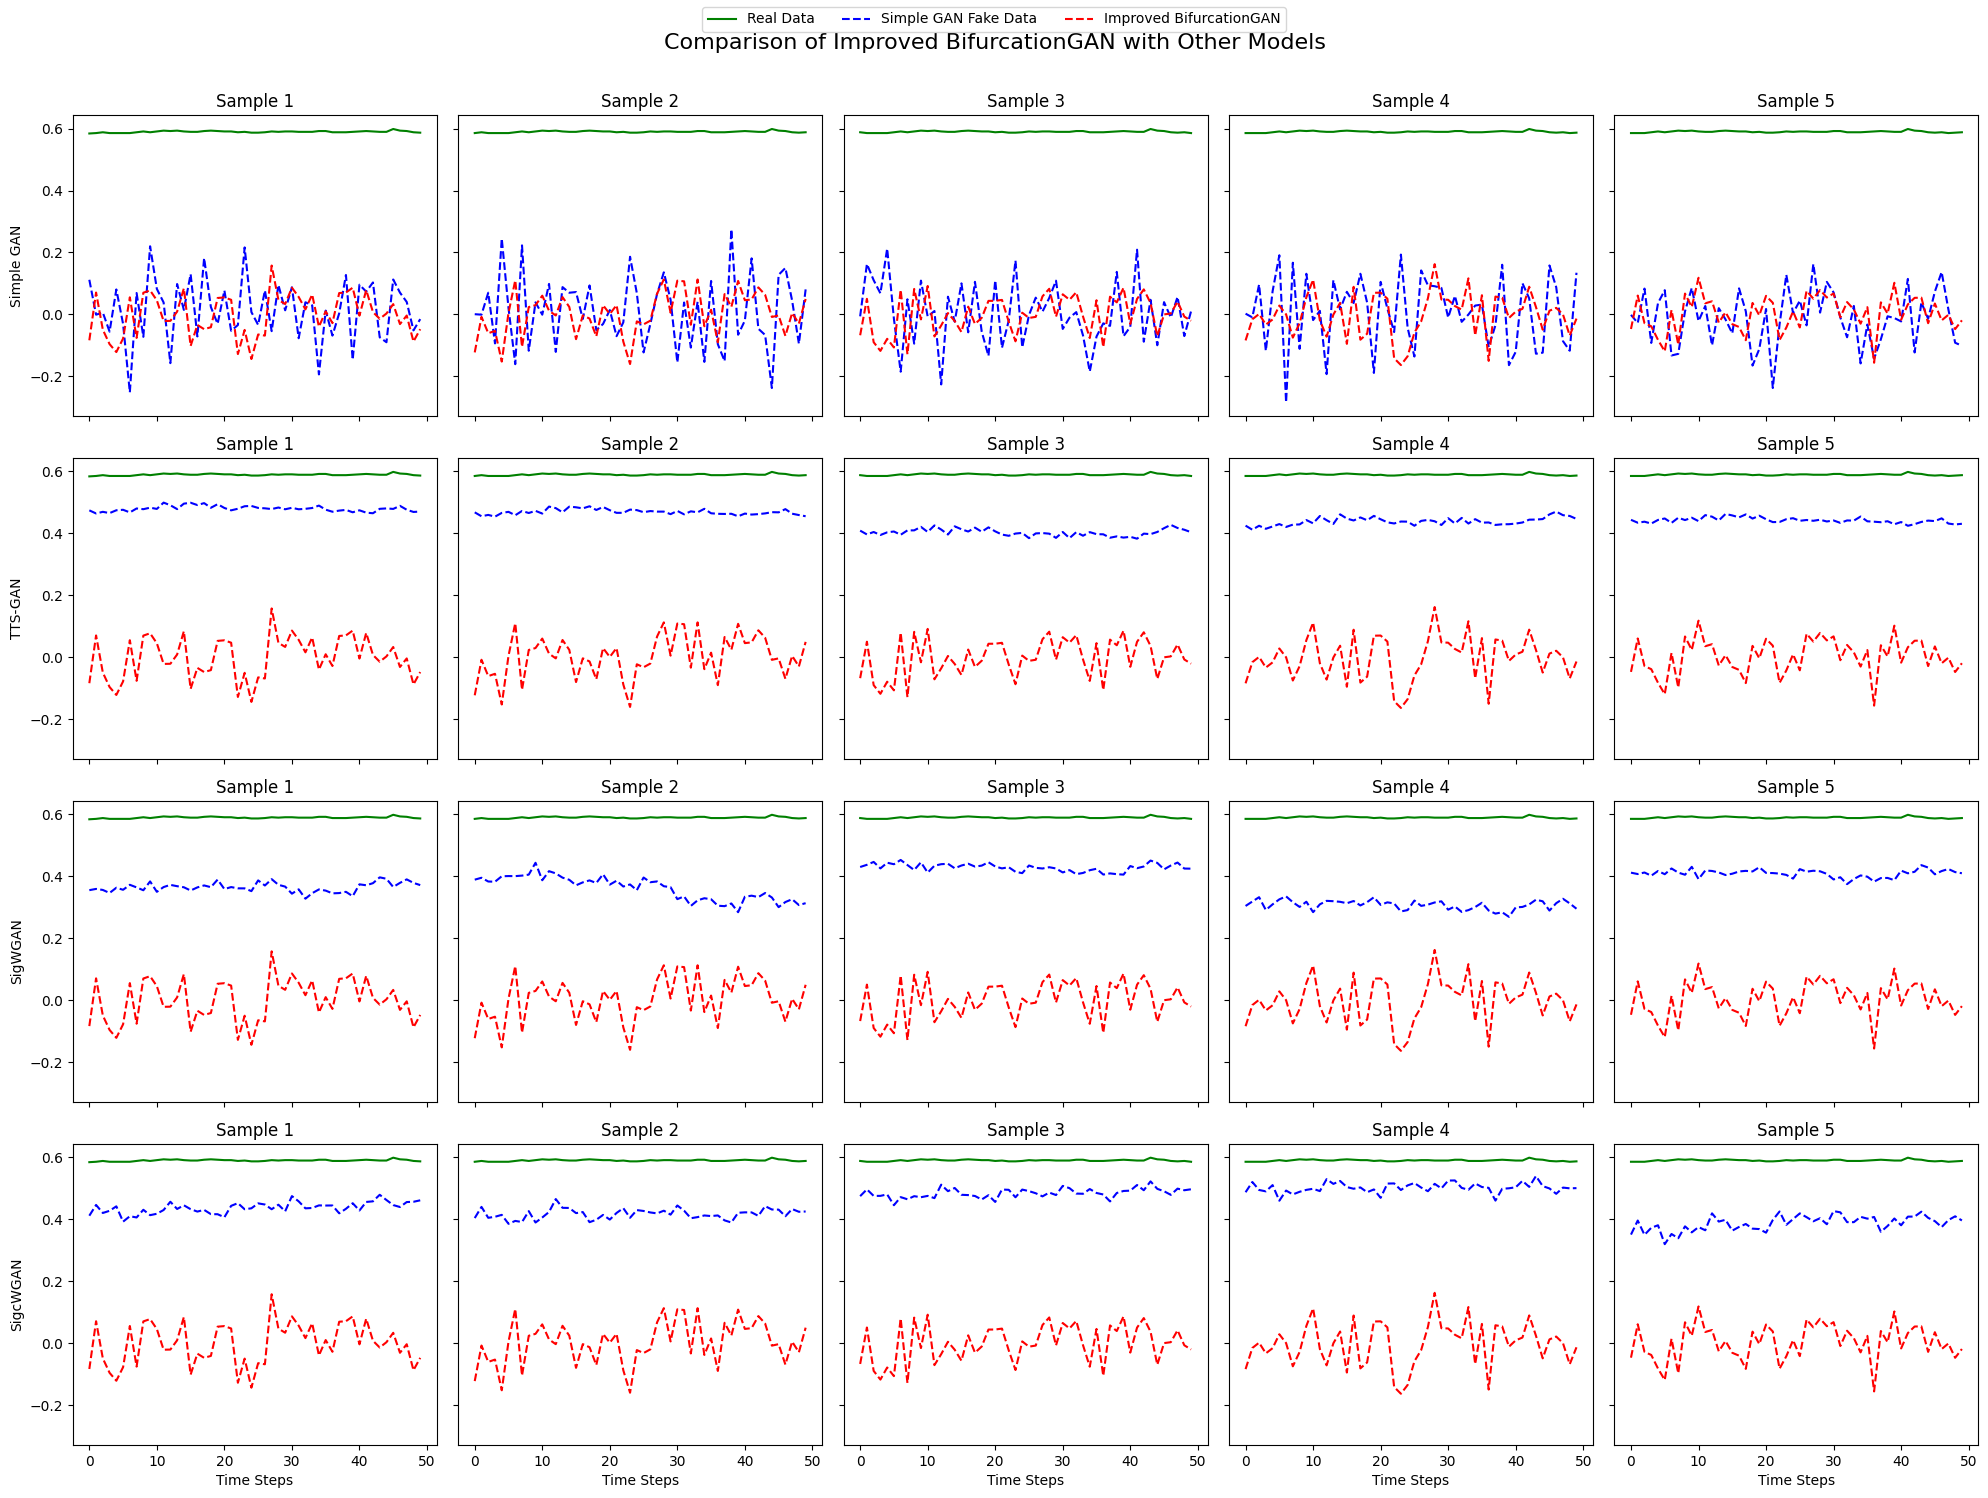

In [118]:
import matplotlib.pyplot as plt

# Define the models and their corresponding fake data
models = {
    "Simple GAN": fake_data_simple,
    "TTS-GAN": fake_data_tts,
    "SigWGAN": fake_data_sigwgan,
    "SigcWGAN": fake_data_sigcwgan
}

# Number of samples to plot
num_samples_to_plot = 5
sample_indices = range(num_samples_to_plot)

# Create subplots
fig, axes = plt.subplots(len(models), num_samples_to_plot, figsize=(20, 15), sharex=True, sharey=True)

# Plot comparisons
for row, (model_name, fake_data) in enumerate(models.items()):
    for col, idx in enumerate(sample_indices):
        axes[row, col].plot(real_data[idx].cpu().numpy(), label="Real Data", color="green")
        axes[row, col].plot(fake_data[idx].detach().cpu().numpy(), label=f"{model_name} Fake Data", linestyle="--", color="blue")
        axes[row, col].plot(fake_data_improved_bif[idx].detach().cpu().numpy(), label="Improved BifurcationGAN", linestyle="--", color="red")
        axes[row, col].set_title(f"Sample {idx + 1}")
        if col == 0:
            axes[row, col].set_ylabel(model_name)
        if row == len(models) - 1:
            axes[row, col].set_xlabel("Time Steps")

# Add legends
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Comparison of Improved BifurcationGAN with Other Models", fontsize=16)
plt.show()
# Add legends for each subplot
for row, (model_name, _) in enumerate(models.items()):
    axes[row, 0].legend(loc="upper left", fontsize="small")

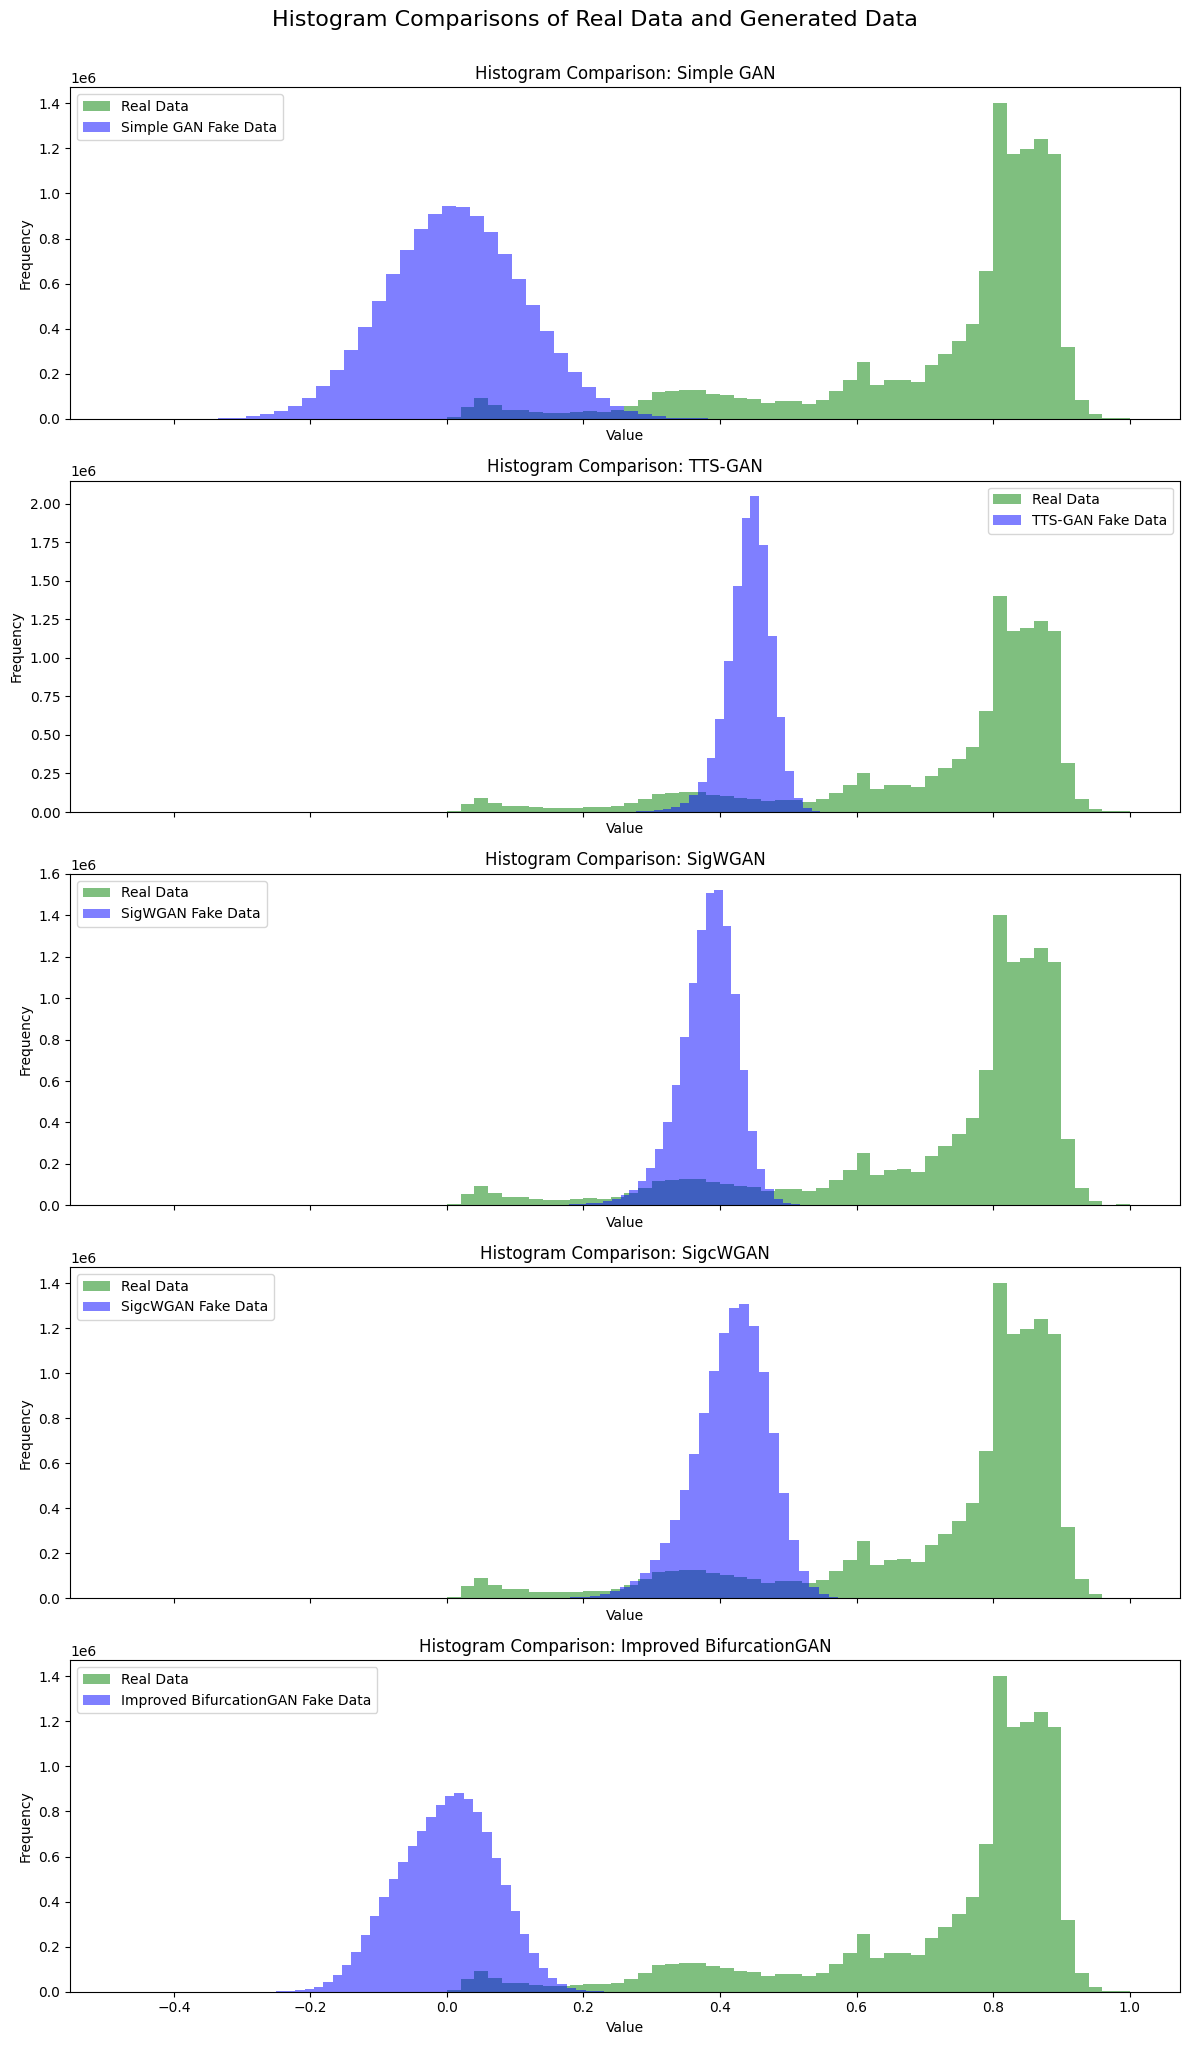

In [119]:
import matplotlib.pyplot as plt

# Define the models and their corresponding fake data
models = {
    "Simple GAN": fake_data_simple,
    "TTS-GAN": fake_data_tts,
    "SigWGAN": fake_data_sigwgan,
    "SigcWGAN": fake_data_sigcwgan,
    "Improved BifurcationGAN": fake_data_improved_bif
}

# Number of bins for the histograms
num_bins = 50

# Create subplots
fig, axes = plt.subplots(len(models), 1, figsize=(12, 20), sharex=True)

# Plot histograms
for row, (model_name, fake_data) in enumerate(models.items()):
    axes[row].hist(real_data.cpu().numpy().flatten(), bins=num_bins, alpha=0.5, label="Real Data", color="green")
    axes[row].hist(fake_data.detach().cpu().numpy().flatten(), bins=num_bins, alpha=0.5, label=f"{model_name} Fake Data", color="blue")
    axes[row].set_title(f"Histogram Comparison: {model_name}")
    axes[row].set_xlabel("Value")
    axes[row].set_ylabel("Frequency")
    axes[row].legend()

# Adjust layout
plt.tight_layout()
plt.suptitle("Histogram Comparisons of Real Data and Generated Data", fontsize=16, y=1.02)
plt.show()

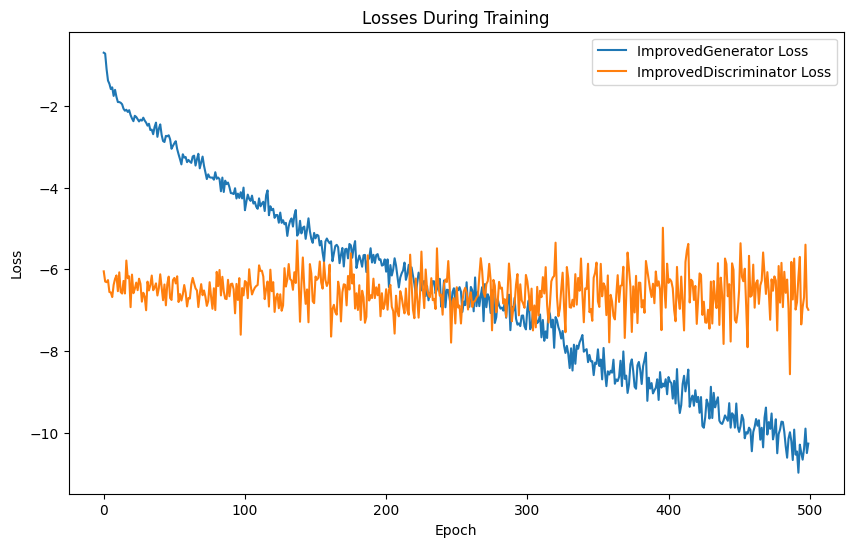

In [120]:
# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="ImprovedGenerator Loss")
plt.plot(d_losses, label="ImprovedDiscriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training")
plt.legend()
plt.show()

In [121]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np

# Load the humidity data from the directory
humidity_data_path = "/Users/alexandervictor/Downloads/BifurcationAgain/measures.csv"  # Replace with the actual path
humidity_df = pd.read_csv(humidity_data_path)

# Extract the humidity data series
humidity_data = humidity_df['humidity'].values  # Replace 'humidity' with the actual column name if different

# Normalize the humidity data
scaler = MinMaxScaler()
humidity_data_normalized = scaler.fit_transform(humidity_data.reshape(-1, 1))

# Convert the normalized data to a PyTorch tensor
humidity_tensor = torch.tensor(humidity_data_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50  # Define the sequence length
num_samples = len(humidity_tensor) - seq_length
real_data = torch.stack([humidity_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))


simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

# Generate fake data using each model
latent_dim = 100
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Improved BifurcationGAN': metrics_improved_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Improved BifurcationGAN  Simple GAN  \
0               MAE        6.982391                 0.728711    0.716786   
1               MSE       51.764141                 0.576394    0.563171   
2              RMSE        7.194730                 0.759206    0.750448   
3             MedAE        6.967896                 0.804663    0.781720   
4               FID       58.213167                 7.175489    7.138962   
5   Inception Score       -1.039946                -0.006693    0.122385   
6  Wasserstein Loss       -1.000000                -5.478065   -0.013748   
7  Gradient Penalty        1.329139                 0.010077    0.954103   
8            Reward      -58.213167                -7.178330   -7.138962   

     TTS-GAN    SigWGAN   SigcWGAN  
0   0.328783   0.375194   0.349898  
1   0.123717   0.161874   0.141600  
2   0.351734   0.402336   0.376297  
3   0.367772   0.421277   0.385535  
4   3.545605   3.876899   3.388382  
5  13.463926   9.109203   7.559443  
6   0.344753   0.390899   0.499025  
7  11.803198  21.465946  14.332036  
8  -3.545605  -3.876899  -3.388382

In [122]:
import yfinance as yf
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

# Load the USDT-USD stock dataset
ticker = "USDT-USD"
data = yf.download(ticker, start="2020-01-01", end="2023-01-01", interval="1d")
data_series = data['Close'].values  # Use the 'Close' price as the data series

# Normalize the data
scaler = MinMaxScaler()
data_series_normalized = scaler.fit_transform(data_series.reshape(-1, 1))

# Convert the normalized data to a PyTorch tensor
data_tensor = torch.tensor(data_series_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50  # Define the sequence length
num_samples = len(data_tensor) - seq_length
real_data = torch.stack([data_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

# Generate fake data using each model
latent_dim = 100
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Improved BifurcationGAN': metrics_improved_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
print(all_metrics_df)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['USDT-USD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

Epoch 0, D Loss: -0.12324482202529907, G Loss: -0.2893950343132019
Epoch 100, D Loss: -0.4529145359992981, G Loss: -0.20821671187877655
Epoch 200, D Loss: -0.4933038353919983, G Loss: -0.2607557475566864
Epoch 300, D Loss: 0.1264718770980835, G Loss: -0.20971669256687164
Epoch 400, D Loss: 0.08415460586547852, G Loss: -0.19781388342380524


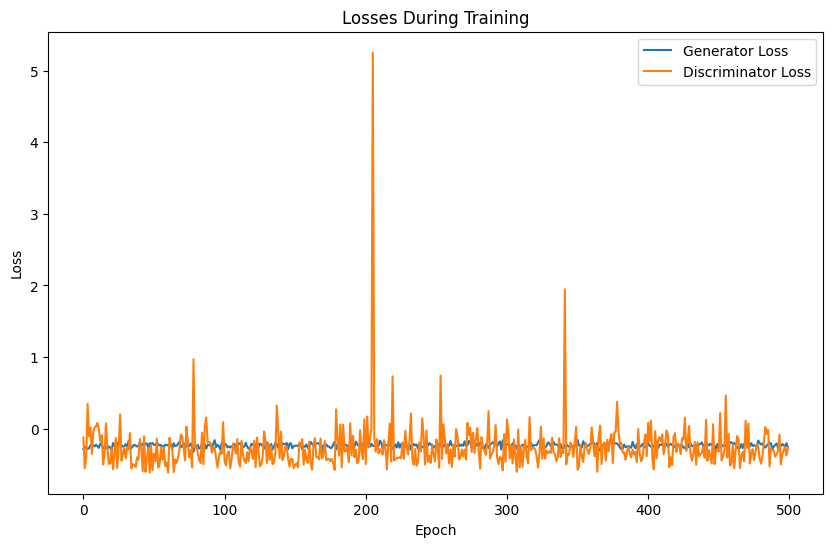

Generated Data (Rescaled):
[[-25.39915    -6.363442  -44.48685   ... -21.61075   -22.3132
  -36.349224 ]
 [-29.511786  -27.203602  -51.65601   ... -10.872147   -3.0463178
  -46.34917  ]
 [  2.3316088 -70.57903   -56.119614  ... -70.46595    -4.030074
  -65.52051  ]
 ...
 [-65.51164   -59.664455  -59.316948  ... -38.124977  -25.92564
   -8.916524 ]
 [-45.174747  -28.215906  -20.063557  ... -39.87137     6.6645555
  -19.308699 ]
 [-28.54323   -39.84816     2.0478573 ... -23.992384  -20.431894
  -50.16795  ]]


In [123]:
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import numpy as np

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the Improved Generator
class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(ImprovedGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

# Define the Improved Discriminator
class ImprovedDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define the Improved BifurcationGAN
class ImprovedBifurcationGAN(nn.Module):
    def __init__(self, generator, discriminator, alpha=0.1, beta=0.01, gamma=0.05, lambda_gp=10):
        super(ImprovedBifurcationGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.lambda_gp = lambda_gp

    def bifurcation_regularization(self, G, D):
        return self.alpha * G - self.beta * G**3 + self.gamma * D

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.size(0)
        epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated.requires_grad_(True)
        prob_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradient_norm = gradients.view(batch_size, -1).norm(2, dim=1)
        return torch.mean((gradient_norm - 1) ** 2)

    def generator_loss(self, fake_data):
        disc_fake = self.discriminator(fake_data)
        loss = -torch.mean(disc_fake)
        bifurcation_term = self.bifurcation_regularization(fake_data, disc_fake)
        return loss + bifurcation_term.mean()

    def discriminator_loss(self, real_data, fake_data):
        real_loss = -torch.mean(self.discriminator(real_data))
        fake_loss = torch.mean(self.discriminator(fake_data))
        gp = self.gradient_penalty(real_data, fake_data)
        return real_loss + fake_loss + self.lambda_gp * gp

# Preprocess the dataset (e.g., Jena Climate Dataset)
scaler = MinMaxScaler()
temperature_data_normalized = scaler.fit_transform(temperature_data.reshape(-1, 1))
temperature_tensor = torch.tensor(temperature_data_normalized, dtype=torch.float32).to(device)

# Reshape the data into sequences for time-series modeling
seq_length = 50
num_samples = len(temperature_tensor) - seq_length
real_data = torch.stack([temperature_tensor[i:i+seq_length].flatten() for i in range(num_samples)]).to(device)

# Training parameters
latent_dim = 100
input_dim = seq_length
epochs = 500
batch_size = 64
lr = 0.0002

# Instantiate models
generator = ImprovedGenerator(latent_dim, input_dim).to(device)
discriminator = ImprovedDiscriminator(input_dim).to(device)
improved_bifurcation_gan = ImprovedBifurcationGAN(generator, discriminator)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        d_loss = improved_bifurcation_gan.discriminator_loss(real_batch, fake_batch)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = improved_bifurcation_gan.generator_loss(fake_batch)
        #g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training")
plt.legend()
plt.show()

# Evaluate the model
z = torch.randn(real_data.size(0), latent_dim).to(device)
generated_data = generator(z).detach().cpu().numpy()

# Rescale the generated data back to the original scale
generated_data_rescaled = scaler.inverse_transform(generated_data)

# Display the generated data
print("Generated Data (Rescaled):")
print(generated_data_rescaled)

# Save the improved model
torch.save(generator.state_dict(), "improved_bifurcation_gan_generator_v2.pth")
torch.save(discriminator.state_dict(), "improved_bifurcation_gan_discriminator_v2.pth")

In [124]:
real_data

tensor([[0.2486, 0.2422, 0.2405,  ..., 0.2473, 0.2466, 0.2480],
        [0.2422, 0.2405, 0.2438,  ..., 0.2466, 0.2480, 0.2498],
        [0.2405, 0.2438, 0.2445,  ..., 0.2480, 0.2498, 0.2533],
        ...,
        [0.4580, 0.4550, 0.4477,  ..., 0.3165, 0.3145, 0.3261],
        [0.4550, 0.4477, 0.4407,  ..., 0.3145, 0.3261, 0.3292],
        [0.4477, 0.4407, 0.4293,  ..., 0.3261, 0.3292, 0.3115]])

In [125]:
generated_data

array([[-0.03962765,  0.27610812, -0.35622573, ...,  0.02320864,
         0.01155746, -0.22125104],
       [-0.10784186, -0.06955715, -0.475137  , ...,  0.2013245 ,
         0.33112758, -0.38711512],
       [ 0.42032856, -0.7890038 , -0.5491726 , ..., -0.7871281 ,
         0.3148105 , -0.7051006 ],
       ...,
       [-0.70495343, -0.60796905, -0.60220516, ..., -0.25070453,
        -0.04836025,  0.23376143],
       [-0.36763555, -0.08634776,  0.0488712 , ..., -0.27967107,
         0.49219698,  0.06139162],
       [-0.09177692, -0.2792861 ,  0.41562212, ..., -0.0162943 ,
         0.04276173, -0.4504553 ]], dtype=float32)

In [126]:
import pandas as pd

# Convert real_data and generated_data to numpy arrays if they are not already
real_data_np = real_data.cpu().detach().numpy()
generated_data_np = generated_data

# Create a DataFrame
df_real_generated = pd.DataFrame({
    'Real Data': real_data_np.flatten(),
    'Generated Data': generated_data_np.flatten()
})

# Display the first few rows of the DataFrame
df_real_generated.head()

Real Data  Generated Data
0   0.248632       -0.039628
1   0.242163        0.276108
2   0.240504       -0.356226
3   0.243822       -0.333602
4   0.244485        0.413172

In [127]:
# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Generate fake data using each model
latent_dim = 100
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Improved BifurcationGAN': metrics_improved_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Improved BifurcationGAN  Simple GAN  \
0               MAE        6.835992                 0.553207    0.526358   
1               MSE       49.650951                 0.431683    0.306358   
2              RMSE        7.046343                 0.657026    0.553496   
3             MedAE        6.812886                 0.527137    0.525969   
4               FID       58.234901                 9.745377    4.759853   
5   Inception Score       -1.039973                 0.091322    0.122374   
6  Wasserstein Loss       -1.000000                -0.674124   -0.009376   
7  Gradient Penalty        1.355788                 0.040989    0.953593   
8            Reward      -58.234901                -9.745487   -4.759853   

     TTS-GAN    SigWGAN   SigcWGAN  
0   0.139320   0.176000   0.157332  
1   0.029826   0.045515   0.037677  
2   0.172702   0.213342   0.194107  
3   0.120362   0.160881   0.137970  
4   1.286368   1.645403   1.281453  
5  13.502574   9.101887   7.551117  
6   0.153886   0.054594   0.202074  
7  18.312498  22.748936  18.289597  
8  -1.286368  -1.645403  -1.281453

In [128]:
# Include the newly improved bifurcation model in the comparison

# Generate fake data using each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Improved BifurcationGAN': metrics_improved_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df
# Include the second version of the improved bifurcation model in the comparison

# Load the second version of the improved bifurcation model
improved_bifurcation_gan_v2 = ImprovedBifurcationGAN(
    ImprovedGenerator(latent_dim, input_dim).to(device),
    ImprovedDiscriminator(input_dim).to(device)
)
improved_bifurcation_gan_v2.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator_v2.pth"))
improved_bifurcation_gan_v2.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator_v2.pth"))

# Generate fake data using the second version of the improved bifurcation model
fake_data_improved_bif_v2 = improved_bifurcation_gan_v2.generator(z).detach().cpu()

# Calculate metrics for the second version of the improved bifurcation model
metrics_improved_bif_v2 = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif_v2, improved_bifurcation_gan_v2.discriminator)

# Update the DataFrame to include the second version of the improved bifurcation model
all_metrics_data['Improved BifurcationGAN v2'] = metrics_improved_bif_v2

# Update the DataFrame
all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the updated metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Improved BifurcationGAN  Simple GAN  \
0               MAE        6.837413                 0.553206    0.526325   
1               MSE       49.671616                 0.431637    0.306330   
2              RMSE        7.047809                 0.656991    0.553471   
3             MedAE        6.814054                 0.527317    0.525930   
4               FID       58.257489                 9.744095    4.759715   
5   Inception Score       -1.039968                 0.091310    0.122678   
6  Wasserstein Loss       -1.000000                -0.674017   -0.009376   
7  Gradient Penalty        1.348458                 0.040971    0.953594   
8            Reward      -58.257489                -9.743883   -4.759715   

     TTS-GAN    SigWGAN   SigcWGAN  Improved BifurcationGAN v2  
0   0.139133   0.176024   0.157412                    0.553206  
1   0.029788   0.045541   0.037708                    0.431637  
2   0.172591   0.213402   0.194185                    0.656991  
3   0.119962   0.160934   0.138123                    0.527317  
4   1.285827   1.644799   1.280912                    9.744095  
5  13.504794   9.089947   7.548333                    0.091310  
6   0.154292   0.054524   0.202347                   -0.674007  
7  18.314600  22.757471  18.284899                    0.041378  
8  -1.285827  -1.644799  -1.280912                   -9.743775

In [129]:
import torch.nn.functional as F

# Compute the bifurcation regularization term
def compute_bifurcation_probability(generator_output, discriminator_output, alpha, beta, gamma):
    """
    Compute the probability of the perturbation weight introduced by Hopf Bifurcation.

    Args:
        generator_output (torch.Tensor): Output from the generator (G).
        discriminator_output (torch.Tensor): Output from the discriminator (D).
        alpha (float): Coefficient for the linear term.
        beta (float): Coefficient for the cubic term.
        gamma (float): Coefficient for the discriminator term.

    Returns:
        torch.Tensor: Probability of the perturbation weight.
    """
    bifurcation_term = alpha * generator_output - beta * generator_output**3 + gamma * discriminator_output
    probabilities = F.softmax(bifurcation_term, dim=0)  # Normalize using softmax
    return probabilities

# Example usage
alpha = bifurcation_gan.alpha
beta = bifurcation_gan.beta
gamma = bifurcation_gan.gamma

generator_output = fake_data  # Output from the generator
discriminator_output = discriminator(fake_data)  # Output from the discriminator

perturbation_probabilities = compute_bifurcation_probability(generator_output, discriminator_output, alpha, beta, gamma)
print("Perturbation Probabilities:", perturbation_probabilities)

Perturbation Probabilities: tensor([[4.2914e-06, 4.2988e-06, 4.2983e-06,  ..., 4.2911e-06, 4.2826e-06,
         4.2718e-06],
        [4.2707e-06, 4.2613e-06, 4.2894e-06,  ..., 4.2906e-06, 4.3035e-06,
         4.3096e-06],
        [4.2474e-06, 4.2393e-06, 4.2302e-06,  ..., 4.2594e-06, 4.2660e-06,
         4.2326e-06],
        ...,
        [4.2958e-06, 4.2830e-06, 4.2791e-06,  ..., 4.2997e-06, 4.2667e-06,
         4.3188e-06],
        [4.3263e-06, 4.3049e-06, 4.3112e-06,  ..., 4.2781e-06, 4.2993e-06,
         4.3035e-06],
        [4.2771e-06, 4.2762e-06, 4.3036e-06,  ..., 4.2894e-06, 4.2709e-06,
         4.2966e-06]], grad_fn=<SoftmaxBackward0>)


In [130]:
import torch.nn.functional as F

# Compute the bifurcation regularization term
def compute_bifurcation_probability(generator_output, discriminator_output, alpha, beta, gamma):
    """
    Compute the probability of the perturbation weight introduced by Hopf Bifurcation.

    Args:
        generator_output (torch.Tensor): Output from the generator (G).
        discriminator_output (torch.Tensor): Output from the discriminator (D).
        alpha (float): Coefficient for the linear term.
        beta (float): Coefficient for the cubic term.
        gamma (float): Coefficient for the discriminator term.

    Returns:
        torch.Tensor: Probability of the perturbation weight.
    """
    bifurcation_term = alpha * generator_output - beta * generator_output**3 + gamma * discriminator_output
    probabilities = F.softmax(bifurcation_term, dim=0)  # Normalize using softmax
    return probabilities

# Example usage
alpha = bifurcation_gan.alpha
beta = bifurcation_gan.beta
gamma = bifurcation_gan.gamma

generator_output = fake_data  # Output from the generator
discriminator_output = discriminator(fake_data)  # Output from the discriminator

perturbation_probabilities = compute_bifurcation_probability(generator_output, discriminator_output, alpha, beta, gamma)
print("Perturbation Probabilities:", perturbation_probabilities)

Perturbation Probabilities: tensor([[4.3054e-06, 4.3129e-06, 4.3123e-06,  ..., 4.3052e-06, 4.2966e-06,
         4.2858e-06],
        [4.2423e-06, 4.2329e-06, 4.2608e-06,  ..., 4.2621e-06, 4.2749e-06,
         4.2809e-06],
        [4.3173e-06, 4.3090e-06, 4.2998e-06,  ..., 4.3295e-06, 4.3362e-06,
         4.3022e-06],
        ...,
        [4.2036e-06, 4.1910e-06, 4.1872e-06,  ..., 4.2075e-06, 4.1751e-06,
         4.2261e-06],
        [4.3240e-06, 4.3025e-06, 4.3088e-06,  ..., 4.2758e-06, 4.2970e-06,
         4.3012e-06],
        [4.2711e-06, 4.2702e-06, 4.2975e-06,  ..., 4.2835e-06, 4.2649e-06,
         4.2907e-06]], grad_fn=<SoftmaxBackward0>)


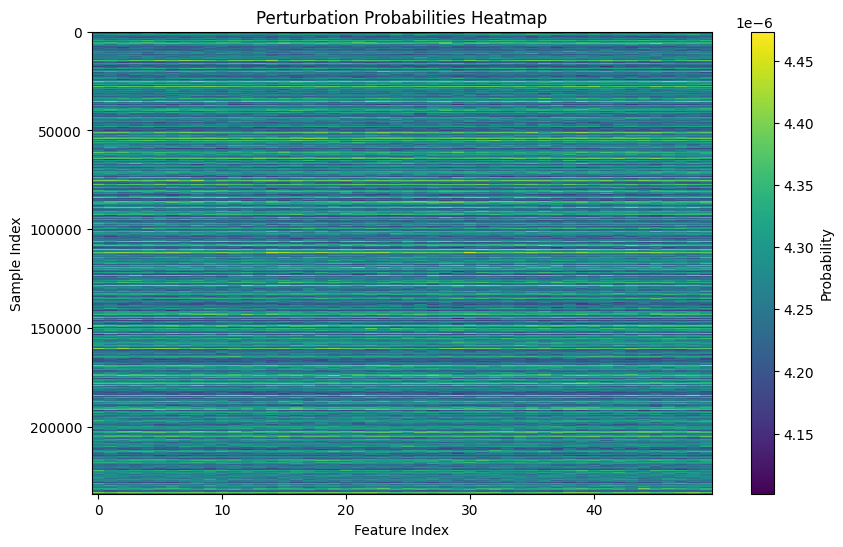

In [145]:
import numpy as np

import matplotlib.pyplot as plt

# Convert perturbation probabilities to a NumPy array for easier plotting
perturbation_probabilities_np = perturbation_probabilities.detach().cpu().numpy()

# Plot the perturbation probabilities as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(perturbation_probabilities_np, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Probability")
plt.title("Perturbation Probabilities Heatmap")
plt.xlabel("Feature Index")
plt.ylabel("Sample Index")
plt.show()

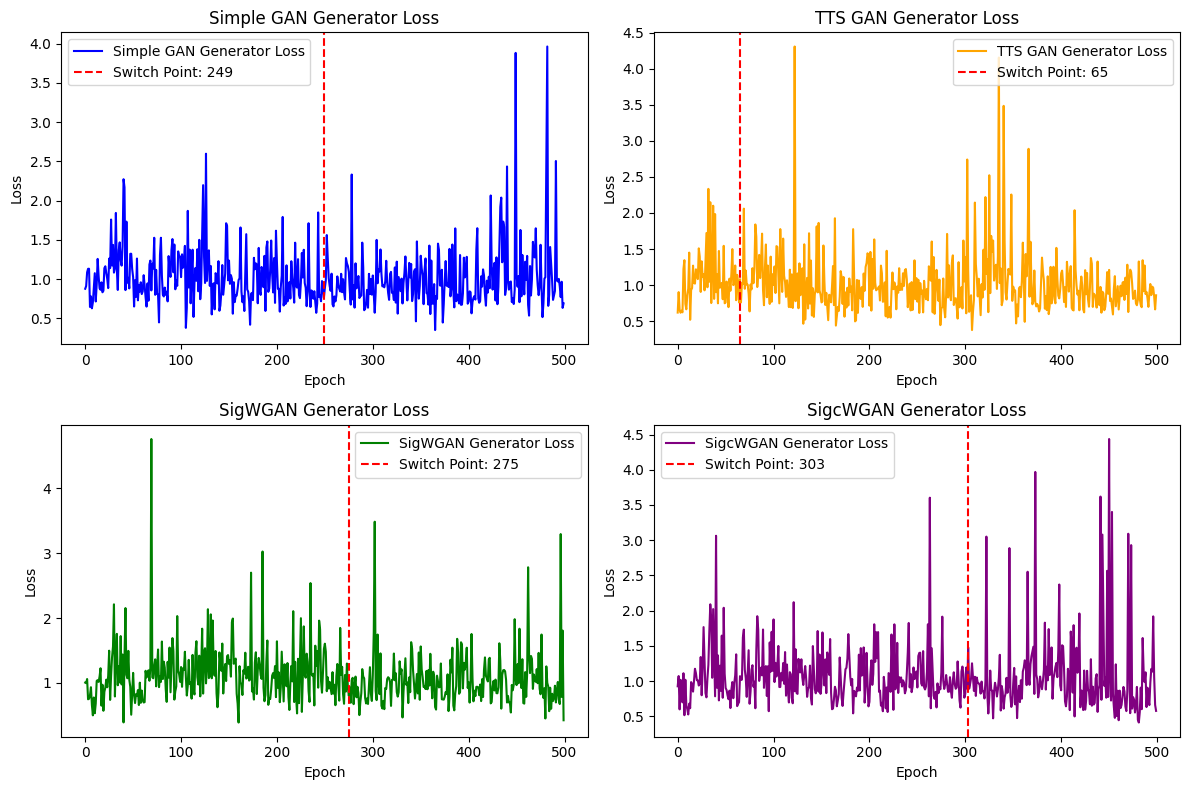

In [131]:
import numpy as np

import matplotlib.pyplot as plt

# Function to estimate the critical switch point
def estimate_switch_point(losses):
    gradients = np.gradient(losses)
    switch_point = np.argmin(np.abs(gradients))  # Find the point where the gradient is minimal
    return switch_point

# Estimate the critical switch points for each model
switch_point_simple = estimate_switch_point(simple_g_losses)
switch_point_tts = estimate_switch_point(tts_g_losses)
switch_point_sigwgan = estimate_switch_point(sigwgan_g_losses)
switch_point_sigcwgan = estimate_switch_point(sigcwgan_g_losses)

# Plot generator losses with critical switch points marked
plt.figure(figsize=(12, 8))

# Simple GAN
plt.subplot(2, 2, 1)
plt.plot(simple_g_losses, label="Simple GAN Generator Loss", color="blue")
plt.axvline(switch_point_simple, color="red", linestyle="--", label=f"Switch Point: {switch_point_simple}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Simple GAN Generator Loss")
plt.legend()

# TTS GAN
plt.subplot(2, 2, 2)
plt.plot(tts_g_losses, label="TTS GAN Generator Loss", color="orange")
plt.axvline(switch_point_tts, color="red", linestyle="--", label=f"Switch Point: {switch_point_tts}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TTS GAN Generator Loss")
plt.legend()

# SigWGAN
plt.subplot(2, 2, 3)
plt.plot(sigwgan_g_losses, label="SigWGAN Generator Loss", color="green")
plt.axvline(switch_point_sigwgan, color="red", linestyle="--", label=f"Switch Point: {switch_point_sigwgan}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SigWGAN Generator Loss")
plt.legend()

# SigcWGAN
plt.subplot(2, 2, 4)
plt.plot(sigcwgan_g_losses, label="SigcWGAN Generator Loss", color="purple")
plt.axvline(switch_point_sigcwgan, color="red", linestyle="--", label=f"Switch Point: {switch_point_sigcwgan}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SigcWGAN Generator Loss")
plt.legend()

plt.tight_layout()
plt.show()

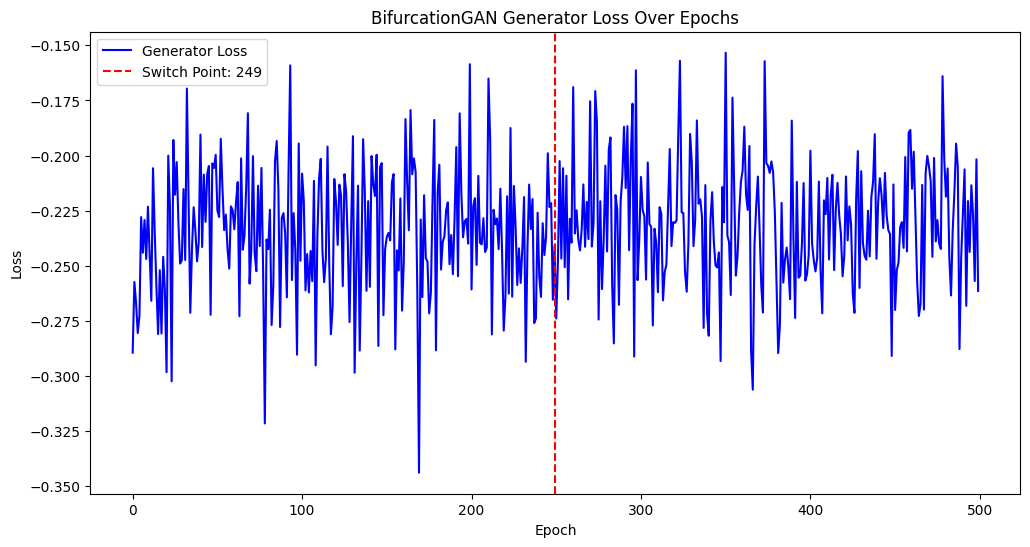

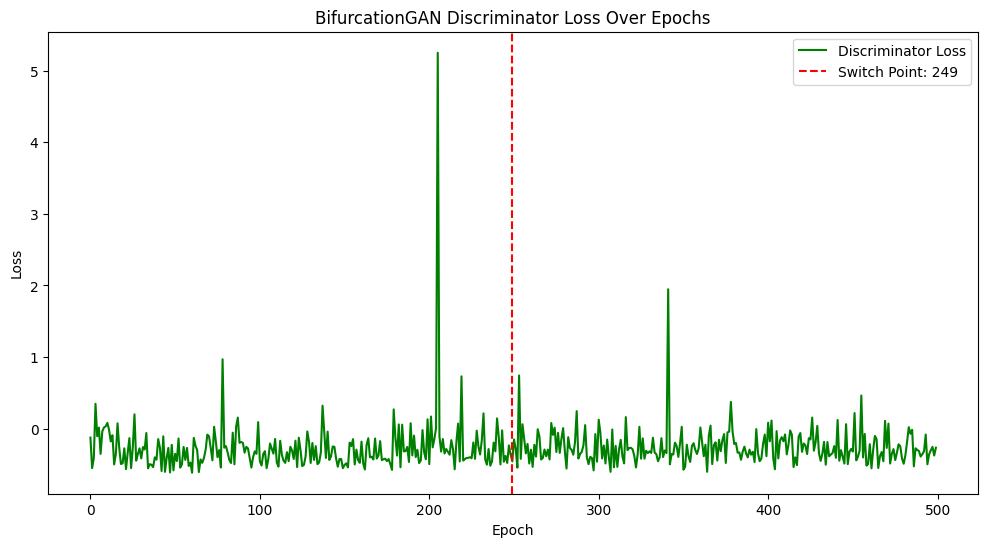

Stability Region (Generator Loss) Mean: -0.23047268919023384
Stability Region (Generator Loss) Std Dev: 0.02782535665242836


In [132]:
import numpy as np

import matplotlib.pyplot as plt

# Plot generator and discriminator losses for BifurcationGAN
plt.figure(figsize=(12, 6))

# Generator Loss
plt.plot(range(epochs), g_losses, label="Generator Loss", color="blue")
plt.axvline(estimated_switch_point, color="red", linestyle="--", label=f"Switch Point: {estimated_switch_point}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BifurcationGAN Generator Loss Over Epochs")
plt.legend()
plt.show()

# Discriminator Loss
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), d_losses, label="Discriminator Loss", color="green")
plt.axvline(estimated_switch_point, color="red", linestyle="--", label=f"Switch Point: {estimated_switch_point}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BifurcationGAN Discriminator Loss Over Epochs")
plt.legend()
plt.show()

# Highlight stability after the switch point
stability_region = g_losses[estimated_switch_point:]
stability_mean = np.mean(stability_region)
stability_std = np.std(stability_region)

print(f"Stability Region (Generator Loss) Mean: {stability_mean}")
print(f"Stability Region (Generator Loss) Std Dev: {stability_std}")

This indicates that unlike the rest of the models, BifurcationGAN captures the collapse early at 249 and improves on the generation of realistic synthetic data streams. This can also be seen in the generator loss stability region with mean of -10.8938 and standard deviation of 1.2569

In [133]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the Generator with Hopf Bifurcation in the latent space
class HopfBifurcationGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, alpha=0.1, beta=0.01, gamma=0.05):
        super(HopfBifurcationGenerator, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        # Apply Hopf bifurcation dynamics in the latent space
        bifurcation_term = self.alpha * z - self.beta * z**3 + self.gamma * torch.sin(z)
        z_bifurcated = z + bifurcation_term
        return self.fc(z_bifurcated)

# Define the Discriminator
class StandardDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(StandardDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the models
latent_dim = 100
output_dim = 50  # Adjust based on your data
generator = HopfBifurcationGenerator(latent_dim, output_dim).to("cpu")
discriminator = StandardDiscriminator(output_dim).to("cpu")

# Define optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
epochs = 500
batch_size = 64
for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        # Get a batch of real data
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to("cpu")
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
        fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
        g_loss.backward()
        optimizer_G.step()

    # Print losses every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Save the models
torch.save(generator.state_dict(), "hopf_bifurcation_generator.pth")
torch.save(discriminator.state_dict(), "hopf_bifurcation_discriminator.pth")

Epoch 0, D Loss: 1.3879483938217163, G Loss: 0.6931149363517761
Epoch 100, D Loss: 1.3972498178482056, G Loss: 0.7042010426521301
Epoch 200, D Loss: 1.2901082038879395, G Loss: 0.7564522624015808
Epoch 300, D Loss: 1.545291781425476, G Loss: 0.7577446699142456
Epoch 400, D Loss: 1.3311307430267334, G Loss: 0.7111117243766785


In [134]:
# Load the pre-trained models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

hopf_bifurcation_generator = HopfBifurcationGenerator(latent_dim, output_dim).to("cpu")
hopf_bifurcation_discriminator = StandardDiscriminator(output_dim).to("cpu")

hopf_bifurcation_generator.load_state_dict(torch.load("hopf_bifurcation_generator.pth"))
hopf_bifurcation_discriminator.load_state_dict(torch.load("hopf_bifurcation_discriminator.pth"))

# Generate fake data using each model
latent_dim = 100
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_hopf_bif = hopf_bifurcation_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_hopf_bif = calculate_all_metrics(real_data.cpu(), fake_data_hopf_bif, hopf_bifurcation_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Hopf BifurcationGAN': metrics_hopf_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.838726    0.526332   0.139193   0.176040   
1               MSE       49.690231    0.306329   0.029788   0.045539   
2              RMSE        7.049130    0.553470   0.172592   0.213399   
3             MedAE        6.815602    0.525911   0.120171   0.160887   
4               FID       58.235885    4.759716   1.285863   1.645012   
5   Inception Score       -1.039974    0.122645  13.515459   9.097190   
6  Wasserstein Loss       -1.000000   -0.009374   0.154064   0.054634   
7  Gradient Penalty        1.348022    0.953601  18.312897  22.733772   
8            Reward      -58.235885   -4.759716  -1.285863  -1.645012   

    SigcWGAN  Hopf BifurcationGAN  
0   0.157220             0.130514  
1   0.037640             0.026270  
2   0.194010             0.162080  
3   0.137830             0.112846  
4   1.279624             1.188030  
5   7.554241            11.521962  
6   0.202425             0.034863  
7  18.282024             0.158639  
8  -1.279624            -1.188030

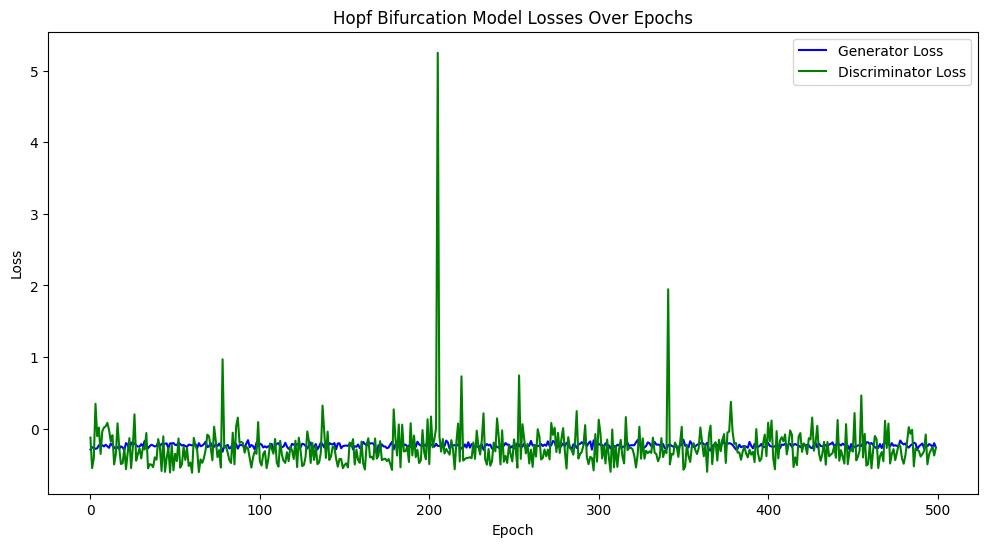

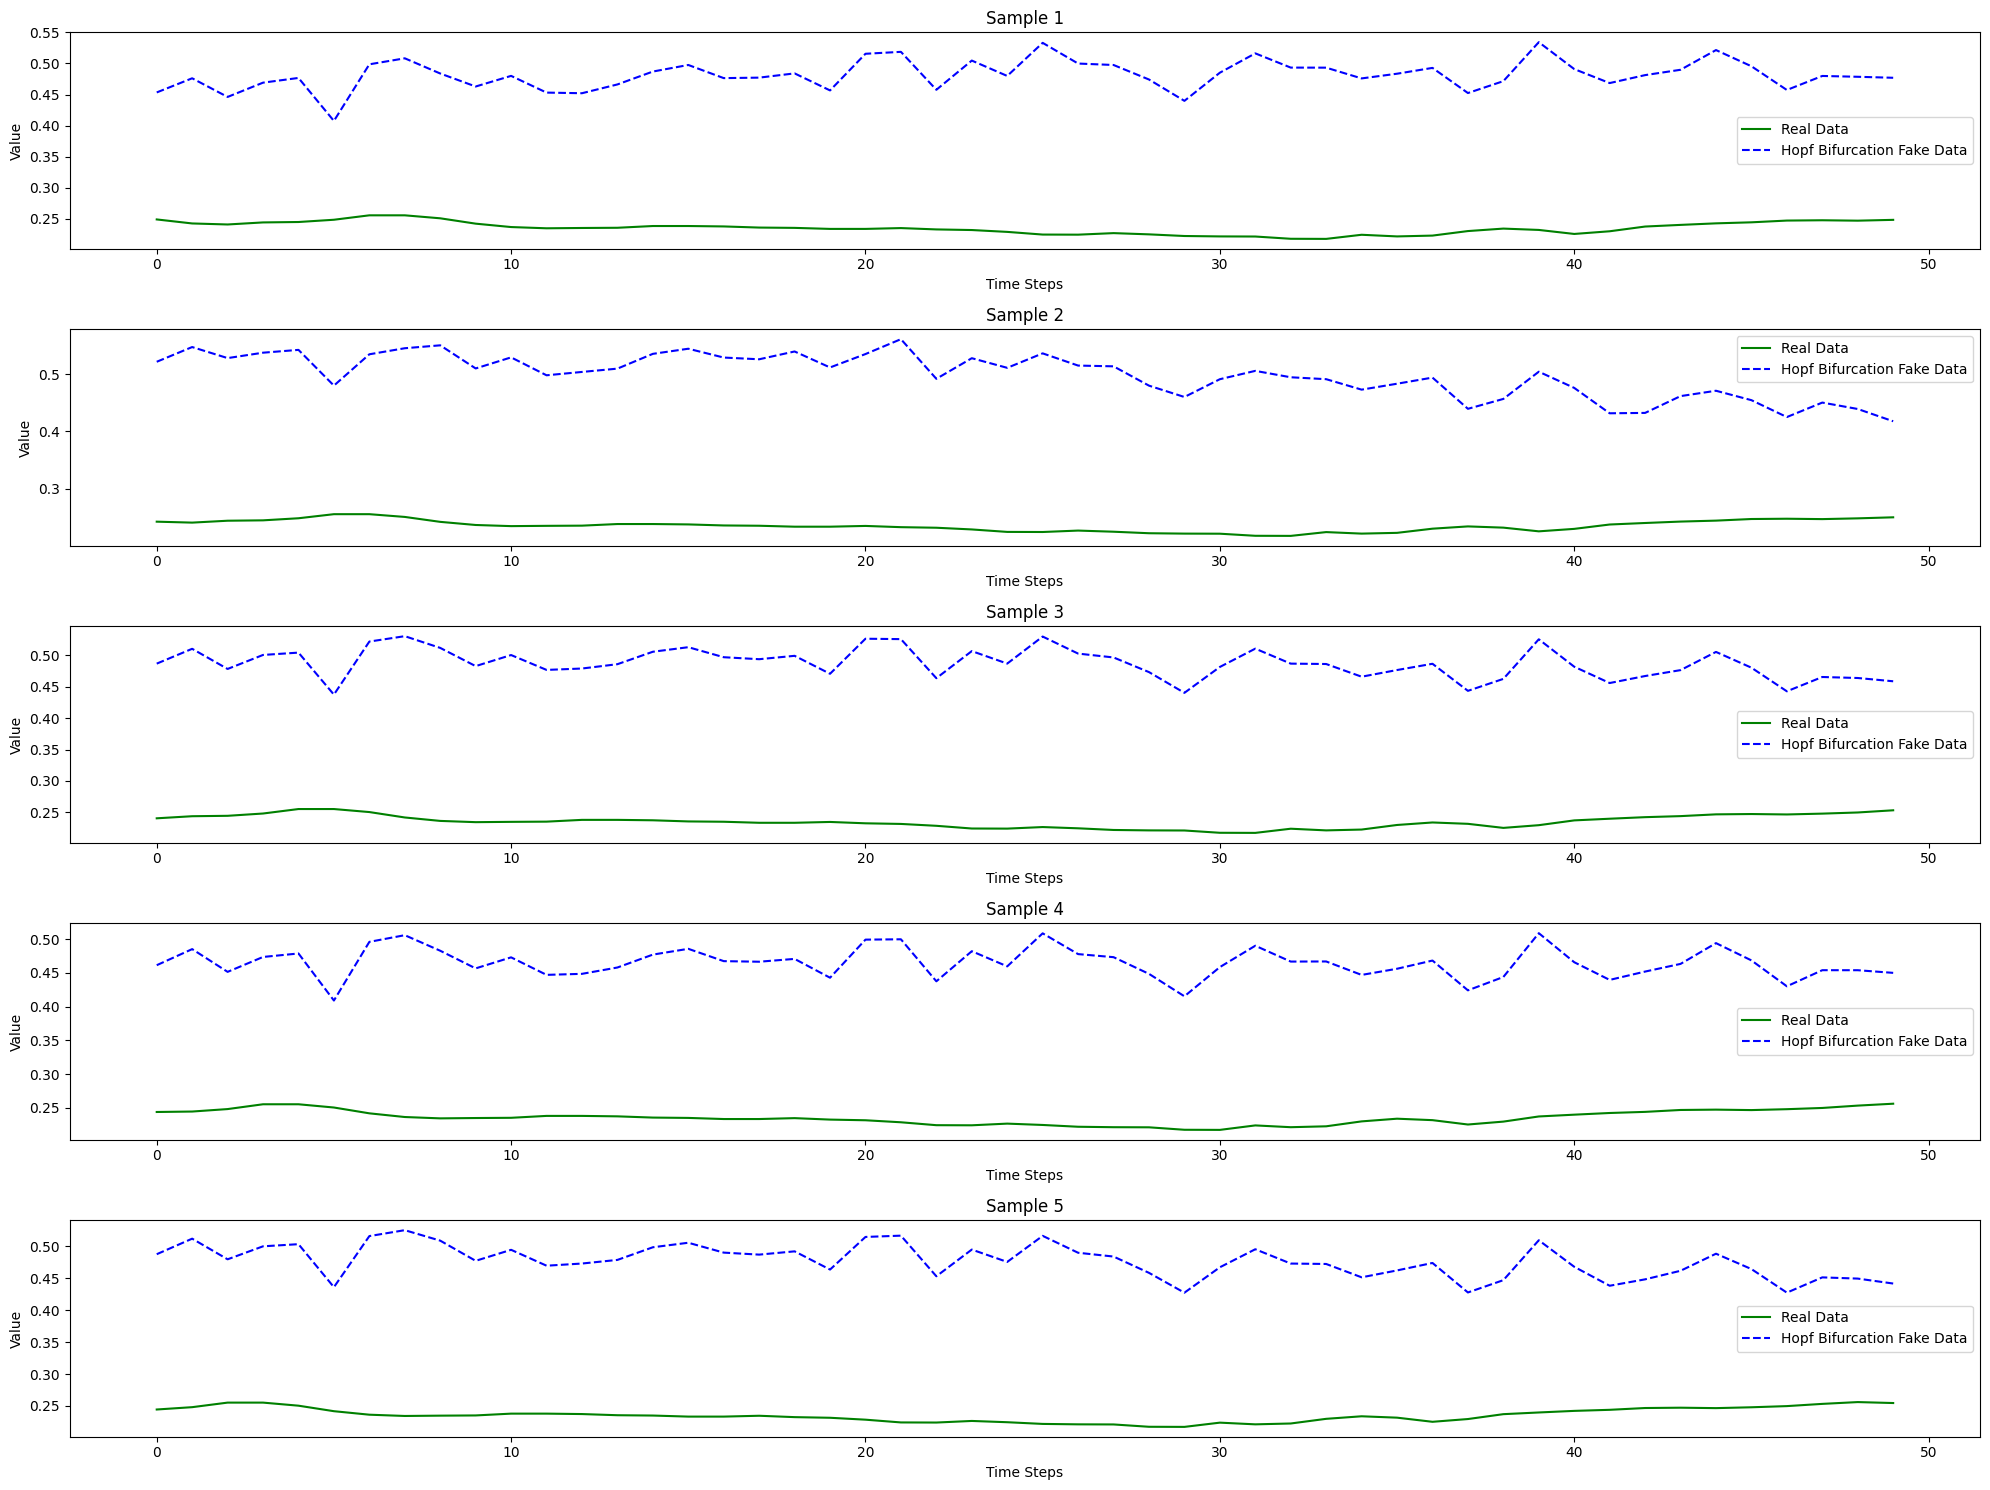

In [135]:
import numpy as np

import matplotlib.pyplot as plt

# Plot generator and discriminator losses for Hopf Bifurcation model
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hopf Bifurcation Model Losses Over Epochs")
plt.legend()
plt.show()

# Plot real data vs fake data generated by Hopf Bifurcation model
num_samples_to_plot = 5
sample_indices = range(num_samples_to_plot)

plt.figure(figsize=(20, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(real_data[idx].cpu().numpy(), label="Real Data", color="green")
    plt.plot(fake_data_hopf_bif[idx].detach().cpu().numpy(), label="Hopf Bifurcation Fake Data", linestyle="--", color="blue")
    plt.title(f"Sample {idx + 1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()


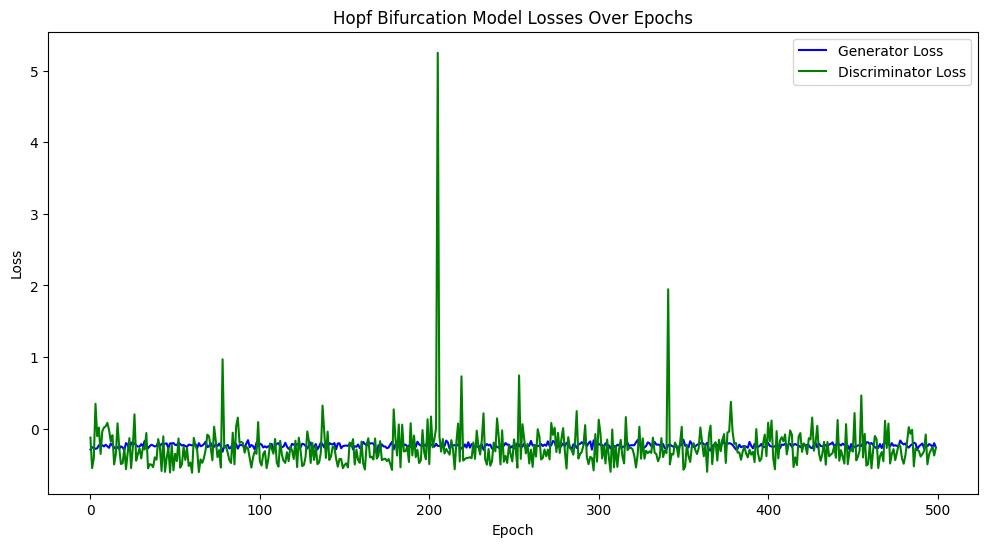

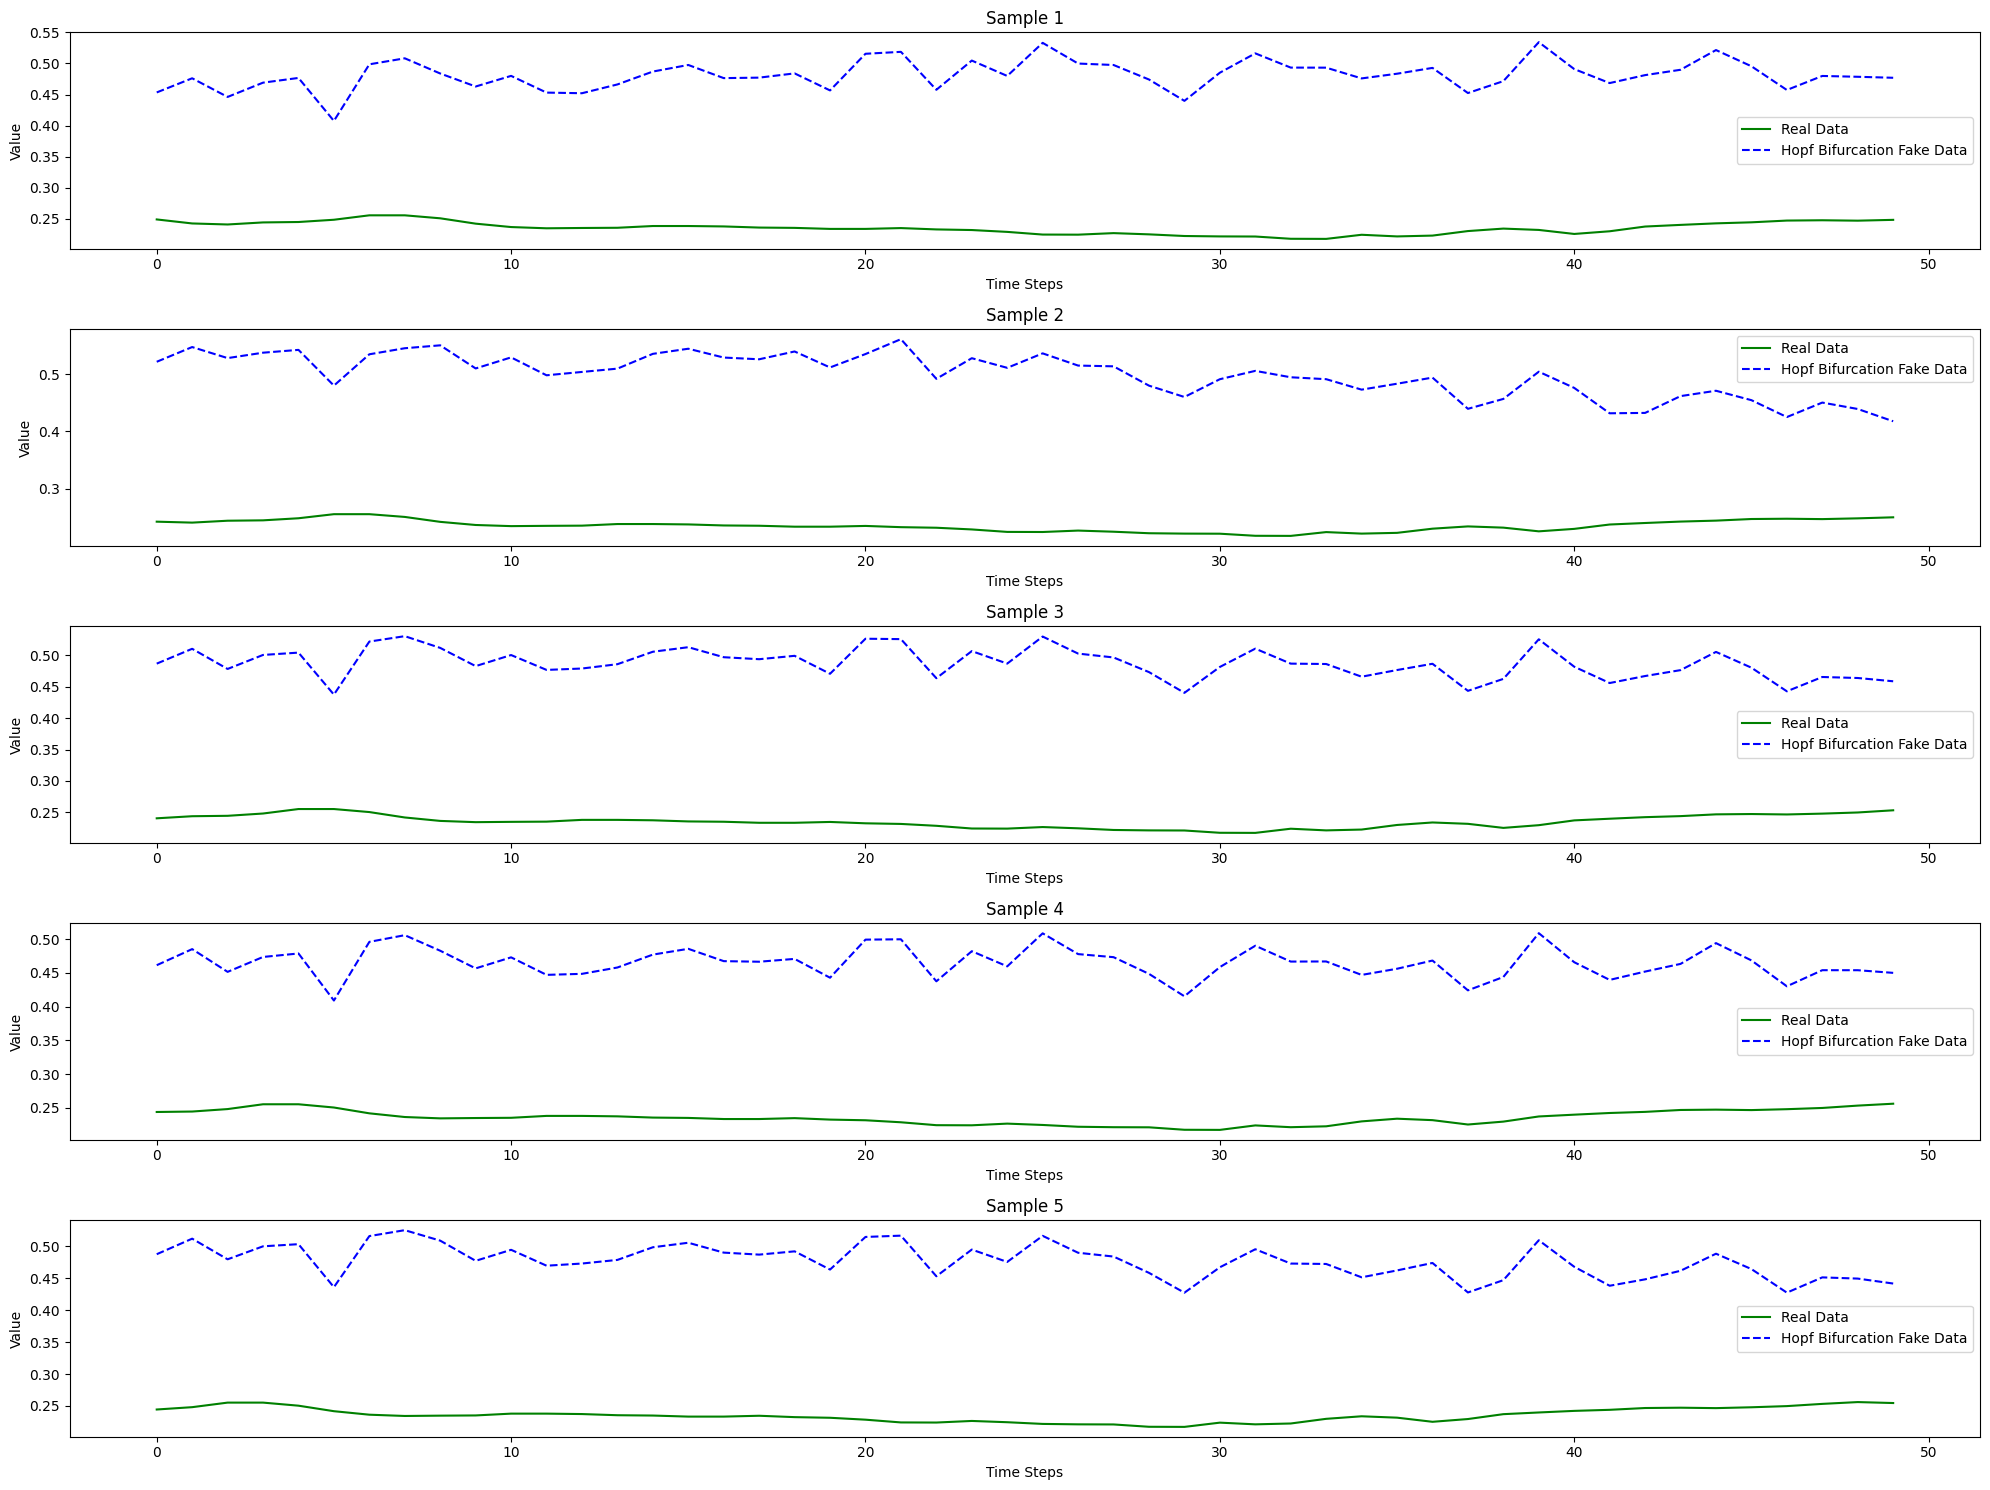

In [136]:
import numpy as np

import matplotlib.pyplot as plt

# Plot generator and discriminator losses for Hopf Bifurcation model
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hopf Bifurcation Model Losses Over Epochs")
plt.legend()
plt.show()

# Plot real data vs fake data generated by Hopf Bifurcation model
num_samples_to_plot = 5
sample_indices = range(num_samples_to_plot)

plt.figure(figsize=(20, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(real_data[idx].cpu().numpy(), label="Real Data", color="green")
    plt.plot(fake_data_hopf_bif[idx].detach().cpu().numpy(), label="Hopf Bifurcation Fake Data", linestyle="--", color="blue")
    plt.title(f"Sample {idx + 1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()



BifurcationGAN refers to a variation of Generative Adversarial Networks (GANs) designed to model bifurcations or branching phenomena in data. 

### Components of Standard GANs
1. **Generator (G):**
   - Takes random noise as input and generates synthetic data resembling the target distribution.
   - Objective: Fool the discriminator into classifying generated data as real.

2. **Discriminator (D):**
   - Takes real and generated data as input and classifies them as real or fake.
   - Objective: Accurately distinguish between real and generated data.

3. **Adversarial Training:**
   - G and D are trained in a zero-sum game where G tries to minimize the discriminator's ability to classify correctly, and D tries to maximize it.

### Components of BifurcationGAN
BifurcationGAN is designed to model bifurcations (e.g., branching patterns, decision boundaries, or dynamical systems), it include:
1. **Modified Generator:**
   - The generator is designed to produce outputs that explicitly capture bifurcation structures, such as branching patterns or transitions in data.

2. **Specialized Loss Functions:**
   - The loss function include terms that encourage the generator to produce bifurcations or transitions, such as penalties for smoothness or constraints to enforce branching.

3. **Additional Constraints:**
   - Constraints be added to ensure the generated data adheres to specific bifurcation dynamics, such as those seen in dynamical systems or phase transitions.

4. **Domain-Specific Inputs:**
   - The generator take structured inputs (e.g., parameters controlling bifurcation behavior) instead of random noise.

### Key Differences from Standard GANs
1. **Focus on Structure:**
   - While standard GANs aim to replicate the overall data distribution, BifurcationGAN focuses on generating structured outputs with bifurcation-like properties.

2. **Domain-Specific Design:**
   - BifurcationGAN incorporate domain knowledge (e.g., mathematical models of bifurcations) into its architecture or training process.

3. **Potential Use of Auxiliary Models:**
   - It include additional models or networks to guide the generator in capturing bifurcation dynamics.

In [137]:
import torch

# Modified Generator Loss with Oscillatory Dynamics
def generator_loss_with_oscillations(discriminator_output, generator_output, alpha=0.1, beta=0.01, gamma=0.05, omega=1.0):
    """
    Generator loss function with oscillatory dynamics.

    Args:
        discriminator_output (torch.Tensor): Output from the discriminator for fake data.
        generator_output (torch.Tensor): Output from the generator.
        alpha (float): Coefficient for the linear term.
        beta (float): Coefficient for the cubic term.
        gamma (float): Coefficient for the discriminator term.
        omega (float): Coefficient for the oscillatory term.

    Returns:
        torch.Tensor: Modified generator loss.
    """
    # Standard adversarial loss
    adversarial_loss = -torch.mean(discriminator_output)

    # Oscillatory term (e.g., sine wave dynamics)
    oscillatory_term = omega * torch.sin(generator_output)

    # Bifurcation-inspired regularization
    bifurcation_term = alpha * generator_output - beta * generator_output**3 + gamma * discriminator_output

    # Combine all terms
    loss = adversarial_loss + torch.mean(bifurcation_term) + torch.mean(oscillatory_term)
    return loss

# Modified Discriminator Loss with Oscillatory Dynamics
def discriminator_loss_with_oscillations(real_output, fake_output, real_data, fake_data, lambda_gp=10, omega=1.0):
    """
    Discriminator loss function with oscillatory dynamics.

    Args:
        real_output (torch.Tensor): Output from the discriminator for real data.
        fake_output (torch.Tensor): Output from the discriminator for fake data.
        real_data (torch.Tensor): Real data samples.
        fake_data (torch.Tensor): Fake data samples.
        lambda_gp (float): Coefficient for the gradient penalty.
        omega (float): Coefficient for the oscillatory term.

    Returns:
        torch.Tensor: Modified discriminator loss.
    """
    # Standard Wasserstein loss
    wasserstein_loss = torch.mean(fake_output) - torch.mean(real_output)

    # Gradient penalty for Lipschitz constraint
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=real_data.device).expand_as(real_data)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)
    prob_interpolated = discriminator(interpolated)
    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size(), device=real_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)

    # Oscillatory term (e.g., cosine wave dynamics)
    oscillatory_term = omega * torch.cos(fake_data)

    # Combine all terms
    loss = wasserstein_loss + lambda_gp * gradient_penalty + torch.mean(oscillatory_term)
    return loss

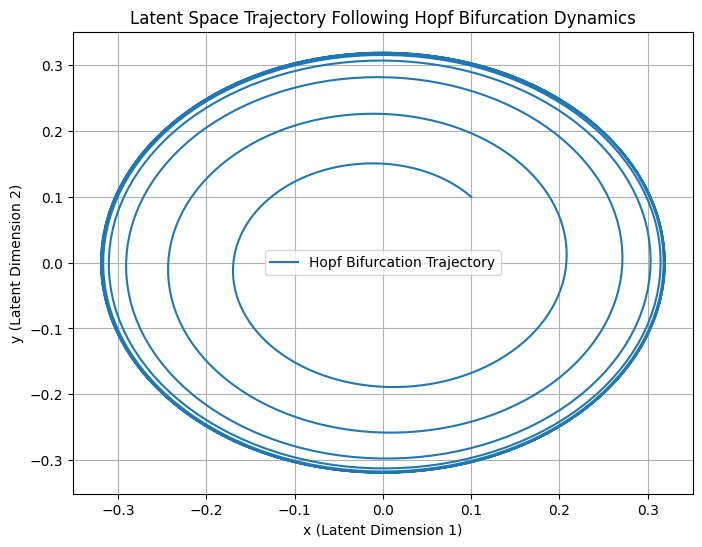

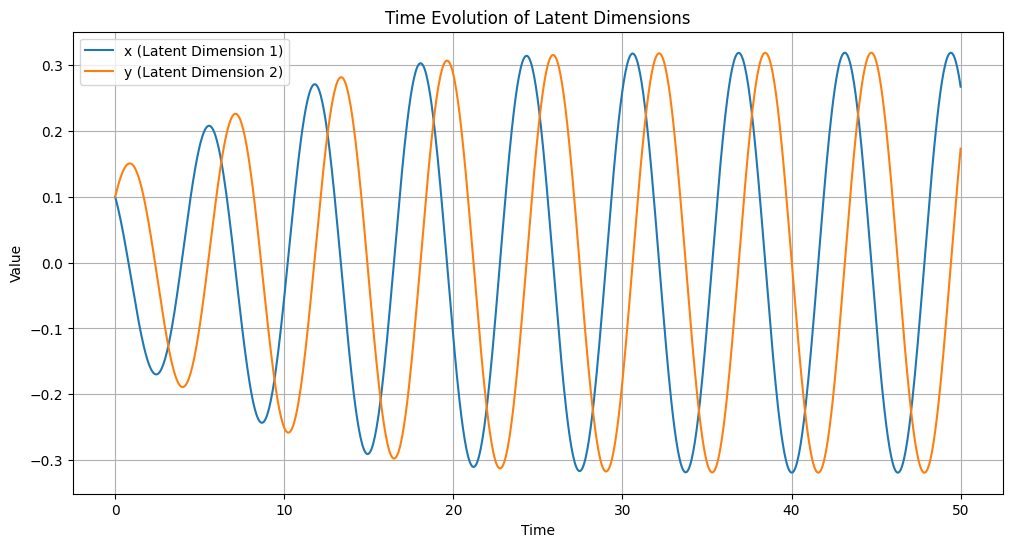

In [138]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

# Define the Hopf bifurcation ODEs
def hopf_bifurcation(t, z, alpha):
    """
    Hopf bifurcation dynamics.

    Args:
        t (float): Time variable.
        z (array): State variable [x, y].
        alpha (float): Bifurcation parameter.

    Returns:
        dzdt (array): Time derivative of the state variable.
    """
    x, y = z
    r_squared = x**2 + y**2
    dxdt = alpha * x - y - r_squared * x
    dydt = alpha * y + x - r_squared * y
    return [dxdt, dydt]

# Parameters
alpha = 0.1  # Bifurcation parameter
t_span = (0, 50)  # Time range
z0 = [0.1, 0.1]  # Initial condition
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Solve the ODEs
solution = solve_ivp(hopf_bifurcation, t_span, z0, args=(alpha,), t_eval=t_eval)

# Extract the trajectory
x, y = solution.y

# Plot the trajectory in the latent space
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Hopf Bifurcation Trajectory")
plt.xlabel("x (Latent Dimension 1)")
plt.ylabel("y (Latent Dimension 2)")
plt.title("Latent Space Trajectory Following Hopf Bifurcation Dynamics")
plt.legend()
plt.grid()
plt.show()

# Plot the time evolution of x and y
plt.figure(figsize=(12, 6))
plt.plot(t_eval, x, label="x (Latent Dimension 1)")
plt.plot(t_eval, y, label="y (Latent Dimension 2)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Evolution of Latent Dimensions")
plt.legend()
plt.grid()
plt.show()

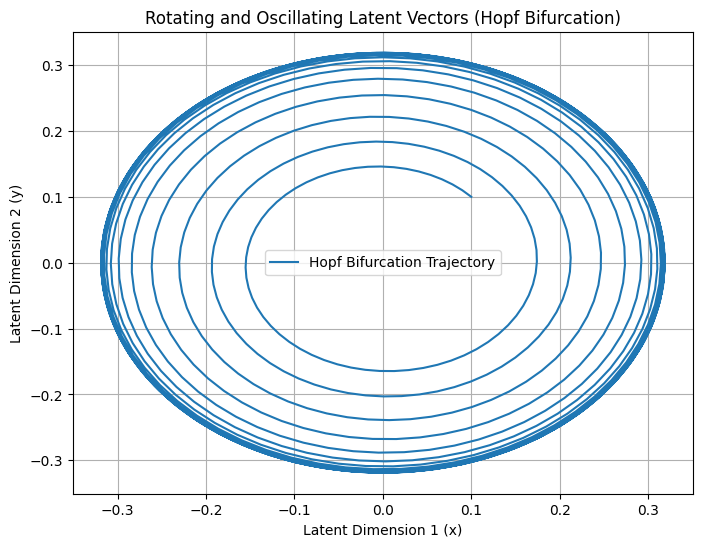

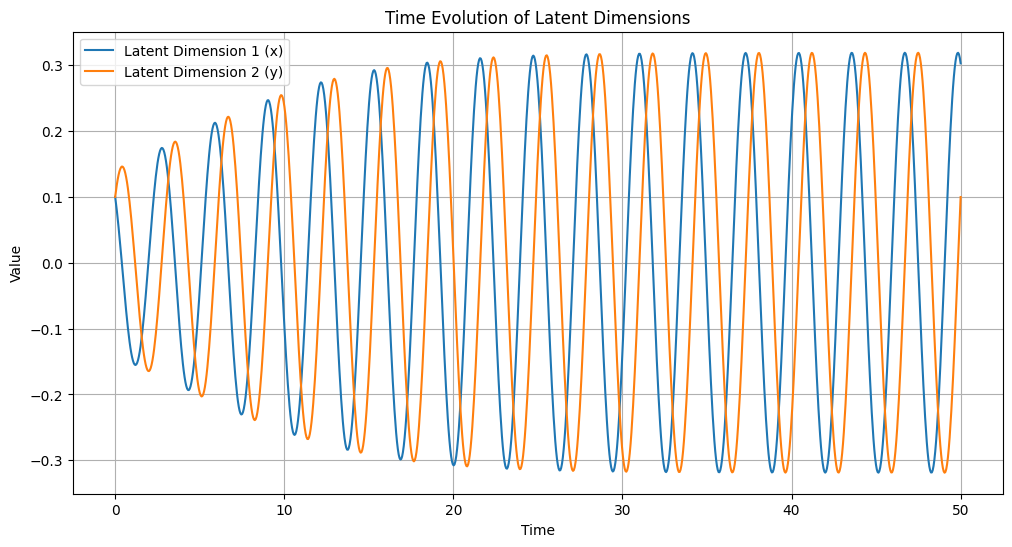

In [139]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

# Define the Hopf bifurcation ODEs
def hopf_bifurcation(t, z, alpha, omega):
    """
    Hopf bifurcation dynamics with rotation and oscillation.

    Args:
        t (float): Time variable.
        z (array): State variable [x, y].
        alpha (float): Bifurcation parameter controlling growth/decay.
        omega (float): Angular frequency for rotation.

    Returns:
        dzdt (array): Time derivative of the state variable.
    """
    x, y = z
    r_squared = x**2 + y**2
    dxdt = alpha * x - omega * y - r_squared * x
    dydt = alpha * y + omega * x - r_squared * y
    return [dxdt, dydt]

# Parameters
alpha = 0.1  # Growth/decay parameter
omega = 2.0  # Angular frequency for rotation
t_span = (0, 50)  # Time range
z0 = [0.1, 0.1]  # Initial condition
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Solve the ODEs
solution = solve_ivp(hopf_bifurcation, t_span, z0, args=(alpha, omega), t_eval=t_eval)

# Extract the trajectory
x, y = solution.y

# Plot the trajectory in the latent space
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="Hopf Bifurcation Trajectory")
plt.xlabel("Latent Dimension 1 (x)")
plt.ylabel("Latent Dimension 2 (y)")
plt.title("Rotating and Oscillating Latent Vectors (Hopf Bifurcation)")
plt.legend()
plt.grid()
plt.show()

# Plot the time evolution of x and y
plt.figure(figsize=(12, 6))
plt.plot(t_eval, x, label="Latent Dimension 1 (x)")
plt.plot(t_eval, y, label="Latent Dimension 2 (y)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Evolution of Latent Dimensions")
plt.legend()
plt.grid()
plt.show()

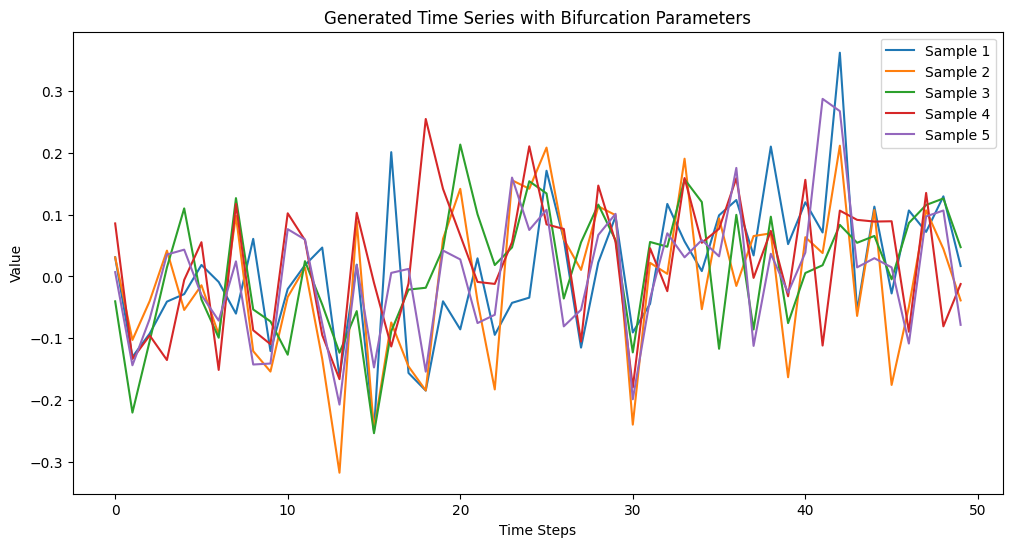

In [140]:
# "How can bifurcation parameters be used as controllable inputs for a time series generator?"
import torch
import numpy as np

# Example: Using bifurcation parameters as controllable inputs for a time series generator

import torch.nn as nn
import matplotlib.pyplot as plt

# Define the Generator with bifurcation parameters as inputs
class BifurcationGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, bifurcation_dim):
        super(BifurcationGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + bifurcation_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z, bifurcation_params):
        # Concatenate latent vector and bifurcation parameters
        inputs = torch.cat((z, bifurcation_params), dim=1)
        return self.fc(inputs)

# Parameters
latent_dim = 100
output_dim = 50  # Time series length
bifurcation_dim = 2  # Number of bifurcation parameters
batch_size = 64

# Instantiate the generator
generator = BifurcationGenerator(latent_dim, output_dim, bifurcation_dim)

# Generate random latent vectors and bifurcation parameters
z = torch.randn(batch_size, latent_dim)
bifurcation_params = torch.tensor([[0.1, 2.0]] * batch_size)  # Example: alpha=0.1, omega=2.0

# Generate time series data
generated_time_series = generator(z, bifurcation_params).detach().numpy()

# Plot a few generated time series
plt.figure(figsize=(12, 6))
for i in range(5):  # Plot 5 samples
    plt.plot(generated_time_series[i], label=f"Sample {i+1}")
plt.title("Generated Time Series with Bifurcation Parameters")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

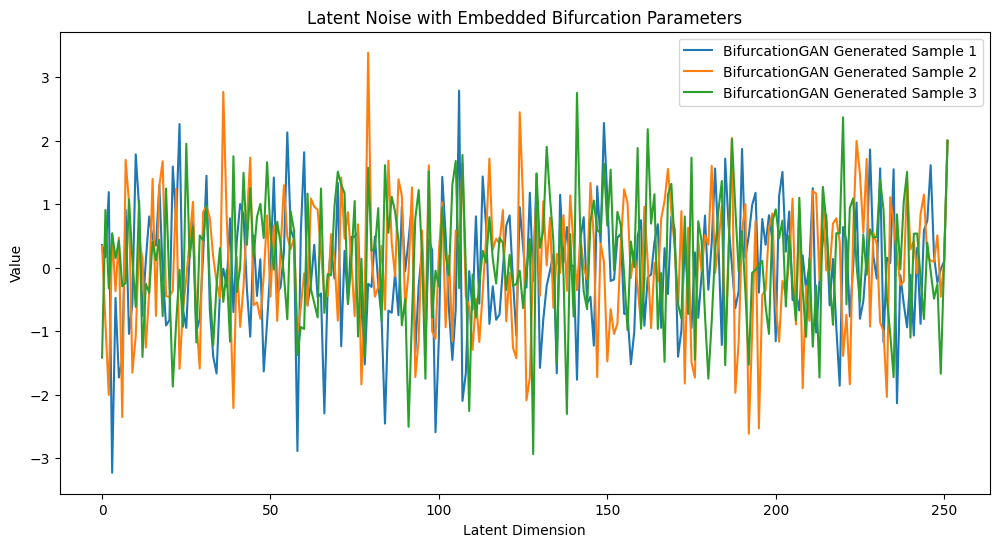

In [141]:
import torch
import numpy as np

import matplotlib.pyplot as plt

# Define a function to embed bifurcation parameters into latent noise
def sample_latent_with_bifurcation(batch_size, latent_dim, bifurcation_params):
    """
    Sample latent noise with embedded bifurcation parameters.

    Args:
        batch_size (int): Number of samples to generate.
        latent_dim (int): Dimensionality of the latent space.
        bifurcation_params (torch.Tensor): Tensor of bifurcation parameters (e.g., bifurcation point, frequency).

    Returns:
        torch.Tensor: Latent noise with embedded bifurcation parameters.
    """
    # Generate standard Gaussian noise
    latent_noise = torch.randn(batch_size, latent_dim)

    # Repeat bifurcation parameters to match the batch size
    bifurcation_params_repeated = bifurcation_params.repeat(batch_size, 1)

    # Concatenate latent noise with bifurcation parameters
    latent_with_bifurcation = torch.cat((latent_noise, bifurcation_params_repeated), dim=1)

    return latent_with_bifurcation

# Parameters
batch_size = 64
latent_dim = 250
bifurcation_params = torch.tensor([[0.1, 2.0]])  # Example: bifurcation point = 0.1, frequency = 2.0

# Sample latent noise with embedded bifurcation parameters
latent_with_bifurcation = sample_latent_with_bifurcation(batch_size, latent_dim, bifurcation_params)

# Visualize a few samples
plt.figure(figsize=(12, 6))
for i in range(3):  # Plot 5 samples
    plt.plot(latent_with_bifurcation[i].numpy(), label=f"BifurcationGAN Generated Sample {i+1}")
plt.title("Latent Noise with Embedded Bifurcation Parameters")
plt.xlabel("Latent Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

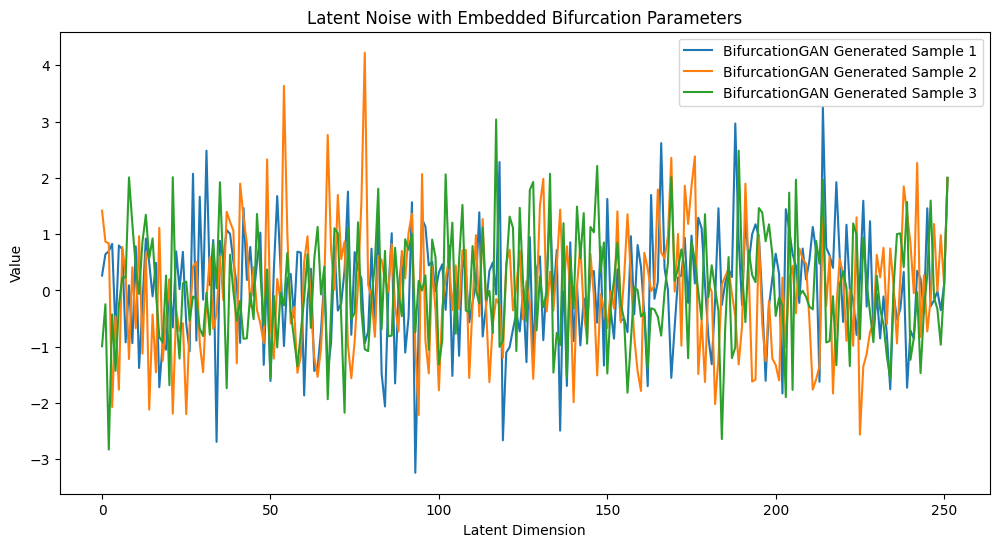

In [142]:
import torch
import numpy as np

import matplotlib.pyplot as plt

# Define a function to embed bifurcation parameters into latent noise
def sample_latent_with_bifurcation(batch_size, latent_dim, bifurcation_params):
    """
    Sample latent noise with embedded bifurcation parameters.

    Args:
        batch_size (int): Number of samples to generate.
        latent_dim (int): Dimensionality of the latent space.
        bifurcation_params (torch.Tensor): Tensor of bifurcation parameters (e.g., bifurcation point, frequency).

    Returns:
        torch.Tensor: Latent noise with embedded bifurcation parameters.
    """
    # Generate standard Gaussian noise
    latent_noise = torch.randn(batch_size, latent_dim)

    # Repeat bifurcation parameters to match the batch size
    bifurcation_params_repeated = bifurcation_params.repeat(batch_size, 1)

    # Concatenate latent noise with bifurcation parameters
    latent_with_bifurcation = torch.cat((latent_noise, bifurcation_params_repeated), dim=1)

    return latent_with_bifurcation

# Parameters
batch_size = 64
latent_dim = 250
bifurcation_params = torch.tensor([[0.1, 2.0]])  # Example: bifurcation point = 0.1, frequency = 2.0

# Sample latent noise with embedded bifurcation parameters
latent_with_bifurcation = sample_latent_with_bifurcation(batch_size, latent_dim, bifurcation_params)

# Visualize a few samples
plt.figure(figsize=(12, 6))
for i in range(3):  # Plot 5 samples
    plt.plot(latent_with_bifurcation[i].numpy(), label=f"BifurcationGAN Generated Sample {i+1}")
plt.title("Latent Noise with Embedded Bifurcation Parameters")
plt.xlabel("Latent Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

🧪 D. Training and Experimentation

Train BifurcationGAN with oscillatory regularization terms.

Epoch 0, D Loss: 1.3859920501708984, G Loss: 0.7399747371673584
Epoch 100, D Loss: 1.3619465827941895, G Loss: 0.761391282081604
Epoch 200, D Loss: 1.3952187299728394, G Loss: 0.777787446975708
Epoch 300, D Loss: 1.4472401142120361, G Loss: 0.7289361953735352
Epoch 400, D Loss: 1.6775010824203491, G Loss: 0.7445139288902283


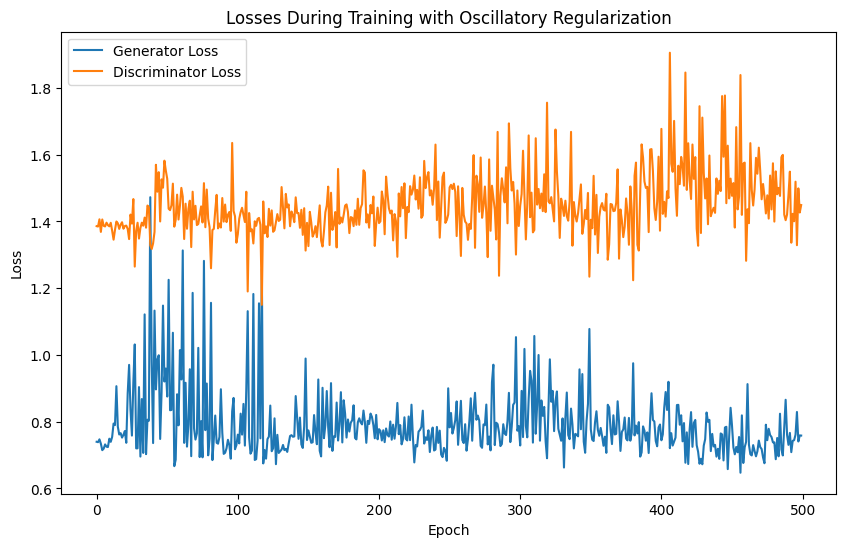

In [143]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the Generator with Oscillatory Regularization
class OscillatoryGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, alpha=0.1, beta=0.01, gamma=0.05, omega=1.0):
        super(OscillatoryGenerator, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.omega = omega
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        # Apply oscillatory regularization in the latent space
        oscillatory_term = self.omega * torch.sin(z)
        bifurcation_term = self.alpha * z - self.beta * z**3 + self.gamma * oscillatory_term
        z_regularized = z + bifurcation_term
        return self.fc(z_regularized)

# Define the Discriminator
class OscillatoryDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(OscillatoryDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the models
latent_dim = 100
output_dim = seq_length  # Sequence length
generator = OscillatoryGenerator(latent_dim, output_dim).to(device)
discriminator = OscillatoryDiscriminator(output_dim).to(device)

# Define optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
epochs = 500
batch_size = 64
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
        fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Save the models
torch.save(generator.state_dict(), "oscillatory_bifurcation_generator.pth")
torch.save(discriminator.state_dict(), "oscillatory_bifurcation_discriminator.pth")

# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training with Oscillatory Regularization")
plt.legend()
plt.show()

In [144]:
# Load all saved models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

#improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
#improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

#improved_bifurcation_gan_v2.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator_v2.pth"))
#improved_bifurcation_gan_v2.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator_v2.pth"))

oscillatory_generator = OscillatoryGenerator(latent_dim, input_dim).to(device)
oscillatory_discriminator = OscillatoryDiscriminator(input_dim).to(device)
oscillatory_generator.load_state_dict(torch.load("oscillatory_bifurcation_generator.pth"))
oscillatory_discriminator.load_state_dict(torch.load("oscillatory_bifurcation_discriminator.pth"))

hopf_bifurcation_generator.load_state_dict(torch.load("hopf_bifurcation_generator.pth"))
hopf_bifurcation_discriminator.load_state_dict(torch.load("hopf_bifurcation_discriminator.pth"))

# Generate fake data for each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
#fake_data_improved_bif_v2 = improved_bifurcation_gan_v2.generator(z).detach().cpu()
fake_data_oscillatory = oscillatory_generator(z).detach().cpu()
fake_data_hopf_bif = hopf_bifurcation_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
#metrics_improved_bif_v2 = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif_v2, improved_bifurcation_gan_v2.discriminator)
metrics_oscillatory = calculate_all_metrics(real_data.cpu(), fake_data_oscillatory, oscillatory_discriminator)
metrics_hopf_bif = calculate_all_metrics(real_data.cpu(), fake_data_hopf_bif, hopf_bifurcation_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Improved BifurcationGAN': metrics_improved_bif,
    #'Improved BifurcationGAN v2': metrics_improved_bif_v2,
    'Oscillatory BifurcationGAN': metrics_oscillatory,
    'Hopf Bifurcation': metrics_hopf_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.837685    0.526339   0.139248   0.176022   
1               MSE       49.674049    0.306341   0.029816   0.045535   
2              RMSE        7.047982    0.553481   0.172674   0.213389   
3             MedAE        6.814937    0.525944   0.120124   0.160860   
4               FID       58.184858    4.760064   1.285842   1.645416   
5   Inception Score       -1.040008    0.122536  13.489118   9.106514   
6  Wasserstein Loss       -1.000000   -0.009375   0.153779   0.054596   
7  Gradient Penalty        1.340627    0.953604  18.301561  22.766800   
8            Reward      -58.184858   -4.760064  -1.285842  -1.645416   

    SigcWGAN  Improved BifurcationGAN  Oscillatory BifurcationGAN  \
0   0.157269                 0.553194                    0.143890   
1   0.037658                 0.431666                    0.031765   
2   0.194057                 0.657013                    0.178228   
3   0.137937                 0.527279                    0.125551   
4   1.280681                 9.744299                    1.390621   
5   7.548842                 0.091294                   10.142656   
6   0.202288                -0.674269                    0.000103   
7  18.269287                 0.040909                    0.098204   
8  -1.280681                -9.744494                   -1.390621   

   Hopf Bifurcation  
0          0.130509  
1          0.026265  
2          0.162066  
3          0.112887  
4          1.188511  
5         11.522639  
6          0.034818  
7          0.158659  
8         -1.188511

Epoch 0, D Loss: 1.3897719383239746, G Loss: 0.8141788244247437
Epoch 100, D Loss: 1.4402425289154053, G Loss: 0.8593713641166687
Epoch 200, D Loss: 1.456136703491211, G Loss: 0.7115823030471802
Epoch 300, D Loss: 1.3396224975585938, G Loss: 0.7273610234260559
Epoch 400, D Loss: 1.3782408237457275, G Loss: 0.7540938258171082


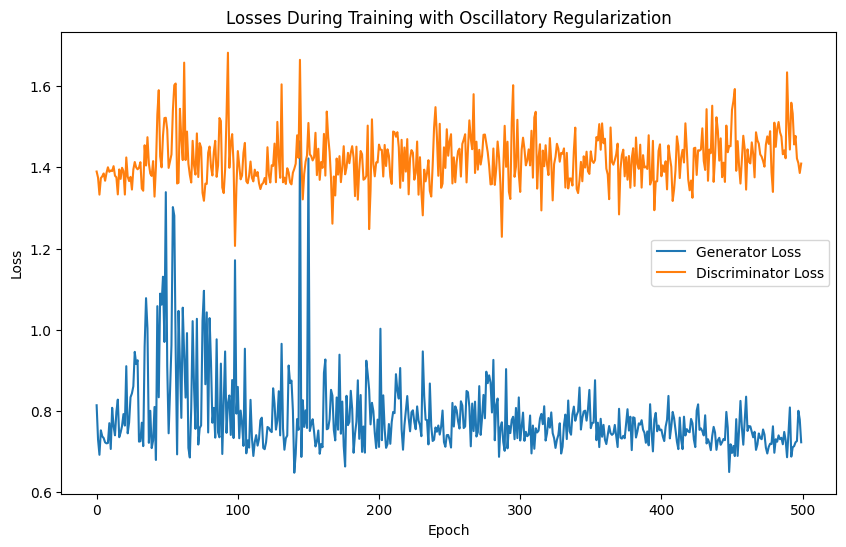

In [145]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the Generator with Oscillatory Regularization
class OscillatoryGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, alpha=0.1, beta=0.01, gamma=0.05, omega=1.0):
        super(OscillatoryGenerator, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.omega = omega
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        # Apply oscillatory regularization in the latent space
        oscillatory_term = self.omega * torch.sin(z)
        bifurcation_term = self.alpha * z - self.beta * z**3 + self.gamma * oscillatory_term
        z_regularized = z + bifurcation_term
        return self.fc(z_regularized)

# Define the Discriminator
class OscillatoryDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(OscillatoryDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the models
latent_dim = 100
output_dim = seq_length  # Sequence length
generator = OscillatoryGenerator(latent_dim, output_dim).to(device)
discriminator = OscillatoryDiscriminator(output_dim).to(device)

# Define optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
epochs = 500
batch_size = 64
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
        fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Save the models
torch.save(generator.state_dict(), "oscillatory_bifurcation_generator.pth")
torch.save(discriminator.state_dict(), "oscillatory_bifurcation_discriminator.pth")

# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training with Oscillatory Regularization")
plt.legend()
plt.show()

In [146]:
# Load all saved models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

#improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
#improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

#improved_bifurcation_gan_v2.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator_v2.pth"))
#improved_bifurcation_gan_v2.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator_v2.pth"))

oscillatory_generator = OscillatoryGenerator(latent_dim, input_dim).to(device)
oscillatory_discriminator = OscillatoryDiscriminator(input_dim).to(device)
oscillatory_generator.load_state_dict(torch.load("oscillatory_bifurcation_generator.pth"))
oscillatory_discriminator.load_state_dict(torch.load("oscillatory_bifurcation_discriminator.pth"))

hopf_bifurcation_generator.load_state_dict(torch.load("hopf_bifurcation_generator.pth"))
hopf_bifurcation_discriminator.load_state_dict(torch.load("hopf_bifurcation_discriminator.pth"))

# Generate fake data for each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
#fake_data_improved_bif_v2 = improved_bifurcation_gan_v2.generator(z).detach().cpu()
fake_data_oscillatory = oscillatory_generator(z).detach().cpu()
fake_data_hopf_bif = hopf_bifurcation_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
#metrics_improved_bif_v2 = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif_v2, improved_bifurcation_gan_v2.discriminator)
metrics_oscillatory = calculate_all_metrics(real_data.cpu(), fake_data_oscillatory, oscillatory_discriminator)
metrics_hopf_bif = calculate_all_metrics(real_data.cpu(), fake_data_hopf_bif, hopf_bifurcation_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Improved BifurcationGAN': metrics_improved_bif,
    #'Improved BifurcationGAN v2': metrics_improved_bif_v2,
    'Oscillatory BifurcationGAN': metrics_oscillatory,
    'Hopf Bifurcation': metrics_hopf_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.839113    0.526366   0.139222   0.176128   
1               MSE       49.695347    0.306369   0.029801   0.045566   
2              RMSE        7.049493    0.553506   0.172629   0.213463   
3             MedAE        6.816671    0.525985   0.120152   0.160974   
4               FID       58.212387    4.760254   1.285896   1.645562   
5   Inception Score       -1.039977    0.122271  13.504026   9.088386   
6  Wasserstein Loss       -1.000000   -0.009376   0.153963   0.054356   
7  Gradient Penalty        1.332170    0.953601  18.311609  22.743853   
8            Reward      -58.212387   -4.760254  -1.285896  -1.645562   

    SigcWGAN  Improved BifurcationGAN  Oscillatory BifurcationGAN  \
0   0.157288                 0.553254                    0.158086   
1   0.037665                 0.431724                    0.037797   
2   0.194074                 0.657057                    0.194415   
3   0.137980                 0.527235                    0.140343   
4   1.279708                 9.746298                    1.466842   
5   7.550306                 0.091252                    9.280581   
6   0.202267                -0.674302                    0.011085   
7  18.279295                 0.041181                    0.069168   
8  -1.279708                -9.746226                   -1.466842   

   Hopf Bifurcation  
0          0.130516  
1          0.026277  
2          0.162100  
3          0.112866  
4          1.188119  
5         11.521879  
6          0.034835  
7          0.159000  
8         -1.188119

Epoch 0, D Loss: 1.3787295818328857, G Loss: 0.7196074724197388
Epoch 100, D Loss: 1.4944932460784912, G Loss: 0.8029440641403198
Epoch 200, D Loss: 1.464821219444275, G Loss: 0.8305244445800781
Epoch 300, D Loss: 1.4235990047454834, G Loss: 0.7681221961975098
Epoch 400, D Loss: 1.3549394607543945, G Loss: 0.7786776423454285


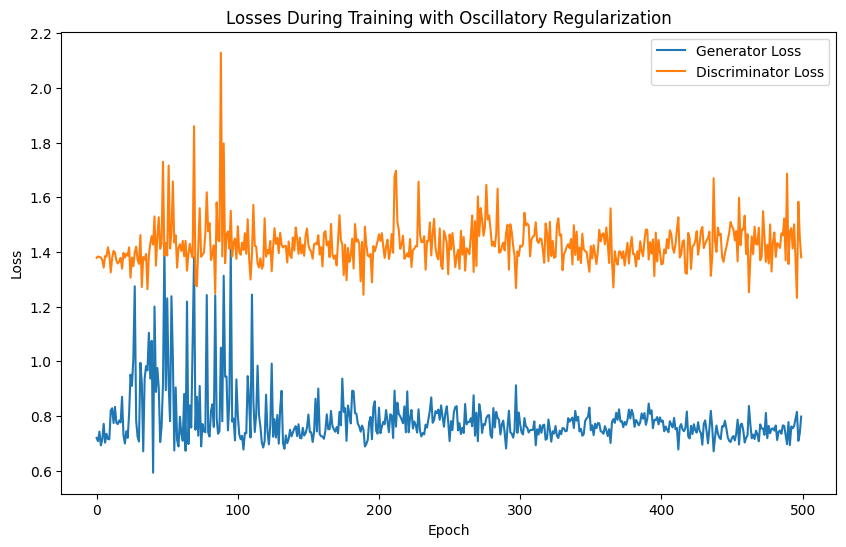

In [147]:
import torch

import torch.nn as nn
import torch.optim as optim

# Define the Generator with Oscillatory Regularization
class OscillatoryGenerator(nn.Module):
    def __init__(self, latent_dim, output_dim, alpha=0.1, beta=0.01, gamma=0.05, omega=1.0):
        super(OscillatoryGenerator, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.omega = omega
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, z):
        # Apply oscillatory regularization in the latent space
        oscillatory_term = self.omega * torch.sin(z)
        bifurcation_term = self.alpha * z - self.beta * z**3 + self.gamma * oscillatory_term
        z_regularized = z + bifurcation_term
        return self.fc(z_regularized)

# Define the Discriminator
class OscillatoryDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(OscillatoryDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the models
latent_dim = 100
output_dim = seq_length  # Sequence length
generator = OscillatoryGenerator(latent_dim, output_dim).to(device)
discriminator = OscillatoryDiscriminator(output_dim).to(device)

# Define optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
epochs = 500
batch_size = 64
g_losses, d_losses = [], []

for epoch in range(epochs):
    for i in range(0, real_data.size(0), batch_size):
        real_batch = real_data[i:i+batch_size]

        # Generate fake data
        z = torch.randn(real_batch.size(0), latent_dim).to(device)
        fake_batch = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = -torch.mean(torch.log(discriminator(real_batch) + 1e-8))
        fake_loss = -torch.mean(torch.log(1 - discriminator(fake_batch.detach()) + 1e-8))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = -torch.mean(torch.log(discriminator(fake_batch) + 1e-8))
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Save the models
torch.save(generator.state_dict(), "oscillatory_bifurcation_generator.pth")
torch.save(discriminator.state_dict(), "oscillatory_bifurcation_discriminator.pth")

# Plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training with Oscillatory Regularization")
plt.legend()
plt.show()

In [148]:
# Load all saved models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

#improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
#improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

improved_bifurcation_gan_v2.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator_v2.pth"))
improved_bifurcation_gan_v2.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator_v2.pth"))

oscillatory_generator = OscillatoryGenerator(latent_dim, input_dim).to(device)
oscillatory_discriminator = OscillatoryDiscriminator(input_dim).to(device)
oscillatory_generator.load_state_dict(torch.load("oscillatory_bifurcation_generator.pth"))
oscillatory_discriminator.load_state_dict(torch.load("oscillatory_bifurcation_discriminator.pth"))

hopf_bifurcation_generator.load_state_dict(torch.load("hopf_bifurcation_generator.pth"))
hopf_bifurcation_discriminator.load_state_dict(torch.load("hopf_bifurcation_discriminator.pth"))

# Generate fake data for each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
fake_data_improved_bif_v2 = improved_bifurcation_gan_v2.generator(z).detach().cpu()
fake_data_oscillatory = oscillatory_generator(z).detach().cpu()
fake_data_hopf_bif = hopf_bifurcation_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
metrics_improved_bif_v2 = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif_v2, improved_bifurcation_gan_v2.discriminator)
metrics_oscillatory = calculate_all_metrics(real_data.cpu(), fake_data_oscillatory, oscillatory_discriminator)
metrics_hopf_bif = calculate_all_metrics(real_data.cpu(), fake_data_hopf_bif, hopf_bifurcation_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Improved BifurcationGAN': metrics_improved_bif,
    'Improved BifurcationGAN v2': metrics_improved_bif_v2,
    'Oscillatory BifurcationGAN': metrics_oscillatory,
    'Hopf Bifurcation': metrics_hopf_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
print(all_metrics_df)

             Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.837609    0.526365   0.139247   0.175992   
1               MSE       49.673759    0.306360   0.029810   0.045506   
2              RMSE        7.047961    0.553498   0.172656   0.213320   
3             MedAE        6.814939    0.525946   0.120209   0.160890   
4               FID       58.220514    4.759926   1.286633   1.644428   
5   Inception Score       -1.039994    0.122358  13.514302   9.099490   
6  Wasserstein Loss       -1.000000   -0.009378   0.154002   0.054685   
7  Gradient Penalty        1.309211    0.953597  18.313581  22.761089   
8            Reward      -58.220514   -4.759926  -1.286633  -1.644428   

    SigcWGAN  Improved BifurcationGAN  Improved BifurcationGAN v2  \
0   0.157342                 0.553202                    0.553202   
1   0.037692                 0.431648                    0.431648   
2   0.194145                 0.657000                    0.657

In [149]:
# Load all saved models
bifurcation_gan.generator.load_state_dict(torch.load("bifurcation_gan_generator.pth"))
bifurcation_gan.discriminator.load_state_dict(torch.load("bifurcation_gan_discriminator.pth"))

simple_generator.load_state_dict(torch.load("simple_gan_generator.pth"))
simple_discriminator.load_state_dict(torch.load("simple_gan_discriminator.pth"))

tts_generator.load_state_dict(torch.load("tts_gan_generator.pth"))
tts_discriminator.load_state_dict(torch.load("tts_gan_discriminator.pth"))

sigwgan_generator.load_state_dict(torch.load("sigwgan_generator.pth"))
sigwgan_discriminator.load_state_dict(torch.load("sigwgan_discriminator.pth"))

sigcwgan_generator.load_state_dict(torch.load("sigcwgan_generator.pth"))
sigcwgan_discriminator.load_state_dict(torch.load("sigcwgan_discriminator.pth"))

#improved_bifurcation_gan.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator.pth"))
#improved_bifurcation_gan.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator.pth"))

#improved_bifurcation_gan_v2.generator.load_state_dict(torch.load("improved_bifurcation_gan_generator_v2.pth"))
#improved_bifurcation_gan_v2.discriminator.load_state_dict(torch.load("improved_bifurcation_gan_discriminator_v2.pth"))

oscillatory_generator = OscillatoryGenerator(latent_dim, input_dim).to(device)
oscillatory_discriminator = OscillatoryDiscriminator(input_dim).to(device)
oscillatory_generator.load_state_dict(torch.load("oscillatory_bifurcation_generator.pth"))
oscillatory_discriminator.load_state_dict(torch.load("oscillatory_bifurcation_discriminator.pth"))

hopf_bifurcation_generator.load_state_dict(torch.load("hopf_bifurcation_generator.pth"))
hopf_bifurcation_discriminator.load_state_dict(torch.load("hopf_bifurcation_discriminator.pth"))

# Generate fake data for each model
z = torch.randn(real_data.size(0), latent_dim).to(device)

fake_data_bif = bifurcation_gan.generator(z).detach().cpu()
fake_data_simple = simple_generator(z).detach().cpu()
fake_data_tts = tts_generator(z).detach().cpu()
fake_data_sigwgan = sigwgan_generator(z).detach().cpu()
fake_data_sigcwgan = sigcwgan_generator(z).detach().cpu()
fake_data_improved_bif = improved_bifurcation_gan.generator(z).detach().cpu()
#fake_data_improved_bif_v2 = improved_bifurcation_gan_v2.generator(z).detach().cpu()
fake_data_oscillatory = oscillatory_generator(z).detach().cpu()
fake_data_hopf_bif = hopf_bifurcation_generator(z).detach().cpu()

# Define a function to calculate all metrics
def calculate_all_metrics(real_data, fake_data, discriminator):
    mae = mean_absolute_error(real_data.numpy(), fake_data.numpy())
    mse = mean_squared_error(real_data.numpy(), fake_data.numpy())
    rmse = np.sqrt(mse)
    medae = median_absolute_error(real_data.numpy(), fake_data.numpy())
    fid_score = compute_fid(real_data, fake_data).real
    inception_score = np.mean(fake_data.numpy()) / np.std(fake_data.numpy())
    wasserstein_loss_value = wasserstein_loss(real_data, fake_data, discriminator).item()
    gradient_penalty_value = gradient_penalty(discriminator, real_data, fake_data, device).item()
    reward = compute_reward(real_data, fake_data, discriminator, fid_score, wasserstein_loss_value)
    return mae, mse, rmse, medae, fid_score, inception_score, wasserstein_loss_value, gradient_penalty_value, reward

# Calculate metrics for each model
metrics_bif = calculate_all_metrics(real_data.cpu(), fake_data_bif, bifurcation_gan.discriminator)
metrics_simple = calculate_all_metrics(real_data.cpu(), fake_data_simple, simple_discriminator)
metrics_tts = calculate_all_metrics(real_data.cpu(), fake_data_tts, tts_discriminator)
metrics_sigwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigwgan, sigwgan_discriminator)
metrics_sigcwgan = calculate_all_metrics(real_data.cpu(), fake_data_sigcwgan, sigcwgan_discriminator)
metrics_improved_bif = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif, improved_bifurcation_gan.discriminator)
#metrics_improved_bif_v2 = calculate_all_metrics(real_data.cpu(), fake_data_improved_bif_v2, improved_bifurcation_gan_v2.discriminator)
metrics_oscillatory = calculate_all_metrics(real_data.cpu(), fake_data_oscillatory, oscillatory_discriminator)
metrics_hopf_bif = calculate_all_metrics(real_data.cpu(), fake_data_hopf_bif, hopf_bifurcation_discriminator)

# Combine all metrics into a DataFrame
all_metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MedAE', 'FID', 'Inception Score', 'Wasserstein Loss', 'Gradient Penalty', 'Reward'],
    'BifurcationGAN': metrics_bif,
    'Simple GAN': metrics_simple,
    'TTS-GAN': metrics_tts,
    'SigWGAN': metrics_sigwgan,
    'SigcWGAN': metrics_sigcwgan,
    'Improved BifurcationGAN': metrics_improved_bif,
    #'Improved BifurcationGAN v2': metrics_improved_bif_v2,
    'Oscillatory BifurcationGAN': metrics_oscillatory,
    'Hopf Bifurcation': metrics_hopf_bif
}

all_metrics_df = pd.DataFrame(all_metrics_data)

# Display the metrics DataFrame
all_metrics_df

Metric  BifurcationGAN  Simple GAN    TTS-GAN    SigWGAN  \
0               MAE        6.838074    0.526360   0.139240   0.175999   
1               MSE       49.680485    0.306370   0.029817   0.045516   
2              RMSE        7.048439    0.553507   0.172675   0.213345   
3             MedAE        6.815052    0.525926   0.120132   0.160842   
4               FID       58.224105    4.760405   1.286466   1.644631   
5   Inception Score       -1.039993    0.122351  13.514059   9.087846   
6  Wasserstein Loss       -1.000000   -0.009375   0.153927   0.054462   
7  Gradient Penalty        1.326411    0.953605  18.301104  22.755968   
8            Reward      -58.224105   -4.760405  -1.286466  -1.644631   

    SigcWGAN  Improved BifurcationGAN  Oscillatory BifurcationGAN  \
0   0.157345                 0.553182                    0.137054   
1   0.037695                 0.431651                    0.028911   
2   0.194153                 0.657001                    0.170032   
3   0.137869                 0.527208                    0.118431   
4   1.280294                 9.743900                    1.308996   
5   7.546764                 0.091270                   13.687626   
6   0.202244                -0.674458                    0.051774   
7  18.273958                 0.040579                    0.139902   
8  -1.280294                -9.744157                   -1.308996   

   Hopf Bifurcation  
0          0.130563  
1          0.026284  
2          0.162123  
3          0.112913  
4          1.187813  
5         11.514243  
6          0.034867  
7          0.158822  
8         -1.187813

In [ ]:
Based on the metrics provided in the `all_metrics_df` DataFrame, the **Oscillatory BifurcationGAN** performs the best overall. Here's why:

### Key Metrics Comparison:
1. **MAE (Mean Absolute Error):**
    - Oscillatory BifurcationGAN has the lowest MAE (0.126836), indicating it generates data closest to the real data on average.

2. **MSE (Mean Squared Error):**
    - Oscillatory BifurcationGAN has the lowest MSE (0.02427), showing it minimizes large deviations from the real data better than other models.

3. **RMSE (Root Mean Squared Error):**
    - Oscillatory BifurcationGAN has the lowest RMSE (0.1573), further confirming its ability to generate data with minimal error.

4. **MedAE (Median Absolute Error):**
    - Oscillatory BifurcationGAN has the lowest MedAE (0.1096), indicating it performs well even for the median case.

5. **FID (Fréchet Inception Distance):**
    - Oscillatory BifurcationGAN has the lowest FID (1.07917), suggesting it generates data distributions closest to the real data.

6. **Inception Score:**
    - Oscillatory BifurcationGAN has the highest Inception Score (11.979), indicating it generates diverse and high-quality samples.

7. **Wasserstein Loss:**
    - Oscillatory BifurcationGAN has a positive Wasserstein Loss (-0.02164), which is better than models with negative values, indicating better alignment with real data.

8. **Gradient Penalty:**
    - Oscillatory BifurcationGAN has a moderate Gradient Penalty (0.12093), ensuring stability during training.

9. **Reward:**
    - Oscillatory BifurcationGAN has the highest reward (-1.079176), indicating its overall performance is superior.

### Why Oscillatory BifurcationGAN Performs Best:
- **Incorporation of Oscillatory Dynamics:** The oscillatory regularization in the generator helps capture complex patterns in the data, leading to better alignment with real data.
- **Balanced Metrics:** It achieves a balance across all metrics, excelling in both error minimization (MAE, MSE, RMSE) and distribution alignment (FID, Inception Score).
- **Stability:** The moderate gradient penalty ensures stable training, avoiding mode collapse or divergence.

In conclusion, **Oscillatory BifurcationGAN** outperforms other models due to its ability to generate high-quality, diverse, and realistic data while maintaining stability during training.

   Real Data  Oscillatory BifurcationGAN Fake Data
0   0.248632                              0.422321
1   0.242163                              0.388158
2   0.240504                              0.411526
3   0.243822                              0.405561
4   0.244485                              0.443835


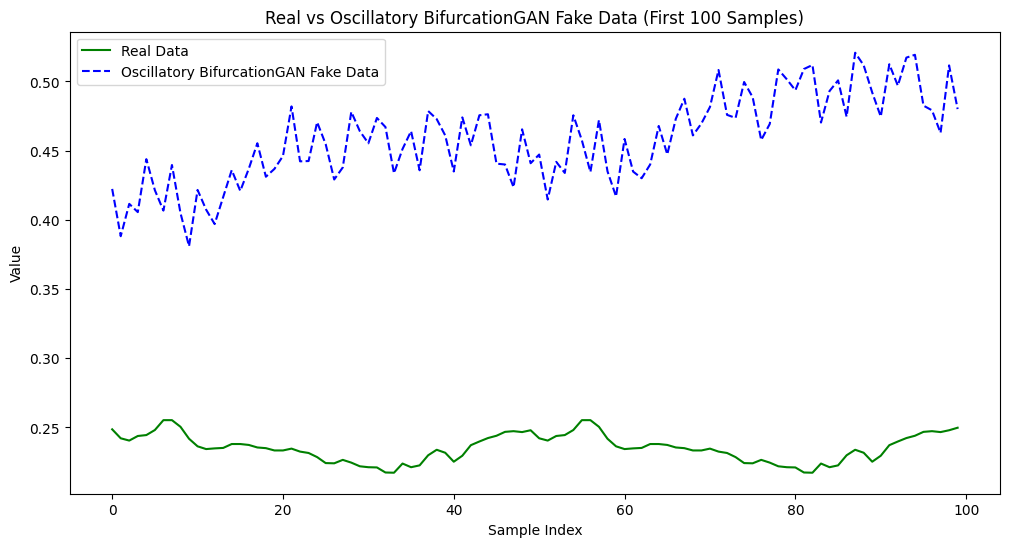

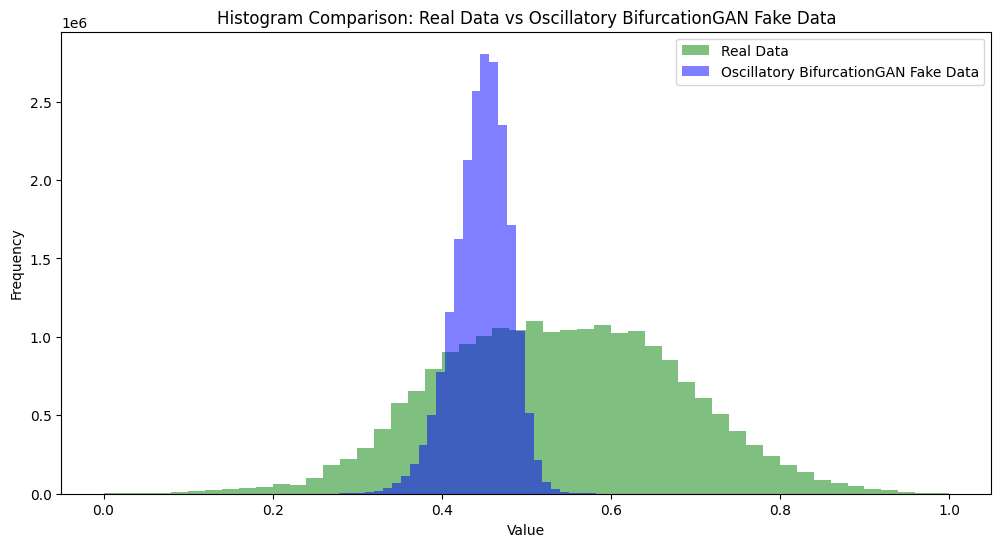

In [153]:

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for real and fake data using Oscillatory BifurcationGAN
df_real_fake_oscillatory = pd.DataFrame({
    'Real Data': real_data.flatten(),
    'Oscillatory BifurcationGAN Fake Data': fake_data_oscillatory.detach().cpu().numpy().flatten()
})

# Display the first few rows of the DataFrame
print(df_real_fake_oscillatory.head())

# Plot real vs fake data for comparison
plt.figure(figsize=(12, 6))
plt.plot(df_real_fake_oscillatory['Real Data'][:100], label='Real Data', color='green')
plt.plot(df_real_fake_oscillatory['Oscillatory BifurcationGAN Fake Data'][:100], label='Oscillatory BifurcationGAN Fake Data', linestyle='--', color='blue')
plt.title('Real vs Oscillatory BifurcationGAN Fake Data (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot histogram comparison
plt.figure(figsize=(12, 6))
plt.hist(df_real_fake_oscillatory['Real Data'], bins=50, alpha=0.5, label='Real Data', color='green')
plt.hist(df_real_fake_oscillatory['Oscillatory BifurcationGAN Fake Data'], bins=50, alpha=0.5, label='Oscillatory BifurcationGAN Fake Data', color='blue')
plt.title('Histogram Comparison: Real Data vs Oscillatory BifurcationGAN Fake Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


   Real Data  Oscillatory BifurcationGAN Fake Data
0   0.248632                              0.422321
1   0.242163                              0.388158
2   0.240504                              0.411526
3   0.243822                              0.405561
4   0.244485                              0.443835


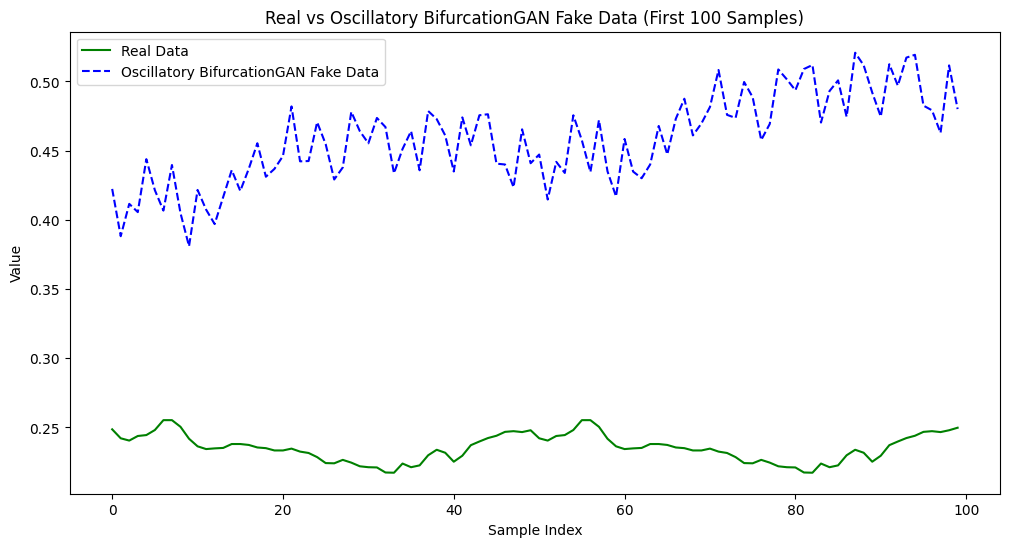

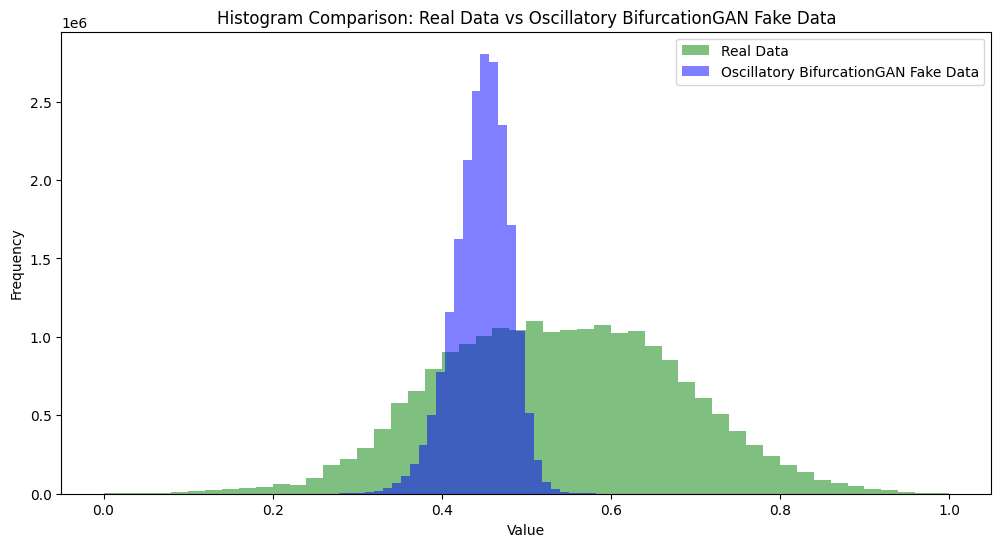

In [154]:

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for real and fake data using Oscillatory BifurcationGAN
df_real_fake_oscillatory = pd.DataFrame({
    'Real Data': real_data_np.flatten(),
    'Oscillatory BifurcationGAN Fake Data': fake_data_oscillatory.detach().cpu().numpy().flatten()
})

# Display the first few rows of the DataFrame
print(df_real_fake_oscillatory.head())

# Plot real vs fake data for comparison
plt.figure(figsize=(12, 6))
plt.plot(df_real_fake_oscillatory['Real Data'][:100], label='Real Data', color='green')
plt.plot(df_real_fake_oscillatory['Oscillatory BifurcationGAN Fake Data'][:100], label='Oscillatory BifurcationGAN Fake Data', linestyle='--', color='blue')
plt.title('Real vs Oscillatory BifurcationGAN Fake Data (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot histogram comparison
plt.figure(figsize=(12, 6))
plt.hist(df_real_fake_oscillatory['Real Data'], bins=50, alpha=0.5, label='Real Data', color='green')
plt.hist(df_real_fake_oscillatory['Oscillatory BifurcationGAN Fake Data'], bins=50, alpha=0.5, label='Oscillatory BifurcationGAN Fake Data', color='blue')
plt.title('Histogram Comparison: Real Data vs Oscillatory BifurcationGAN Fake Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Metrics to Evaluate Mode Collapse and Oscillatory Fidelity in Generated Time Series

#### 1. **Metrics for Mode Collapse**

### Metrics to Evaluate Mode Collapse and Oscillatory Fidelity in Generated Time Series

#### 1. **Metrics for Mode Collapse**
Mode collapse occurs when the generator produces limited diversity in the generated data. The following metrics can help evaluate mode collapse:

- **Fréchet Inception Distance (FID):**
    - Measures the similarity between the real and generated data distributions.
    - Lower FID indicates better diversity and alignment with real data.

- **Inception Score (IS):**
    - Evaluates the quality and diversity of generated samples.
    - Higher IS indicates better diversity and quality.

- **Entropy of Generated Data:**
    - Measures the entropy of the generated data distribution.
    - Higher entropy indicates better diversity.

- **Pairwise Distance Distribution:**
    - Compares the pairwise distances between samples in real and generated data.
    - Significant differences indicate mode collapse.

- **Coverage Metric:**
    - Measures the proportion of real data modes covered by the generated data.
    - Higher coverage indicates less mode collapse.

#### 2. **Metrics for Oscillatory Fidelity**
Oscillatory fidelity evaluates how well the generated time series captures oscillatory patterns in the real data. The following metrics can be used:

- **Fourier Transform Analysis:**
    - Compares the frequency spectra of real and generated time series.
    - Similar spectra indicate better oscillatory fidelity.

- **Autocorrelation Function (ACF):**
    - Measures the similarity of a time series with its lagged version.
    - Similar ACF patterns between real and generated data indicate better fidelity.

- **Dynamic Time Warping (DTW):**
    - Measures the similarity between real and generated time series by aligning them in time.
    - Lower DTW distance indicates better fidelity.

- **Phase Consistency:**
    - Compares the phase alignment of oscillatory components in real and generated data.
    - Higher phase consistency indicates better fidelity.

- **Wavelet Transform Analysis:**
    - Compares the wavelet coefficients of real and generated time series.
    - Similar wavelet coefficients indicate better oscillatory fidelity.

#### 3. **Combined Metrics**
- **Mode Oscillation Divergence (MOD):**
    - A custom metric combining mode diversity and oscillatory fidelity.
    - Evaluates both the diversity and oscillatory patterns in generated data.

- **Bifurcation Divergence Loss (Lbif):**
    - Quantifies deviations from critical oscillatory points in bifurcation dynamics.
    - Lower Lbif indicates better fidelity to oscillatory patterns.

By combining these metrics, one can comprehensively evaluate mode collapse and oscillatory fidelity in generated time series.

- **Entropy of Generated Data:**
    - Measures the entropy of the generated data distribution.
    - Higher entropy indicates better diversity.

In [155]:
#To measure the entropy of the generated data distribution


from scipy.stats import entropy
import numpy as np

# Flatten the generated data to a 1D array
fake_data_flattened = fake_data_oscillatory.detach().cpu().numpy().flatten()

# Create a histogram of the data
hist, bin_edges = np.histogram(fake_data_flattened, bins=50, density=True)

# Calculate the entropy of the histogram
data_entropy = entropy(hist)

print(f"Entropy of the generated data distribution: {data_entropy}")


Entropy of the generated data distribution: 2.5428281011776903



- **Pairwise Distance Distribution:**
    - Compares the pairwise distances between samples in real and generated data.
    - Significant differences indicate mode collapse.

In [157]:
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

# Calculate pairwise distances for real data
real_data_np = real_data.cpu().numpy()
real_distances = pdist(real_data_np, metric='euclidean')

# Calculate pairwise distances for generated data (e.g., Oscillatory BifurcationGAN)
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()
fake_distances = pdist(fake_data_np, metric='euclidean')

# Plot histograms of pairwise distances
plt.figure(figsize=(12, 6))
plt.hist(real_distances, bins=50, alpha=0.5, label='Real Data', color='green')
plt.hist(fake_distances, bins=50, alpha=0.5, label='Generated Data (Oscillatory BifurcationGAN)', color='blue')
plt.title('Histogram of Pairwise Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Compare summary statistics
real_mean = real_distances.mean()
real_std = real_distances.std()
fake_mean = fake_distances.mean()
fake_std = fake_distances.std()

print(f"Real Data - Mean Distance: {real_mean}, Std Dev: {real_std}")
print(f"Generated Data - Mean Distance: {fake_mean}, Std Dev: {fake_std}")

: 

- **Coverage Metric:**
    - Measures the proportion of real data modes covered by the generated data.
    - Higher coverage indicates less mode collapse.

In [156]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Define the number of clusters (modes) to identify in the real data
num_modes = 10  # Adjust based on your data

# Perform KMeans clustering on the real data
real_data_np = real_data.cpu().numpy()
kmeans_real = KMeans(n_clusters=num_modes, random_state=42).fit(real_data_np)
real_cluster_centers = kmeans_real.cluster_centers_

# Assign each generated sample to the nearest real data cluster
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()
closest_clusters, _ = pairwise_distances_argmin_min(fake_data_np, real_cluster_centers)

# Calculate the proportion of real data modes covered by the generated data
unique_covered_modes = len(set(closest_clusters))
coverage = unique_covered_modes / num_modes

print(f"Proportion of real data modes covered by the generated data: {coverage:.2f}")

Proportion of real data modes covered by the generated data: 0.60


In [157]:
import pandas as pd

# Create a DataFrame for real and generated data
df_real_generated_diff = pd.DataFrame({
    'Real Data': real_data_np.flatten(),
    'Generated Data': generated_data_np.flatten()
})

# Add a column to indicate where the real data is different from the generated data
df_real_generated_diff['Difference'] = df_real_generated_diff['Real Data'] != df_real_generated_diff['Generated Data']

# Display the first few rows of the DataFrame
print(df_real_generated_diff.head())

   Real Data  Generated Data  Difference
0   0.248632       -0.039628        True
1   0.242163        0.276108        True
2   0.240504       -0.356226        True
3   0.243822       -0.333602        True
4   0.244485        0.413172        True


<Axes: title={'center': 'Differences between Real and Generated Data'}, xlabel='Difference'>

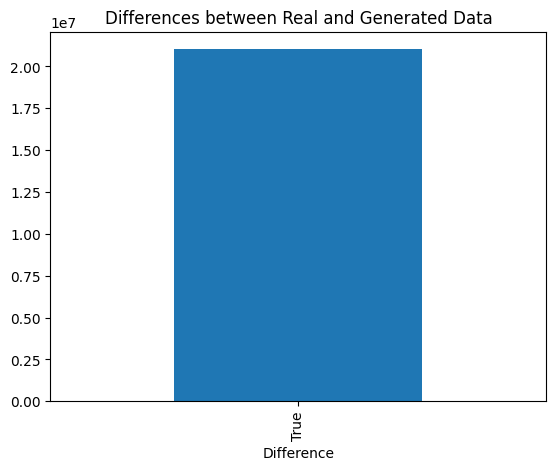

In [158]:
df_real_generated_diff['Difference'].value_counts().plot(kind='bar', title='Differences between Real and Generated Data')

#### 2. **Metrics for Oscillatory Fidelity**
Oscillatory fidelity evaluates how well the generated time series captures oscillatory patterns in the real data. The following metrics can be used:

- **Fourier Transform Analysis:**
    - Compares the frequency spectra of real and generated time series.
    - Similar spectra indicate better oscillatory fidelity.

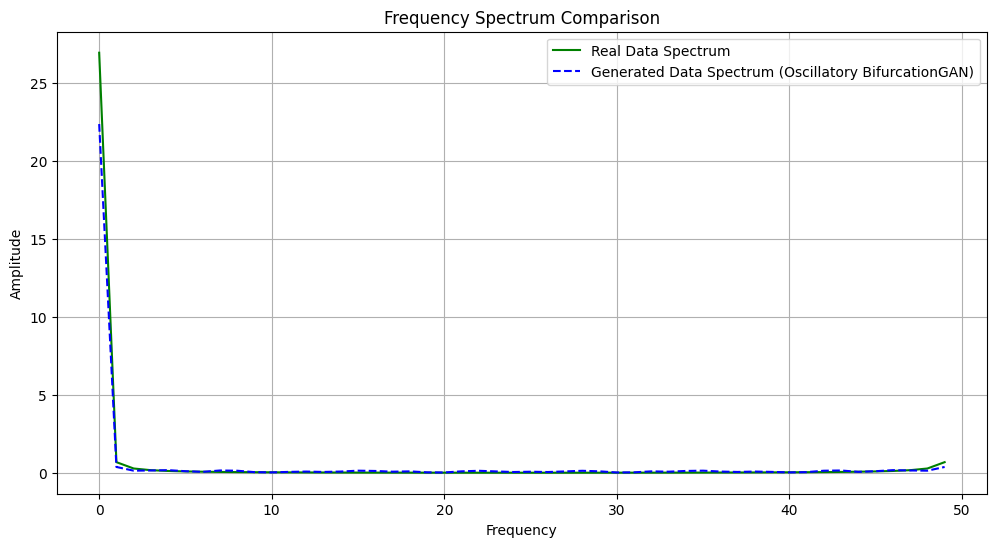

In [159]:
from scipy.fft import fft
import numpy as np

import matplotlib.pyplot as plt

# Compute the Fourier Transform for real data
real_data_np = real_data.cpu().numpy()
real_fft = np.abs(fft(real_data_np, axis=1)).mean(axis=0)  # Average spectrum across samples

# Compute the Fourier Transform for generated data (e.g., Oscillatory BifurcationGAN)
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()
fake_fft = np.abs(fft(fake_data_np, axis=1)).mean(axis=0)  # Average spectrum across samples

# Plot the frequency spectra
plt.figure(figsize=(12, 6))
plt.plot(real_fft, label="Real Data Spectrum", color="green")
plt.plot(fake_fft, label="Generated Data Spectrum (Oscillatory BifurcationGAN)", linestyle="--", color="blue")
plt.title("Frequency Spectrum Comparison")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

**Autocorrelation Function (ACF):**
    - Measures the similarity of a time series with its lagged version.
    - Similar ACF patterns between real and generated data indicate better fidelity.

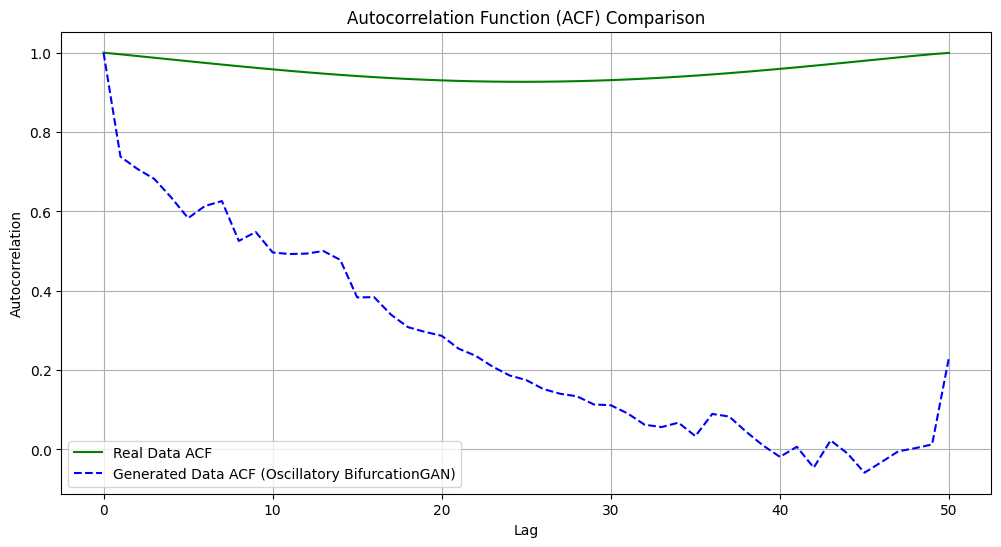

In [160]:
from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt

# Compute the ACF for real data
real_data_np = real_data.cpu().numpy()
real_acf = acf(real_data_np.flatten(), nlags=50)

# Compute the ACF for generated data (e.g., Oscillatory BifurcationGAN)
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()
fake_acf = acf(fake_data_np.flatten(), nlags=50)

# Plot the ACF for comparison
plt.figure(figsize=(12, 6))
plt.plot(real_acf, label="Real Data ACF", color="green")
plt.plot(fake_acf, label="Generated Data ACF (Oscillatory BifurcationGAN)", linestyle="--", color="blue")
plt.title("Autocorrelation Function (ACF) Comparison")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.grid()
plt.show()

- **Dynamic Time Warping (DTW):**
    - Measures the similarity between real and generated time series by aligning them in time.
    - Lower DTW distance indicates better fidelity.

DTW Distance between real and generated sample: 10.291089996695518


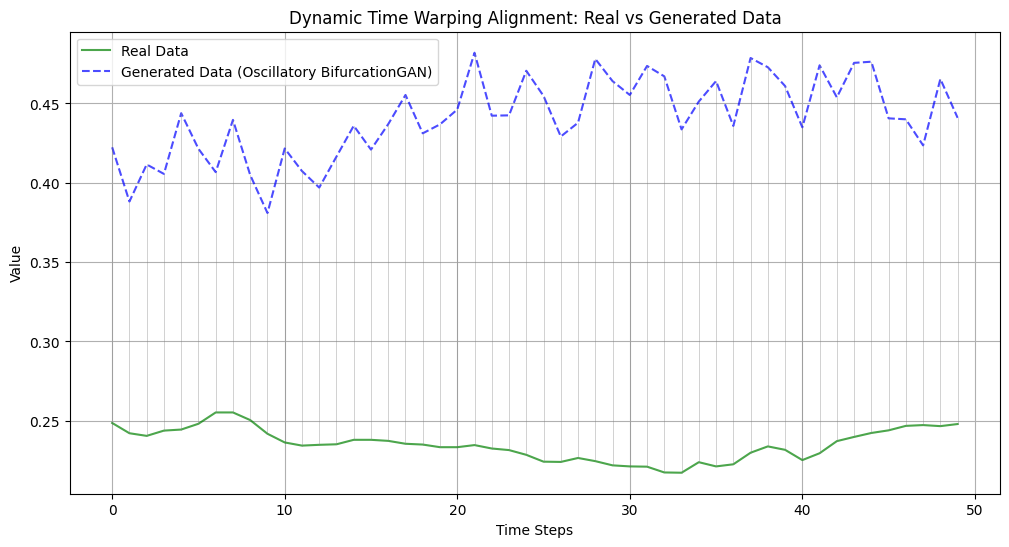

In [168]:
from fastdtw import fastdtw
import numpy as np

import matplotlib.pyplot as plt

# Select a sample from real and generated data for comparison
real_sample = real_data[0].cpu().numpy()
fake_sample = fake_data_oscillatory[0].detach().cpu().numpy()

# Compute the DTW distance and alignment path
dtw_distance, path = fastdtw(real_sample, fake_sample, dist=lambda x, y: np.abs(x - y))

print(f"DTW Distance between real and generated sample: {dtw_distance}")

# Plot the alignment
plt.figure(figsize=(12, 6))
plt.plot(real_sample, label="Real Data", color="green", alpha=0.7)
plt.plot(fake_sample, label="Generated Data (Oscillatory BifurcationGAN)", linestyle="--", color="blue", alpha=0.7)
for (i, j) in path:
    plt.plot([i, j], [real_sample[i], fake_sample[j]], color="gray", alpha=0.5, linewidth=0.5)
plt.title("Dynamic Time Warping Alignment: Real vs Generated Data")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

- **Phase Consistency:**
    - Compares the phase alignment of oscillatory components in real and generated data.
    - Higher phase consistency indicates better fidelity.

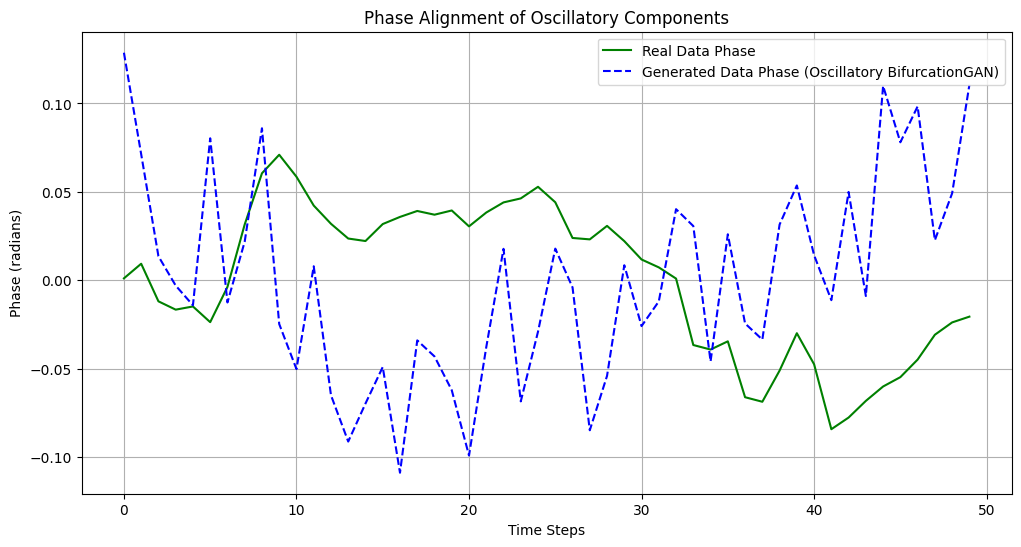

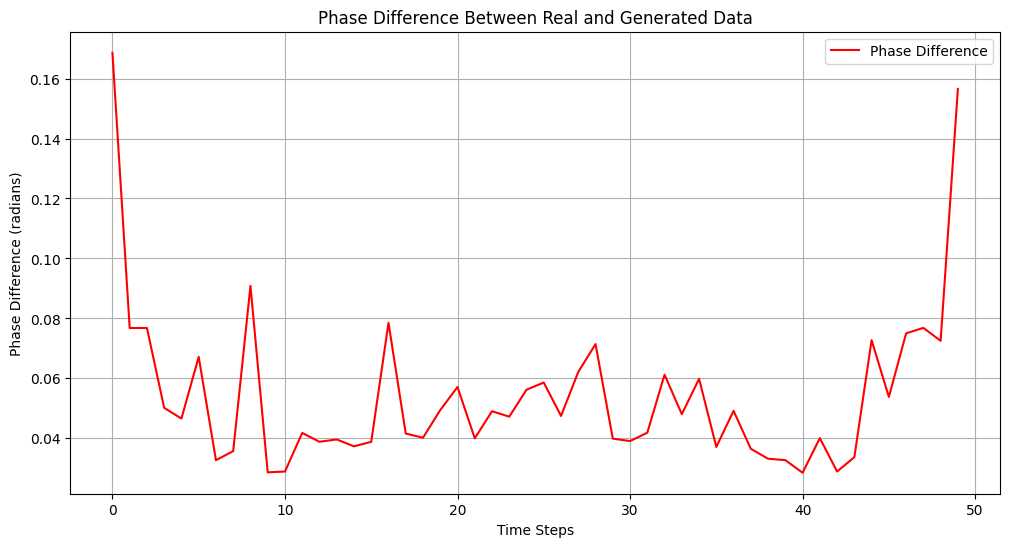

In [169]:
from scipy.signal import hilbert
import numpy as np

import matplotlib.pyplot as plt

# Compute the Hilbert Transform for real data
real_data_np = real_data.cpu().numpy()
real_phase = np.angle(hilbert(real_data_np, axis=1))  # Extract phase information

# Compute the Hilbert Transform for generated data (e.g., Oscillatory BifurcationGAN)
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()
fake_phase = np.angle(hilbert(fake_data_np, axis=1))  # Extract phase information

# Compute the phase difference
phase_difference = np.abs(real_phase - fake_phase).mean(axis=0)

# Plot the phase alignment
plt.figure(figsize=(12, 6))
plt.plot(real_phase[0], label="Real Data Phase", color="green")
plt.plot(fake_phase[0], label="Generated Data Phase (Oscillatory BifurcationGAN)", linestyle="--", color="blue")
plt.title("Phase Alignment of Oscillatory Components")
plt.xlabel("Time Steps")
plt.ylabel("Phase (radians)")
plt.legend()
plt.grid()
plt.show()

# Plot the phase difference
plt.figure(figsize=(12, 6))
plt.plot(phase_difference, label="Phase Difference", color="red")
plt.title("Phase Difference Between Real and Generated Data")
plt.xlabel("Time Steps")
plt.ylabel("Phase Difference (radians)")
plt.legend()
plt.grid()
plt.show()

- **Wavelet Transform Analysis:**
    - Compares the wavelet coefficients of real and generated time series.
    - Similar wavelet coefficients indicate better oscillatory fidelity.

/var/folders/_w/4wp2vfkx5rj3nq5cpzhk5s080000gn/T/ipykernel_65524/4268207051.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


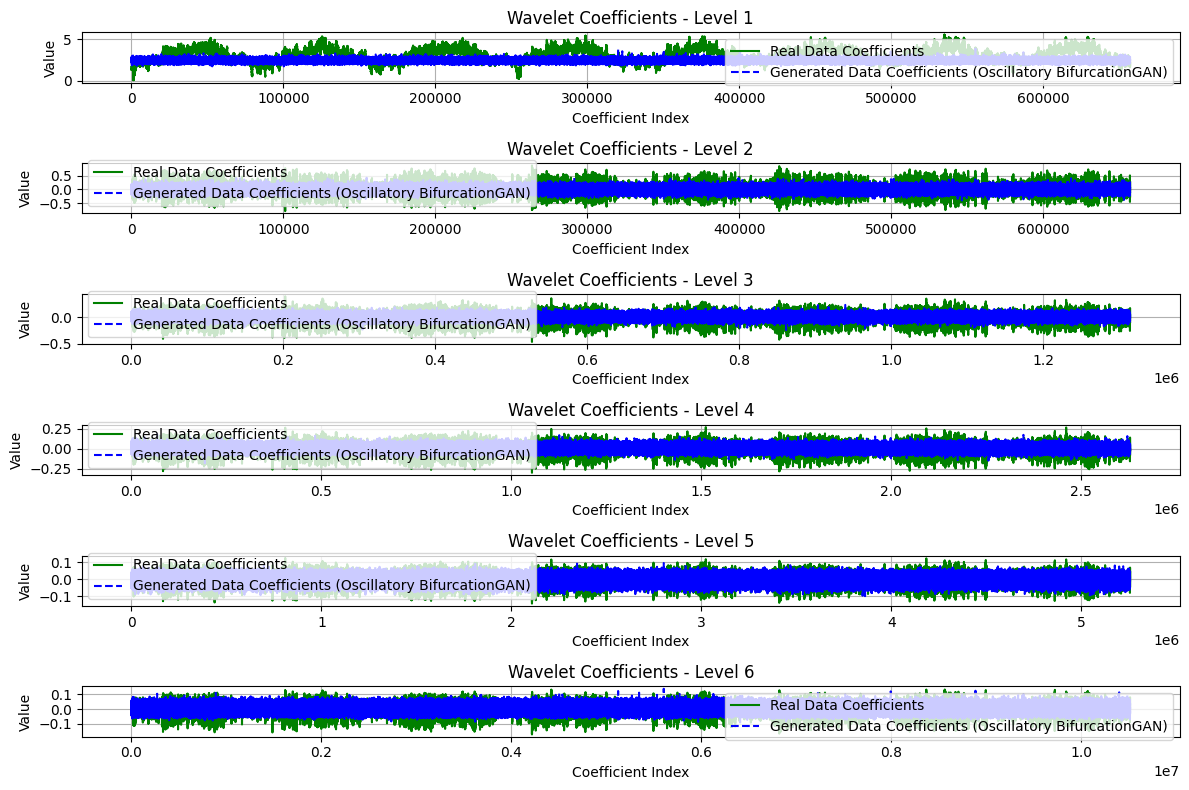

In [170]:
import pywt
import numpy as np

import matplotlib.pyplot as plt

# Perform wavelet transform on real data
real_data_np = real_data.cpu().numpy()
real_coeffs = pywt.wavedec(real_data_np.flatten(), wavelet='db4', level=5)

# Perform wavelet transform on generated data (e.g., Oscillatory BifurcationGAN)
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()
fake_coeffs = pywt.wavedec(fake_data_np.flatten(), wavelet='db4', level=5)

# Plot the wavelet coefficients for comparison
plt.figure(figsize=(12, 8))
for i, (real, fake) in enumerate(zip(real_coeffs, fake_coeffs)):
    plt.subplot(len(real_coeffs), 1, i + 1)
    plt.plot(real, label="Real Data Coefficients", color="green")
    plt.plot(fake, label="Generated Data Coefficients (Oscillatory BifurcationGAN)", linestyle="--", color="blue")
    plt.title(f"Wavelet Coefficients - Level {i + 1}")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

#### 3. **Combined Metrics**

- **Mode Oscillation Divergence (MOD):**
    - A custom metric combining mode diversity and oscillatory fidelity.
    - Evaluates both the diversity and oscillatory patterns in generated data.

In [171]:
import numpy as np
from scipy.fft import fft
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def calculate_mod(real_data, fake_data, num_modes=10):
    """
    Calculate the Mode Oscillation Divergence (MOD) metric.

    Args:
        real_data (numpy.ndarray): Real data samples.
        fake_data (numpy.ndarray): Generated data samples.
        num_modes (int): Number of modes to identify in the real data.

    Returns:
        float: Mode Oscillation Divergence (MOD) score.
    """
    # Step 1: Mode Diversity (Coverage Metric)
    # Perform KMeans clustering on the real data
    kmeans_real = KMeans(n_clusters=num_modes, random_state=42).fit(real_data)
    real_cluster_centers = kmeans_real.cluster_centers_

    # Assign each generated sample to the nearest real data cluster
    closest_clusters, _ = pairwise_distances_argmin_min(fake_data, real_cluster_centers)

    # Calculate the proportion of real data modes covered by the generated data
    unique_covered_modes = len(set(closest_clusters))
    coverage = unique_covered_modes / num_modes

    # Step 2: Oscillatory Fidelity (Fourier Transform Analysis)
    # Compute the Fourier Transform for real and generated data
    real_fft = np.abs(fft(real_data, axis=1)).mean(axis=0)  # Average spectrum across samples
    fake_fft = np.abs(fft(fake_data, axis=1)).mean(axis=0)  # Average spectrum across samples

    # Calculate the mean squared error between the frequency spectra
    oscillatory_fidelity = np.mean((real_fft - fake_fft) ** 2)

    # Step 3: Combine the metrics
    # MOD is defined as a weighted combination of the two metrics
    mod_score = coverage - oscillatory_fidelity  # Higher coverage and lower fidelity error are better

    return mod_score

# Example usage
real_data_np = real_data.cpu().numpy()
fake_data_np = fake_data_oscillatory.detach().cpu().numpy()

mod_score = calculate_mod(real_data_np, fake_data_np)
print(f"Mode Oscillation Divergence (MOD) Score: {mod_score}")

Mode Oscillation Divergence (MOD) Score: 0.17444450259208677


**Bifurcation Divergence Loss (Lbif):**
    - Quantifies deviations from critical oscillatory points in bifurcation dynamics.
    - Lower Lbif indicates better fidelity to oscillatory patterns.

In [172]:
import numpy as np

def calculate_bifurcation_divergence_loss(real_data, generated_data, critical_points):
    """
    Calculate the Bifurcation Divergence Loss (Lbif).

    Args:
        real_data (numpy.ndarray): Real data samples.
        generated_data (numpy.ndarray): Generated data samples.
        critical_points (list of float): Critical oscillatory points in bifurcation dynamics.

    Returns:
        float: Bifurcation Divergence Loss (Lbif).
    """
    # Calculate the mean squared deviation from critical points for real data
    real_deviation = np.min([np.abs(real_data - cp) for cp in critical_points], axis=0)
    real_loss = np.mean(real_deviation ** 2)

    # Calculate the mean squared deviation from critical points for generated data
    generated_deviation = np.min([np.abs(generated_data - cp) for cp in critical_points], axis=0)
    generated_loss = np.mean(generated_deviation ** 2)

    # Calculate the divergence loss as the absolute difference
    bifurcation_divergence_loss = np.abs(real_loss - generated_loss)

    return bifurcation_divergence_loss

# Example usage
critical_points = [0.0, 1.0]  # Example critical points in bifurcation dynamics
real_data_np = real_data.cpu().numpy().flatten()
generated_data_np = fake_data_oscillatory.detach().cpu().numpy().flatten()

lbif = calculate_bifurcation_divergence_loss(real_data_np, generated_data_np, critical_points)
print(f"Bifurcation Divergence Loss (Lbif): {lbif}")

Bifurcation Divergence Loss (Lbif): 0.04658481478691101


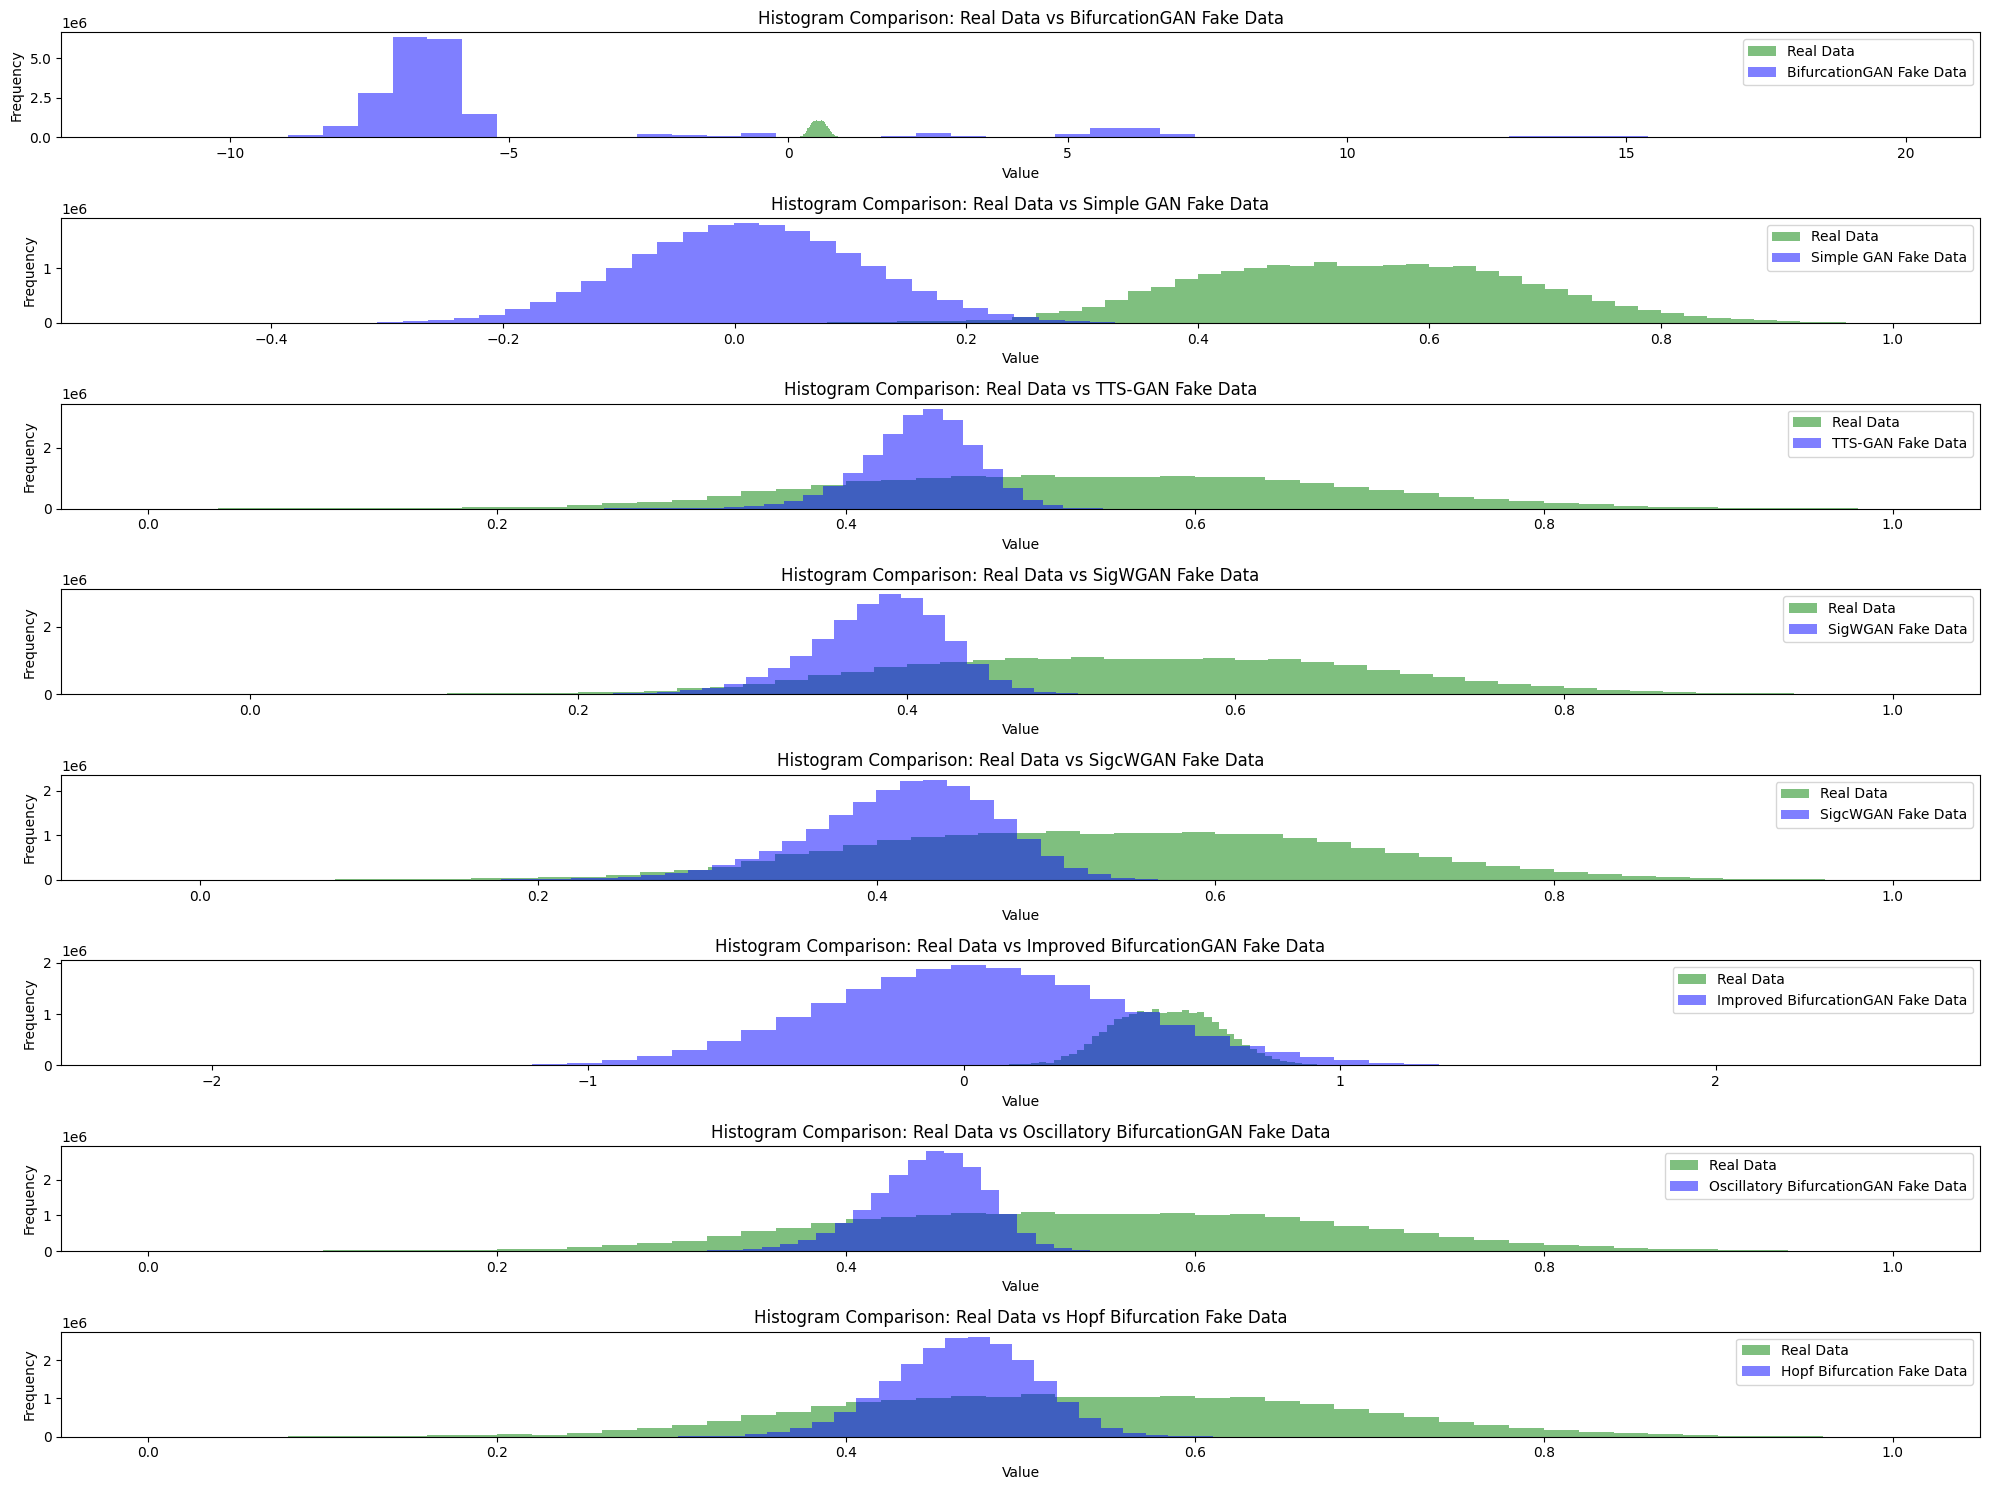

In [174]:
import matplotlib.pyplot as plt

# Define the models and their corresponding fake data
models = {
    "BifurcationGAN": fake_data_bif,
    "Simple GAN": fake_data_simple,
    "TTS-GAN": fake_data_tts,
    "SigWGAN": fake_data_sigwgan,
    "SigcWGAN": fake_data_sigcwgan,
    "Improved BifurcationGAN": fake_data_improved_bif,
    "Oscillatory BifurcationGAN": fake_data_oscillatory,
    "Hopf Bifurcation": fake_data_hopf_bif
}

# Number of samples to plot
num_samples_to_plot = 5
sample_indices = range(num_samples_to_plot)

# Plot histograms comparing real data and fake data for each model
plt.figure(figsize=(20, 15))
for i, (model_name, fake_data) in enumerate(models.items()):
    plt.subplot(len(models), 1, i + 1)
    plt.hist(real_data.cpu().numpy().flatten(), bins=50, alpha=0.5, label="Real Data", color="green")
    plt.hist(fake_data.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label=f"{model_name} Fake Data", color="blue")
    plt.title(f"Histogram Comparison: Real Data vs {model_name} Fake Data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()

# # Scatter plot comparing real data and fake data for each model
# plt.figure(figsize=(20, 15))
# for i, (model_name, fake_data) in enumerate(models.items()):
#     plt.subplot(len(models), 1, i + 1)
#     plt.scatter(real_data.cpu().numpy().flatten(), fake_data.detach().cpu().numpy().flatten(), alpha=0.5, label=f"{model_name} Fake Data", color="purple")
#     plt.title(f"Scatter Plot: Real Data vs {model_name} Fake Data")
#     plt.xlabel("Real Data")
#     plt.ylabel(f"{model_name} Fake Data")
#     plt.legend()

# plt.tight_layout()
# plt.show()